## Helpers and Imports

In [46]:
# For imports at top of repo

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

In [47]:
import pandas as pd
import numpy as np
import torch
from typing import Tuple, Dict, Any
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

import torch
from model.model import MoEModel, Config, optimize

# Set device
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

torch.manual_seed(np.random.randint(0, 10000))

save_path = "phase_change_results_1/"


In [48]:
def superposition_measure(x_i: np.ndarray, X: np.ndarray) -> float:
    """Σ_j ( x̂_i · x_j )²  – ‘superposition score’ for one feature."""
    x_hat_i = x_i / np.linalg.norm(x_i)
    overlaps = X @ x_hat_i
    return float(np.sum(overlaps**2))


def color_from_xy(x: float, y: float, max_x: float = 1.0, max_y: float = 1.0) -> tuple[float, float, float]:
    """
    Reconstruct the paper’s legend → RGB.
      • x (horizontal)  = superposition score, clipped to ≤ 1
          0 ⇒ blue,  1 ⇒ red
      • y (vertical)    = ‖W_i‖,           clipped to ≤ 1
          0 ⇒ white, 1 ⇒ full-strength hue
    """
    # x = np.clip(x, 0, 1)
    # y = np.clip(y, 0, 1)
    max_x = max(max_x, 1)
    max_y = max(max_y, 1)

    base = np.array([x, 0.0, max_x - x])      # blue→red ramp
    return tuple(y * base + (max_y - y))        # mix with white


def rgb_to_hex(rgb: tuple[float, float, float]) -> str:
    return '#{:02x}{:02x}{:02x}'.format(
        *(int(round(255 * c)) for c in rgb)
    )


In [49]:
def compute_feature_metrics(W: np.ndarray) -> pd.DataFrame:
    """
    For every row of a weight-matrix **W** (shape = (n_features, d)) return:

      • norm         – ‖W_i‖
      • super_score  – Σ_j (x̂_i·x_j)²
      • x_coord      – clipped super_score  (what the paper puts on x-axis)
      • y_coord      – clipped norm         (what the paper puts on y-axis)
      • colour_hex   – HTML / matplotlib colour that matches the legend
    """
    if torch.is_tensor(W):
        W = W.detach().cpu().numpy()
    
    rows = []
    for i in range(W.shape[0]):
        norm_i = np.linalg.norm(W[i])
        sup_i  = superposition_measure(W[i], W)
        x_i    = sup_i # min(sup_i, 1.0)
        y_i    = norm_i # min(norm_i, 1.0)
        rows.append(
            (norm_i, sup_i, x_i, y_i, rgb_to_hex(color_from_xy(x_i, y_i)))
        )

    return pd.DataFrame(
        rows,
        columns=["norm", "super_score", "x_coord", "y_coord", "colour_hex"],
    )


In [50]:
dim_scalar = 1

def color_from_metrics(norm: float, superpos: float, max_norm: float, max_super: float) -> Tuple[float, float, float]:
    """
    Map (norm, superpos) to an RGB tuple with:
    - Top right (high norm, high super) -> Red
    - Top left (high norm, low super) -> Blue
    - Bottom (low norm) -> White
    
    Args:
        norm: L2 norm of the weights
        superpos: Superposition score
        max_norm: Maximum norm for normalization
        max_super: Maximum superposition score for normalization
    """

    # Normalize inputs to [0,1]
    y = np.clip(norm / max_norm, 0.0, dim_scalar)      # Vertical axis (norm)
    x = np.clip(superpos / max_super, 0.0, dim_scalar)  # Horizontal axis (superposition)
    
    # Create color components
    red = y * x           # Increases towards top-right
    blue = y * (dim_scalar - x)    # Increases towards top-left
    # All components approach 1 (white) as y approaches 0 (bottom)
    white_blend = dim_scalar - y
    
    # Blend with white
    r = red + white_blend
    g = white_blend
    b = blue + white_blend
    
    # Normalize to [0,1]
    return (
        min(dim_scalar, max(0.0, r)),
        min(dim_scalar, max(0.0, g)),
        min(dim_scalar, max(0.0, b))
    )

def plot_colormap_plotly(n: int = 200, *, max_norm: float = 1.0, max_super: float = 1.0):
    """
    Interactive Plotly visualization of the (norm, superposition) → color mapping.
    - x-axis: superposition (0 → 1)
    - y-axis: norm (0 → 1), origin at bottom (like origin='lower' in matplotlib)
    """
    # Build RGB image using your color_from_metrics(norm, superpos, max_norm, max_super)
    color_grid = np.zeros((n, n, 3), dtype=float)  # [rows (norm), cols (super)]
    norms = np.linspace(0.0, dim_scalar, n)
    supers = np.linspace(0.0, dim_scalar, n)
    for i, y in enumerate(norms):
        for j, x in enumerate(supers):
            color_grid[i, j] = color_from_metrics(
                norm=y, superpos=x, max_norm=max_norm, max_super=max_super
            )

    # Plotly expects 0-255 uint8 for go.Image
    img = (np.clip(color_grid, 0.0, 1) * 255).astype(np.uint8)

    # Each pixel spans dx, dy to map [0,1] on both axes
    dx = 1 / (n - 1) * dim_scalar
    dy = 1 / (n - 1) * dim_scalar

    fig = go.Figure(go.Image(z=img, x0=0.0, dx=dx, y0=0.0, dy=dy))
    # Make y increase upward (origin at bottom)
    fig.update_yaxes(range=[0, dim_scalar])
    fig.update_xaxes(range=[0, dim_scalar])

    fig.update_layout(
        width=800, height=600,
        title="Color Mapping Visualization (Plotly)",
        xaxis_title="Superposition Score",
        yaxis_title="L2 Norm (normalized)",
        margin=dict(l=60, r=20, t=60, b=60),
    )

    # Clean hover to show continuous coordinates
    fig.update_traces(
        hovertemplate="superposition=%{x:.3f}<br>norm=%{y:.3f}<extra></extra>"
    )

    # Annotations like the matplotlib version
    fig.add_annotation(x=0.10*dim_scalar, y=0.90*dim_scalar, text="Blue<br>(High norm,<br>Low super)", showarrow=False,
                       xanchor="center", yanchor="middle", font_color="white")
    fig.add_annotation(x=0.90*dim_scalar, y=0.90*dim_scalar, text="Red<br>(High norm,<br>High super)", showarrow=False,
                       xanchor="center", yanchor="middle", font_color="white")
    fig.add_annotation(x=0.50*dim_scalar, y=0.10*dim_scalar, text="White<br>(Low norm)", showarrow=False,
                       xanchor="center", yanchor="middle", font_color="black")

    return fig

# Usage:
fig = plot_colormap_plotly(n=200)
fig.show()


In [51]:
def analyze_norm_and_superposition_all_experts(grid_results, config, feature_index=-1, figsize=(15, 5), ):
    """
    Analyze norm and superposition for all experts in a given grid of results.
    
    Args:
        grid_results: Dictionary of results keyed by (sparsity, importance)
        config: Configuration object containing sparsity_values and importance_values
        figsize: Figure size for the plots (default: (15, 5))
    """
    sparsity_values = config.sparsity_values
    importance_values = config.importance_values
    n_experts = config.n_experts
    
    print(f"Analyzing {n_experts} experts for feature {feature_index}")
    
    # Store metrics for each grid cell and expert
    norm_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
    superposition_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
    color_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values), 3))

    # Analyze each expert
    for expert_id in range(n_experts):
        
        # Analyze each grid cell for this expert
        for i, sparsity in enumerate(sparsity_values):
            for j, importance in enumerate(importance_values):
                result = grid_results[(sparsity, importance)]
                
                # Get expert weights (shape: [1, 2, 1] -> [2, 1])
                expert_weights = result['expert_weights']  # First (and only) expert
                
                # Get weights for this expert
                expert_weight_matrix = expert_weights[expert_id]  # Shape: [n_features, n_hidden]
                
                expert_metrics = compute_feature_metrics(expert_weight_matrix).iloc[feature_index]
                
                norm_grids[expert_id, i, j] = expert_metrics['norm']
                superposition_grids[expert_id, i, j] = expert_metrics['super_score']

        # Analyze each grid cell for colors for this expert
        for i, sparsity in enumerate(sparsity_values):
            for j, importance in enumerate(importance_values):

                # Store RGB values for color visualization
                rgb_color = color_from_metrics(
                    norm_grids[expert_id, i, j], 
                    superposition_grids[expert_id, i, j],
                    max_norm=np.max(norm_grids[expert_id]),
                    max_super=np.max(superposition_grids[expert_id])
                )
                color_grids[expert_id, i, j] = rgb_color

    # Create visualization for each expert
    for expert_id in range(n_experts):
        
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle(f'Expert {expert_id} Analysis', fontsize=16)

        # Plot 1: Norms
        im1 = axes[0].imshow(norm_grids[expert_id], cmap='viridis', aspect='auto')
        axes[0].set_xlabel('Last Feature Importance')
        axes[0].set_ylabel('Feature Sparsity')
        axes[0].set_title('L2 Norms of Expert Weights')
        plt.colorbar(im1, ax=axes[0])

        # Plot 2: Superposition
        im2 = axes[1].imshow(superposition_grids[expert_id], cmap='viridis', aspect='auto')
        axes[1].set_xlabel('Last Feature Importance')
        axes[1].set_ylabel('Feature Sparsity')
        axes[1].set_title('Superposition Scores')
        plt.colorbar(im2, ax=axes[1])

        # Plot 3: Combined color visualization
        im3 = axes[2].imshow(color_grids[expert_id], aspect='auto')
        axes[2].set_xlabel('Last Feature Importance')
        axes[2].set_ylabel('Feature Sparsity')
        axes[2].set_title('Phase Change Diagram')

        # Set tick labels
        for ax in axes:
            x_step = max(1, len(importance_values) // 8)
            y_step = max(1, len(sparsity_values) // 6)
            
            x_ticks = range(0, len(importance_values), x_step)
            y_ticks = range(0, len(sparsity_values), y_step)
            
            ax.set_xticks(x_ticks)
            ax.set_xticklabels([f'{importance_values[i]:.1f}' for i in x_ticks], rotation=45, ha='right')
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{sparsity_values[i]:.2f}' for i in y_ticks])

        plt.tight_layout()
        plt.show()
    
    return norm_grids, superposition_grids, color_grids, sparsity_values, importance_values

In [52]:
def _as_np(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return np.asarray(x)

def _pick_tickvals(vals, max_ticks):
    vals = _as_np(vals).astype(float)
    if len(vals) <= max_ticks:
        return vals, [f"{v:.2f}" for v in vals]
    idx = np.linspace(0, len(vals)-1, max_ticks).round().astype(int)
    picked = vals[idx]
    return picked, [f"{v:.2f}" for v in picked]

def _shape_or_fill_from_dict(grid_results, s_vals, i_vals, key_name='final_loss'):
    """Build z[i,j] from dict keyed by (sparsity, importance)."""
    z = np.full((len(s_vals), len(i_vals)), np.nan, float)
    # Make a fast lookup with tolerance for float keys
    keys = [k for k in grid_results.keys() if isinstance(k, tuple) and len(k) == 2]
    if not keys:
        return z
    s_keys = np.array([float(k[0]) for k in keys])
    i_keys = np.array([float(k[1]) for k in keys])
    for ii, s in enumerate(s_vals):
        s_idx = np.argmin(np.abs(s_keys - s))
        s_near = s_keys[s_idx]
        # collect all keys with this s_near (tolerant)
        mask_s = np.isclose(s_keys, s_near, rtol=0, atol=1e-9)
        i_keys_local = i_keys[mask_s]
        keys_local   = np.array(keys, dtype=object)[mask_s]
        for jj, imp in enumerate(i_vals):
            j_loc = np.argmin(np.abs(i_keys_local - imp))
            k = tuple(keys_local[j_loc])
            cell = grid_results[k]
            val = cell.get(key_name, cell.get('loss', np.nan))
            try:
                z[ii, jj] = float(val if not torch.is_tensor(val) else val.item())
            except Exception:
                z[ii, jj] = np.nan
    return z

def plot_loss_grid_sparsity_last_feature_plotly(grid_results: dict, config, n_experts: int = 1, max_loss: float = None):
    """
    Plotly heatmap of loss over (sparsity, last-feature-importance).
    Works with:
      - vectorized results: contains 'final_losses', 'sparsity_values', 'importance_values'
      - analyzed dict keyed by (sparsity, importance)
    """
    # axis values
    s_vals = _as_np(grid_results.get('sparsity_values', getattr(config, 'sparsity_values', []))).astype(float)
    i_vals = _as_np(grid_results.get('importance_values', getattr(config, 'importance_values', []))).astype(float)
    if s_vals.size == 0 or i_vals.size == 0:
        raise ValueError("Missing sparsity_values / importance_values")

    # z matrix
    losses = grid_results.get('final_losses', None)
    if losses is not None and len(losses) == len(s_vals)*len(i_vals):
        z = _as_np(losses).astype(float).reshape(len(s_vals), len(i_vals))
    else:
        z = _shape_or_fill_from_dict(grid_results, s_vals, i_vals, key_name='final_loss')

    if np.all(~np.isfinite(z)):
        raise ValueError("No finite losses found to plot")

    zmin = np.nanmin(z); zmax = np.nanmax(z) if max_loss is None else max_loss

    fig = go.Figure(go.Heatmap(
        z=z, x=i_vals, y=s_vals, colorscale='Viridis',
        zmin=zmin, zmax=zmax,
        colorbar=dict(title='Final Loss'),
        hovertemplate="importance=%{x:.3f}<br>sparsity=%{y:.3f}<br>loss=%{z:.6f}<extra></extra>"
    ))

    # ticks
    xt, xtxt = _pick_tickvals(i_vals, 3)
    yt, ytxt = _pick_tickvals(s_vals, 3)

    fig.update_layout(
        width=700, height=600, template='plotly_white',
        title="Final Training Loss Across Grid",
        xaxis=dict(title="Last Feature Importance", tickmode='array', tickvals=xt, ticktext=xtxt, tickangle=-45),
        yaxis=dict(title="Feature Sparsity", tickmode='array', tickvals=yt, ticktext=ytxt, autorange='reversed'),
        margin=dict(l=70, r=30, t=70, b=90)
    )
    fig.show()
    return fig

In [53]:
def save_grid_results(grid_results, config, filename=None, include_metadata=True):
    """
    Save grid results to a compressed numpy file (.npz) for later post-processing.
    
    Args:
        grid_results: Dictionary of results keyed by (sparsity, importance)
        config: Configuration object containing experiment parameters
        filename: Optional filename, defaults to timestamped name
        include_metadata: Whether to include config and metadata
    
    Returns:
        str: The filename that was saved
    """
    from datetime import datetime
    
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"grid_results_{timestamp}.npz"
    
    # Ensure .npz extension
    if not filename.endswith('.npz'):
        filename += '.npz'
    
    # Prepare data for saving
    save_data = {}
    
    # Extract grid parameters
    sparsity_values = getattr(config, 'sparsity_values', [])
    importance_values = getattr(config, 'importance_values', [])
    
    # Save grid parameters
    save_data['sparsity_values'] = np.array(sparsity_values)
    save_data['importance_values'] = np.array(importance_values)
    
    # Save configuration parameters
    if include_metadata:
        config_params = {
            'n_features': getattr(config, 'n_features', None),
            'n_hidden': getattr(config, 'n_hidden', None),
            'n_experts': getattr(config, 'n_experts', None),
            'n_active_experts': getattr(config, 'n_active_experts', None),
            'steps': getattr(config, 'steps', None),
            'n_models_per_cell': getattr(config, 'n_models_per_cell', None),
        }
        save_data['config_params'] = config_params
    
    # Process grid results - convert to structured arrays
    grid_keys = []
    final_losses = []
    expert_weights_list = []
    router_weights_list = []
    
    for (sparsity, importance), result in grid_results.items():
        grid_keys.append((float(sparsity), float(importance)))
        
        # Extract final loss
        final_loss = result.get('final_loss', result.get('loss', np.nan))
        if torch.is_tensor(final_loss):
            final_loss = final_loss.item()
        final_losses.append(final_loss)
        
        # Extract expert weights
        expert_weights = result.get('expert_weights', None)
        if expert_weights is not None:
            if torch.is_tensor(expert_weights):
                expert_weights = expert_weights.detach().cpu().numpy()
            expert_weights_list.append(expert_weights)
        else:
            expert_weights_list.append(None)
        
        # Extract router weights
        router_weights = result.get('router_weights', None)
        if router_weights is not None:
            if torch.is_tensor(router_weights):
                router_weights = router_weights.detach().cpu().numpy()
            router_weights_list.append(router_weights)
        else:
            router_weights_list.append(None)
    
    # Convert to arrays
    save_data['grid_keys'] = np.array(grid_keys)
    save_data['final_losses'] = np.array(final_losses)
    
    # Save expert weights as a list (since they may have different shapes)
    save_data['expert_weights_list'] = expert_weights_list
    save_data['router_weights_list'] = router_weights_list
    
    # Save additional metadata
    save_data['n_grid_points'] = len(grid_keys)
    save_data['save_timestamp'] = datetime.now().isoformat()
    
    # Save to file
    np.savez_compressed(filename, **save_data)
    
    print(f"Grid results saved to: {filename}")
    print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(grid_keys)} points")
    print(f"Data includes: grid parameters, losses, expert weights, router weights, config metadata")
    
    return filename


def load_grid_results(filename):
    """
    Load grid results from a saved .npz file.
    
    Args:
        filename: Path to the .npz file
        
    Returns:
        dict: Dictionary containing loaded data with keys:
            - 'grid_results': Reconstructed grid results dictionary
            - 'config_params': Configuration parameters
            - 'sparsity_values': Array of sparsity values
            - 'importance_values': Array of importance values
            - 'metadata': Additional metadata
    """
    if not filename.endswith('.npz'):
        filename += '.npz'
    
    # Load the data
    loaded_data = np.load(filename, allow_pickle=True)
    
    # Extract basic data
    sparsity_values = loaded_data['sparsity_values']
    importance_values = loaded_data['importance_values']
    grid_keys = loaded_data['grid_keys']
    final_losses = loaded_data['final_losses']
    expert_weights_list = loaded_data['expert_weights_list']
    router_weights_list = loaded_data['router_weights_list']
    
    # Reconstruct grid_results dictionary
    grid_results = {}
    for i, (sparsity, importance) in enumerate(grid_keys):
        result = {
            'final_loss': float(final_losses[i]),
            'loss': float(final_losses[i]),  # Keep both for compatibility
        }
        
        # Add expert weights if available
        if expert_weights_list[i] is not None:
            result['expert_weights'] = expert_weights_list[i]
        
        # Add router weights if available
        if router_weights_list[i] is not None:
            result['router_weights'] = router_weights_list[i]
        
        grid_results[(sparsity, importance)] = result
    
    # Prepare return data
    loaded_results = {
        'grid_results': grid_results,
        'sparsity_values': sparsity_values,
        'importance_values': importance_values,
        'final_losses': final_losses,
    }
    
    # Add config params if available
    if 'config_params' in loaded_data:
        loaded_results['config_params'] = loaded_data['config_params'].item()
    
    # Add metadata
    metadata = {
        'n_grid_points': int(loaded_data['n_grid_points']),
        'save_timestamp': str(loaded_data['save_timestamp']),
        'filename': filename
    }
    loaded_results['metadata'] = metadata
    
    print(f"Grid results loaded from: {filename}")
    print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(grid_results)} points")
    print(f"Data includes: grid parameters, losses, expert weights, router weights")
    
    return loaded_results

# # Save grid results
# save_grid_results(grid_results_100, config_100, "my_grid_results.npz")

# # Load saved experiment
# # Load the results
# loaded_data = load_grid_results("test_grid_results.npz")
# grid_results = loaded_data['grid_results']
# sparsity_values = loaded_data['sparsity_values']
# importance_values = loaded_data['importance_values']
# config_params = loaded_data.get('config_params', {})

# # Create a minimal config object with all required attributes
# class SimpleConfig:
#     def __init__(self, sparsity_values, importance_values, config_params):
#         self.sparsity_values = sparsity_values
#         self.importance_values = importance_values
#         self.n_experts = config_params.get('n_experts', 1)
#         self.n_features = config_params.get('n_features', 2)
#         self.n_hidden = config_params.get('n_hidden', 1)
#         self.n_active_experts = config_params.get('n_active_experts', 1)

# simple_config = SimpleConfig(sparsity_values, importance_values, config_params)

# # Run analysis directly
# analysis_output = analyze_norm_and_superposition_all_experts(grid_results, simple_config)
# plot_loss_grid_sparsity_last_feature_plotly(grid_results, simple_config, max_loss=.15)
# plot_norm_and_superposition_analysis(analysis_output, simple_config)

## Expert Allocation Simulations

In [54]:
def simulate_expert_activation(grid_results, config, n_samples=5000, expert_id=None):
    """
    Simulate expert activation by sampling from input distributions and running router inference.
    """
    sparsity_values = config.sparsity_values
    importance_values = config.importance_values
    n_experts = config.n_experts
    n_features = config.n_features
    
    print(f"Simulating expert activation with {n_samples} samples for {n_experts} experts")
    print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(sparsity_values) * len(importance_values)} cells")
    
    # Store simulation results
    simulation_results = {}
    
    for i, sparsity in enumerate(sparsity_values):
        for j, importance in enumerate(importance_values):
            result = grid_results[(sparsity, importance)]
            
            # Get router weights and expert weights using the correct keys
            router_weights = result.get('gate_params', None)
            expert_weights = result.get('expert_weights', None)
            
            if router_weights is None or expert_weights is None:
                print(f"Warning: Missing data for cell ({sparsity:.3f}, {importance:.3f})")
                print(f"  Available keys: {list(result.keys())}")
                continue
                
            if torch.is_tensor(router_weights):
                router_weights = router_weights.detach().cpu().numpy()
            if torch.is_tensor(expert_weights):
                expert_weights = expert_weights.detach().cpu().numpy()
            
            # Simulate input sampling and expert selection
            cell_results = simulate_cell_expert_selection(
                router_weights, expert_weights, sparsity, importance, 
                n_features, n_experts, n_samples
            )
            
            simulation_results[(sparsity, importance)] = cell_results
    
    print(f"Completed simulation for {len(simulation_results)} grid cells")
    return simulation_results


def simulate_cell_expert_selection(router_weights, expert_weights, sparsity, importance, 
                                  n_features, n_experts, n_samples):
    """
    Simulate expert selection for a single grid cell.
    """
    # Initialize counters
    expert_activations = {i: 0 for i in range(n_experts)}
    non_zero_expert_activations = {i: 0 for i in range(n_experts)}
    
    # Simulate n_samples input vectors
    for sample_idx in range(n_samples):
        # Generate input vector based on sparsity and importance
        input_vector = generate_input_sample(sparsity, importance, n_features)
        
        # Count non-zero inputs
        non_zero_count = np.count_nonzero(input_vector)
        
        # Simulate router selection
        selected_expert = simulate_router_selection(router_weights, input_vector, n_experts)
        
        # Count activations
        expert_activations[selected_expert] += 1
        
        # Count activations for non-zero inputs only
        if non_zero_count > 0:
            non_zero_expert_activations[selected_expert] += 1
    
    # Calculate percentages - normalize within each cell across experts
    total_samples = n_samples
    non_zero_samples = sum(1 for i in range(n_samples) 
                          if np.count_nonzero(generate_input_sample(sparsity, importance, n_features)) > 0)
    
    # Normalize to percentages that sum to 100% within each cell
    total_activations = np.array([expert_activations[i] for i in range(n_experts)])
    total_activations_pct = total_activations / total_samples * 100
    
    non_zero_activations = np.array([non_zero_expert_activations[i] for i in range(n_experts)])
    non_zero_activations_pct = non_zero_activations / non_zero_samples * 100 if non_zero_samples > 0 else np.zeros(n_experts)
    
    results = {
        'total_activations': {k: total_activations_pct[k] for k in range(n_experts)},
        'non_zero_activations': {k: non_zero_activations_pct[k] for k in range(n_experts)},
        'total_samples': total_samples,
        'non_zero_samples': non_zero_samples,
        'sparsity': sparsity,
        'importance': importance
    }
    
    return results


def generate_input_sample(sparsity, importance, n_features):
    """
    Generate a single input sample based on sparsity and importance parameters.
    """
    # Create feature importance weights (decreasing from first to last feature)
    # Use the actual importance value for the last feature, base importance for others
    feature_weights = np.ones(n_features)
    feature_weights[-1] = importance  # Last feature gets the importance value
    
    # Sample which features are active based on sparsity
    active_features = np.random.random(n_features) > sparsity
    
    # Generate input values for active features
    input_vector = np.zeros(n_features)
    for i in range(n_features):
        if active_features[i]:
            # Sample from a distribution weighted by feature importance
            # Higher importance features get higher values
            input_vector[i] = np.random.uniform(0, feature_weights[i])
    
    return input_vector


def simulate_router_selection(router_weights, input_vector, n_experts):
    """
    Simulate router selection based on input vector and router weights.
    """
    if len(router_weights.shape) == 2:
        # Feature-wise routing: compute expert scores for each feature
        expert_scores = np.zeros(n_experts)
        
        for feature_idx in range(len(input_vector)):
            if input_vector[feature_idx] > 0:  # Only active features contribute
                feature_importance = input_vector[feature_idx]
                for expert_idx in range(n_experts):
                    expert_scores[expert_idx] += router_weights[expert_idx, feature_idx] * feature_importance
        
        # Select expert with highest score
        selected_expert = np.argmax(expert_scores)
    else:
        # Global routing: use router weights directly
        # Add some noise to break ties
        scores = router_weights + np.random.normal(0, 0.0001, size=router_weights.shape)
        selected_expert = np.argmax(scores)
    
    return selected_expert

def analyze_simulation_results(simulation_results, config, expert_id=None, figsize=(15, 10)):
    """
    Analyze and plot the simulation results.
    """
    sparsity_values = config.sparsity_values
    importance_values = config.importance_values
    n_experts = config.n_experts
    
    if expert_id is not None:
        print(f"Analyzing simulation results for expert {expert_id}")
        experts_to_analyze = [expert_id]
    else:
        print(f"Analyzing simulation results for all {n_experts} experts")
        experts_to_analyze = range(n_experts)
    
    # Extract data for plotting
    total_activation_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
    non_zero_activation_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
    
    for i, sparsity in enumerate(sparsity_values):
        for j, importance in enumerate(importance_values):
            if (sparsity, importance) in simulation_results:
                cell_result = simulation_results[(sparsity, importance)]
                
                for expert_idx in range(n_experts):
                    total_activation_grids[expert_idx, i, j] = cell_result['total_activations'][expert_idx]
                    non_zero_activation_grids[expert_idx, i, j] = cell_result['non_zero_activations'][expert_idx]
    
    # Create visualization
    if expert_id is not None:
        # Single expert analysis
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'Expert {expert_id} Activation Simulation Results', fontsize=16)
        
        # Plot 1: Total activation
        im1 = axes[0].imshow(total_activation_grids[expert_id], cmap='viridis', aspect='auto')
        axes[0].set_xlabel('Last Feature Importance')
        axes[0].set_ylabel('Feature Sparsity')
        axes[0].set_title(f'Expert {expert_id}: Total Activation %')
        plt.colorbar(im1, ax=axes[0])
        
        # Plot 2: Non-zero activation
        im2 = axes[1].imshow(non_zero_activation_grids[expert_id], cmap='viridis', aspect='auto')
        axes[1].set_xlabel('Last Feature Importance')
        axes[1].set_ylabel('Feature Sparsity')
        axes[1].set_title(f'Expert {expert_id}: Non-zero Input Activation %')
        plt.colorbar(im2, ax=axes[1])
        
        # Plot 3: Difference
        diff = non_zero_activation_grids[expert_id] - total_activation_grids[expert_id]
        max_abs_diff = max(abs(np.min(diff)), abs(np.max(diff)))
        im3 = axes[2].imshow(diff, cmap='RdBu_r', aspect='auto',
                             vmin=-max_abs_diff, vmax=max_abs_diff)
        axes[2].set_xlabel('Last Feature Importance')
        axes[2].set_ylabel('Feature Sparsity')
        axes[2].set_title(f'Expert {expert_id}: Non-zero - Total (Red=Higher Non-zero)')
        plt.colorbar(im3, ax=axes[2])
        
    else:
        # All experts analysis - show expert selection dominance
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # Increased width to accommodate legend
        fig.suptitle('Expert Activation Simulation Results', fontsize=16)
        
        # Plot 1: Expert selection dominance (which expert wins most often)
        # Create RGB image where each pixel shows expert dominance
        dominance_image = np.zeros((len(sparsity_values), len(importance_values), 3))
        
        for i in range(len(sparsity_values)):
            for j in range(len(importance_values)):
                # Get activation percentages for this cell
                cell_activations = total_activation_grids[:, i, j]
                
                if np.any(cell_activations > 0):
                    # Find which expert has highest activation
                    dominant_expert = np.argmax(cell_activations)
                    
                    # Calculate dominance strength (difference from second best)
                    sorted_activations = np.sort(cell_activations)[::-1]
                    
                    # Handle case where there's only 1 expert
                    if len(sorted_activations) == 1:
                        dominance_strength = 1.0  # Single expert always has full dominance
                    else:
                        # Better normalization: normalize by the maximum possible difference
                        # For n experts, max difference is 100% (one expert gets everything)
                        max_possible_diff = 100.0
                        dominance_strength = (sorted_activations[0] - sorted_activations[1]) / max_possible_diff
                        dominance_strength = np.clip(dominance_strength, 0.0, 1.0)  # Clip to [0,1]
                    
                    # Set color based on dominant expert (support up to 3 experts)
                    if dominant_expert == 0:
                        # Blue for expert 0
                        dominance_image[i, j] = [0, 0, dominance_strength]
                    elif dominant_expert == 1:
                        # Red for expert 1
                        dominance_image[i, j] = [dominance_strength, 0, 0]
                    elif dominant_expert == 2:
                        # Green for expert 2
                        dominance_image[i, j] = [0, dominance_strength, 0]
                    else:
                        # Purple for other experts
                        dominance_image[i, j] = [dominance_strength/2, 0, dominance_strength/2]
        
        im1 = axes[0, 0].imshow(dominance_image, aspect='auto')
        axes[0, 0].set_xlabel('Last Feature Importance')
        axes[0, 0].set_ylabel('Feature Sparsity')
        axes[0, 0].set_title('Expert Selection Dominance')
        
        # Add colorbar with custom ticks and labels
        cbar1 = plt.colorbar(im1, ax=axes[0, 0], ticks=[0, 0.5, 1.0])
        cbar1.set_ticklabels(['0%', '50%', '100%'])
        cbar1.set_label('Dominance Strength', fontsize=10)
        
        # Plot 2: Average non-zero activation across all experts
        avg_non_zero = np.mean(non_zero_activation_grids, axis=0)
        im2 = axes[0, 1].imshow(avg_non_zero, cmap='viridis', aspect='auto')
        axes[0, 1].set_xlabel('Last Feature Importance')
        axes[0, 1].set_ylabel('Feature Sparsity')
        axes[0, 1].set_title('Average Non-zero Input Activation %')
        plt.colorbar(im2, ax=axes[0, 1])
        
        # Plot 3: Activation variance across experts
        activation_variance = np.var(total_activation_grids, axis=0)
        im3 = axes[1, 0].imshow(activation_variance, cmap='plasma', aspect='auto')
        axes[1, 0].set_xlabel('Last Feature Importance')
        axes[1, 0].set_ylabel('Feature Sparsity')
        axes[1, 0].set_title('Expert Activation Variance %²')
        plt.colorbar(im3, ax=axes[1, 0])
        
        # Plot 4: Expert specialization (difference between highest and lowest activation)
        if n_experts > 1:
            expert_range = np.max(total_activation_grids, axis=0) - np.min(total_activation_grids, axis=0)
            im4 = axes[1, 1].imshow(expert_range, cmap='hot', aspect='auto')
            axes[1, 1].set_xlabel('Last Feature Importance')
            axes[1, 1].set_ylabel('Feature Sparsity')
            axes[1, 1].set_title('Expert Specialization Range %')
            plt.colorbar(im4, ax=axes[1, 1])
        else:
            # For single expert, show activation distribution
            axes[1, 1].hist(total_activation_grids[0].flatten(), bins=20, alpha=0.7, color='blue')
            axes[1, 1].set_xlabel('Activation Percentage')
            axes[1, 1].set_ylabel('Frequency')
            axes[1, 1].set_title('Single Expert Activation Distribution')
        
        # Create aesthetic tick marks based on known ranges
        # Sparsity: np.arange(0.025, 1.0, 0.025) - show every 0.1
        sparsity_ticks = np.arange(0.1, 1.0, 0.1)
        sparsity_tick_indices = []
        sparsity_tick_labels = []
        for tick in sparsity_ticks:
            # Find closest index
            idx = np.argmin(np.abs(sparsity_values - tick))
            sparsity_tick_indices.append(idx)
            sparsity_tick_labels.append(f'{tick:.1f}')
        
        # Importance: np.arange(0.1, 4.0, 0.05) - show every 0.5
        importance_ticks = np.arange(0.5, 4.0, 0.5)
        importance_tick_indices = []
        importance_tick_labels = []
        for tick in importance_ticks:
            # Find closest index
            idx = np.argmin(np.abs(importance_values - tick))
            importance_tick_indices.append(idx)
            importance_tick_labels.append(f'{tick:.1f}')
        
        # Apply aesthetic tick marks to all subplots
        for ax in axes.flat:
            ax.set_xticks(importance_tick_indices)
            ax.set_xticklabels(importance_tick_labels, rotation=0, ha='center', fontsize=10)
            ax.set_yticks(sparsity_tick_indices)
            ax.set_yticklabels(sparsity_tick_labels, fontsize=10)
        
        # # Add legend outside the graph for expert colors
        # legend_elements = []
        # colors = ['blue', 'red', 'green']
        # for i in range(min(n_experts, 3)):
        #     legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=colors[i], alpha=0.7, 
        #                                       label=f'Expert {i}'))
        
        # # Place legend outside the right side of the figure
        # fig.legend(handles=legend_elements, loc='center right', title='Dominant Expert', 
        #           bbox_to_anchor=(0.98, 0.5), fontsize=12)
    
    # Set tick labels for single expert analysis
    if expert_id is not None:
        # Use the same aesthetic tick marks
        sparsity_ticks = np.arange(0.1, 1.0, 0.1)
        sparsity_tick_indices = []
        sparsity_tick_labels = []
        for tick in sparsity_ticks:
            idx = np.argmin(np.abs(sparsity_values - tick))
            sparsity_tick_indices.append(idx)
            sparsity_tick_labels.append(f'{tick:.1f}')
        
        importance_ticks = np.arange(0.5, 4.0, 0.5)
        importance_tick_indices = []
        importance_tick_labels = []
        for tick in importance_ticks:
            idx = np.argmin(np.abs(importance_values - tick))
            importance_tick_indices.append(idx)
            importance_tick_labels.append(f'{tick:.1f}')
        
        for ax in axes:
            ax.set_xticks(importance_tick_indices)
            ax.set_xticklabels(importance_tick_labels, rotation=0, ha='center', fontsize=10)
            ax.set_yticks(sparsity_tick_indices)
            ax.set_yticklabels(sparsity_tick_labels, fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    if expert_id is not None:
        total_avg = np.mean(total_activation_grids[expert_id])
        non_zero_avg = np.mean(non_zero_activation_grids[expert_id])
        diff_avg = non_zero_avg - total_avg
        
        print(f"\n=== Expert {expert_id} Simulation Summary ===")
        print(f"Total activation: {total_avg:.2f}% ± {np.std(total_activation_grids[expert_id]):.2f}%")
        print(f"Non-zero input activation: {non_zero_avg:.2f}% ± {np.std(non_zero_activation_grids[expert_id]):.2f}%")
        print(f"Difference (Non-zero - Total): {diff_avg:.2f}%")
        
        # Explain what the difference means
        if diff_avg > 0:
            print(f"  → Expert {expert_id} is activated MORE often for non-zero inputs than overall")
        elif diff_avg < 0:
            print(f"  → Expert {expert_id} is activated LESS often for non-zero inputs than overall")
        else:
            print(f"  → Expert {expert_id} activation is the same for non-zero and all inputs")
            
    else:
        print("\n=== Simulation Results Summary ===")
        for expert_id in range(n_experts):
            total_avg = np.mean(total_activation_grids[expert_id])
            non_zero_avg = np.mean(non_zero_activation_grids[expert_id])
            diff_avg = non_zero_avg - total_avg
            
            print(f"\nExpert {expert_id}:")
            print(f"  Total activation: {total_avg:.2f}% ± {np.std(total_activation_grids[expert_id]):.2f}%")
            print(f"  Non-zero input activation: {non_zero_avg:.2f}% ± {np.std(non_zero_activation_grids[expert_id]):.2f}%")
            print(f"  Difference (Non-zero - Total): {diff_avg:.2f}%")
    
    return total_activation_grids, non_zero_activation_grids, sparsity_values, importance_values

def run_complete_simulation_analysis(grid_results, config, n_samples=5000):
    """
    Run complete simulation analysis for all experts.
    """
    print(f"=== Running Complete Simulation Analysis ===")
    print(f"Simulating {n_samples} samples per grid cell")
    
    # Run simulation
    simulation_results = simulate_expert_activation(grid_results, config, n_samples)
    
    # Analyze results for each expert
    n_experts = config.n_experts
    for expert_id in range(n_experts):
        print(f"\n--- Analyzing Expert {expert_id} ---")
        analyze_simulation_results(simulation_results, config, expert_id=expert_id)
    
    # Overall analysis
    print(f"\n--- Overall Analysis ---")
    analyze_simulation_results(simulation_results, config)
    
    return simulation_results

## Other Helpers

In [55]:
from model.model import Config, MoEModel, optimize, optimize_vectorized
from dataclasses import dataclass
from typing import List, Dict, Any
import time

@dataclass
class GridExperimentConfig:
    """Configuration for the sparsity-importance grid experiment."""
    n_features: int = 32
    n_hidden: int = 8
    n_experts: int = 2
    n_active_experts: int = 1
    n_batch: int = 512
    steps: int = 3000
    lr: float = 1e-3
    tolerance: float = 0.1
    n_models_per_cell: int = 1  # Number of models to train per grid cell
    
    # Grid parameters
    sparsity_values: List[float] = None  # Feature sparsity values
    importance_values: List[float] = None  # Last feature importance values
    base_importance: float = 1.0  # Base importance for all features except last
    skip_last_feature: bool = False # treat last feature like the rest
    n_experts_values: List[int] = None  # Number of experts values, replaces importance if specified
    
    def __post_init__(self):
        if self.sparsity_values is None:
            self.sparsity_values = np.arange(0.01, 1.0, 0.05)
        if self.importance_values is None:
            self.importance_values = np.arange(0.1, 5, 0.25)

def compute_dimensions_per_feature_single(weight_matrix):
    """
    Compute dimensions per feature for a single weight matrix.
    """
    n_features, n_hidden = weight_matrix.shape
    
    # 1. Compute Frobenius norm (total features learned)
    frobenius_norm_squared = torch.sum(weight_matrix ** 2)
    
    # 2. Compute dimensions per feature (D* = m / ||W||_F^2)
    dimensions_per_feature = n_hidden / frobenius_norm_squared
    
    # 3. Compute individual feature dimensionalities
    feature_dimensionalities = []
    feature_norms = []
    feature_unit_vectors = []
    
    for i in range(n_features):
        # Get weight vector for this feature
        w_i = weight_matrix[i, :]  # Shape: [n_hidden]
        
        # Compute norm of this feature
        feature_norm = torch.norm(w_i)
        feature_norms.append(feature_norm)
        
        # Compute unit vector
        if feature_norm > 1e-8:  # Avoid division by zero
            w_i_unit = w_i / feature_norm
        else:
            w_i_unit = torch.zeros_like(w_i)
        feature_unit_vectors.append(w_i_unit)
        
        # Compute feature dimensionality D_i
        numerator = feature_norm ** 2
        
        # Denominator: sum of squared dot products with all features
        denominator = 0
        for j in range(n_features):
            w_j = weight_matrix[j, :]
            dot_product = torch.dot(w_i_unit, w_j)
            denominator += dot_product ** 2
        
        if denominator > 1e-8:
            feature_dimensionality = numerator / denominator
        else:
            feature_dimensionality = torch.tensor(0.0)
        
        feature_dimensionalities.append(feature_dimensionality)
    
    # 4. Compute feature geometry (dot products between features)
    feature_geometry = torch.zeros(n_features, n_features)
    for i in range(n_features):
        for j in range(n_features):
            w_i = weight_matrix[i, :]
            w_j = weight_matrix[j, :]
            feature_geometry[i, j] = torch.abs(torch.dot(w_i, w_j))
    
    # 5. Check for antipodal pairs
    antipodal_pairs = []
    for i in range(n_features):
        for j in range(i+1, n_features):
            w_i = weight_matrix[i, :]
            w_j = weight_matrix[j, :]
            
            # Check if features are antipodal (negative of each other)
            norm_i = torch.norm(w_i)
            norm_j = torch.norm(w_j)
            if norm_i > 1e-8 and norm_j > 1e-8:
                cosine_similarity = torch.dot(w_i, w_j) / (norm_i * norm_j)
                if torch.abs(cosine_similarity + 1.0) < 0.1:  # Nearly antipodal
                    antipodal_pairs.append((i, j))
    
    return {
        'frobenius_norm_squared': frobenius_norm_squared,
        'dimensions_per_feature': dimensions_per_feature,
        'feature_dimensionalities': feature_dimensionalities,
        'feature_norms': feature_norms,
        'feature_geometry': feature_geometry,
        'antipodal_pairs': antipodal_pairs,
        'n_features': n_features,
        'n_hidden': n_hidden
    }

def compute_dimensions_per_feature(expert_weights):
    """
    Compute dimensions per feature for a given expert weight matrix.
    
    Args:
        expert_weights: Shape [n_experts, n_features, n_hidden] or [n_features, n_hidden]
    
    Returns:
        Dictionary with various dimensionality metrics
    """
    # Handle different input shapes
    if expert_weights.dim() == 3:
        # [n_experts, n_features, n_hidden] - analyze each expert separately
        n_experts, n_features, n_hidden = expert_weights.shape
        results = {}
        
        for expert_id in range(n_experts):
            expert_result = compute_dimensions_per_feature_single(expert_weights[expert_id])
            results[f'expert_{expert_id}'] = expert_result
        
        return results
    else:
        # [n_features, n_hidden] - single expert
        return compute_dimensions_per_feature_single(expert_weights)

def classify_expert_feature_allocation(analysis_result, tolerance=0.1):
    """
    Classify how an expert has allocated its hidden dimensions among features.
    
    Args:
        analysis_result: Output from compute_dimensions_per_feature_single
        tolerance: Tolerance for determining if features are dedicated/superimposed
    
    Returns:
        Dictionary with classification details:
        - 'allocation_type': Main classification
        - 'subtype': More specific details
        - 'feature_assignments': How each feature is allocated
        - 'superposition_groups': Groups of features that are superimposed
        - 'ignored_features': Features that are effectively ignored
        - 'dedicated_features': Features with dedicated dimensions
    """
    feature_dims = analysis_result['feature_dimensionalities']
    feature_norms = analysis_result['feature_norms']
    feature_geometry = analysis_result['feature_geometry']
    n_features = analysis_result['n_features']
    n_hidden = analysis_result['n_hidden']
    
    # Convert to numpy for easier analysis
    if torch.is_tensor(feature_dims[0]):
        feature_dims = [d.item() if torch.is_tensor(d) else d for d in feature_dims]
    if torch.is_tensor(feature_norms[0]):
        feature_norms = [n.item() if torch.is_tensor(n) else n for n in feature_norms]
    
    # Determine feature assignments
    feature_assignments = []
    dedicated_features = []
    ignored_features = []
    superposition_groups = []
    
    # Check for ignored features (very low norm)
    for i, norm in enumerate(feature_norms):
        if norm < tolerance:
            ignored_features.append(i)
            feature_assignments.append(f'ignored_{i}')
        else:
            feature_assignments.append('unknown')
    
    # Check for dedicated features (dimensionality close to 1.0)
    for i, dim in enumerate(feature_dims):
        if i not in ignored_features and abs(dim - 1.0) < tolerance:
            dedicated_features.append(i)
            feature_assignments[i] = f'dedicated_{i}'
    
    # Find superposition groups
    remaining_features = [i for i in range(n_features) if i not in ignored_features and i not in dedicated_features]
    
    if len(remaining_features) > 1:
        # Check for superposition patterns
        for i in remaining_features:
            for j in remaining_features[i+1:]:
                # Check if features i and j are superimposed
                if torch.is_tensor(feature_geometry):
                    geometry_ij = feature_geometry[i, j].item()
                else:
                    geometry_ij = feature_geometry[i, j]
                
                if geometry_ij > 0.8:  # High correlation indicates superposition
                    # Check if this pair is already in a group
                    found_group = False
                    for group in superposition_groups:
                        if i in group or j in group:
                            if i not in group:
                                group.append(i)
                            if j not in group:
                                group.append(j)
                            found_group = True
                            break
                    
                    if not found_group:
                        superposition_groups.append([i, j])
    
    # Update feature assignments for superimposed features
    for group in superposition_groups:
        group_str = f'superimposed_{"_".join(map(str, sorted(group)))}'
        for feature_idx in group:
            feature_assignments[feature_idx] = group_str
    
    # Determine main allocation type
    n_dedicated = len(dedicated_features)
    n_ignored = len(ignored_features)
    n_superimposed = sum(len(group) for group in superposition_groups)
    n_unassigned = n_features - n_dedicated - n_ignored - n_superimposed
    
    # Classification logic
    if n_ignored == n_features:
        allocation_type = 'completely_ignored'
        subtype = f'all_{n_features}_features_ignored'
    elif n_dedicated == n_features:
        allocation_type = 'fully_dedicated'
        subtype = f'all_{n_features}_features_dedicated'
    elif n_dedicated > 0 and n_superimposed == 0 and n_ignored == 0:
        allocation_type = 'partially_dedicated'
        subtype = f'{n_dedicated}_dedicated_{n_unassigned}_unassigned'
    elif len(superposition_groups) > 0 and n_dedicated == 0 and n_ignored == 0:
        allocation_type = 'fully_superimposed'
        subtype = f'{len(superposition_groups)}_superposition_groups'
    elif len(superposition_groups) > 0 and n_dedicated > 0:
        allocation_type = 'mixed_dedicated_superimposed'
        subtype = f'{n_dedicated}_dedicated_{len(superposition_groups)}_superposition_groups'
    elif n_ignored > 0 and n_dedicated > 0:
        allocation_type = 'mixed_dedicated_ignored'
        subtype = f'{n_dedicated}_dedicated_{n_ignored}_ignored'
    elif n_ignored > 0 and len(superposition_groups) > 0:
        allocation_type = 'mixed_superimposed_ignored'
        subtype = f'{len(superposition_groups)}_superposition_groups_{n_ignored}_ignored'
    elif n_ignored > 0 and n_dedicated == 0 and len(superposition_groups) == 0:
        allocation_type = 'partially_ignored'
        subtype = f'{n_ignored}_ignored_{n_unassigned}_unassigned'
    else:
        allocation_type = 'complex_mixed'
        subtype = f'{n_dedicated}_dedicated_{len(superposition_groups)}_superposition_groups_{n_ignored}_ignored'
    
    return {
        'allocation_type': allocation_type,
        'subtype': subtype,
        'feature_assignments': feature_assignments,
        'superposition_groups': superposition_groups,
        'ignored_features': ignored_features,
        'dedicated_features': dedicated_features,
        'unassigned_features': [i for i in range(n_features) if feature_assignments[i] == 'unknown'],
        'n_dedicated': n_dedicated,
        'n_ignored': n_ignored,
        'n_superimposed': n_superimposed,
        'n_unassigned': n_unassigned,
        'total_features': n_features
    }

def classify_all_experts_feature_allocation(expert_weights, tolerance=0.1):
    """
    Classify feature allocation for all experts in a model.
    
    Args:
        expert_weights: Shape [n_experts, n_features, n_hidden]
        tolerance: Tolerance for classification
    
    Returns:
        Dictionary with classifications for each expert
    """
    n_experts = expert_weights.shape[0]
    classifications = {}
    
    for expert_id in range(n_experts):
        expert_analysis = compute_dimensions_per_feature_single(expert_weights[expert_id])
        expert_classification = classify_expert_feature_allocation(expert_analysis, tolerance)
        classifications[f'expert_{expert_id}'] = expert_classification
    
    return classifications

def create_grid_configs(config: GridExperimentConfig) -> Tuple[List[Config], List[torch.Tensor], List[torch.Tensor]]:
    """
    Create configurations for all grid points.
    
    Returns:
        configs: List of model configurations
        feature_probs: List of feature probability tensors
        importances: List of importance tensors
    """
    configs = []
    feature_probs = []
    importances = []
    experts = []

    if config.n_experts_values is not None:
        print(f"Using {config.n_experts_values} as importance values")
    
    for sparsity in config.sparsity_values:
        for second_option in (config.n_experts_values or config.importance_values):
            # Create model config
            model_config = Config(
                n_features=config.n_features,
                n_hidden=config.n_hidden,
                n_experts=config.n_experts if config.n_experts_values is None else second_option,
                n_active_experts=config.n_active_experts,
                load_balancing_loss=True
            )
            configs.append(model_config)
            
            # Create feature probability tensor (same sparsity for all features)
            feature_prob = 1 - torch.tensor(sparsity, device=DEVICE)
            feature_probs.append(feature_prob)
            
            # Create importance tensor (base importance for all except last, custom for last)
            importance_tensor = torch.ones(config.n_features, device=DEVICE) * config.base_importance
            if ((not config.skip_last_feature) and (config.n_experts_values is None)): 
                importance_tensor[-1] = second_option  # Set last feature importance
            importances.append(importance_tensor)
            
            experts.append(config.n_experts if config.n_experts_values is None else second_option)
    
    return configs, feature_probs, importances, experts


def analyze_grid_models(results: Dict[str, Any], tolerance=0.1) -> Dict[str, Any]:
    """
    Analyze all trained models and classify their expert allocations.
    
    Returns:
        Dictionary with analysis results
    """
    print("Analyzing expert allocations for all grid points...")
    
    grid_results = {}
    sparsity_values = results['sparsity_values']
    importance_values = results['importance_values']
    
    for i, sparsity in enumerate(sparsity_values):
        for j, importance in enumerate(importance_values):
            grid_idx = i * len(importance_values) + j
            
            # Get model parameters
            model_params = results['final_models'][grid_idx]
            
            # Extract expert weights
            expert_weights = model_params['W_experts']  # Shape: [n_experts, n_features, n_hidden]
            
            # Classify expert allocations
            classifications = classify_all_experts_feature_allocation(expert_weights, tolerance=tolerance)
            
            # Get allocation types for plotting
            allocation_types = []
            for expert_key in sorted(classifications.keys()):
                allocation_types.append(classifications[expert_key]['allocation_type'])
            
            # Store results
            grid_results[(sparsity, importance)] = {
                'classifications': classifications,
                'allocation_types': allocation_types,
                'final_loss': results['final_losses'][grid_idx].item(),
                'expert_weights': expert_weights.cpu().detach().numpy(),
                'gate_params': model_params['gate'].cpu().detach().numpy(),
                'grid_idx': grid_idx,
                'model': model_params
            }
    
    return grid_results



def train_grid_models(config: GridExperimentConfig, custom_gate_init=False) -> Dict[str, Any]:
    """
    Train multiple independent runs using vmap, then select best models per cell.
    
    Returns:
        Dictionary with training results and model states
    """
    print(f"Creating grid with {len(config.sparsity_values)} sparsity values and {len(config.importance_values)} importance values")
    print(f"Total grid points: {len(config.sparsity_values) * len(config.importance_values)}")
    print(f"Training {config.n_models_per_cell} independent runs...")
    
    # Create base configurations for all grid points
    base_configs, feature_probs, importances, experts = create_grid_configs(config)
    
    # Store all runs for each grid cell
    all_runs = []
    
    start_time = time.time()
    
    # Train multiple independent runs
    for run_idx in range(config.n_models_per_cell):
        print(f"Training run {run_idx + 1}/{config.n_models_per_cell}...")
        
        # Set different random seed for each run
        torch.manual_seed(42 + run_idx * 10000)
        np.random.seed(42 + run_idx * 10000)
        
        # Train all grid points for this run using vmap
        final_losses, final_models = optimize_vectorized(
            base_configs,
            feature_probs,
            importances,
            device=DEVICE,
            n_batch=config.n_batch,
            steps=config.steps,
            lr=config.lr,
            print_freq=config.steps // 4 if run_idx == 0 else config.steps + 1  # Only print for first run
        )
        
        # Convert stacked parameters back to individual model parameters
        individual_models = []
        for i in range(len(base_configs)):
            model_params = {}
            for key in final_models.keys():
                model_params[key] = final_models[key][i]
            individual_models.append(model_params)
        
        all_runs.append({
            'losses': final_losses,
            'models': individual_models
        })
    
    # Select best model for each grid cell
    best_models = []
    best_losses = []
    
    print("Selecting best models per grid cell...")
    for grid_idx in range(len(base_configs)):
        # Compare all runs for this grid cell
        cell_losses = [run['losses'][grid_idx].item() for run in all_runs]
        cell_models = [run['models'][grid_idx] for run in all_runs]
        
        # Select best model
        best_run_idx = np.argmin(cell_losses)
        best_loss = cell_losses[best_run_idx]
        best_model = cell_models[best_run_idx]
        
        best_models.append(best_model)
        best_losses.append(best_loss)
        
        # Print progress for first few cells
        if grid_idx < 5:
            sparsity_idx = grid_idx // len(config.importance_values)
            importance_idx = grid_idx % len(config.importance_values)
            sparsity = config.sparsity_values[sparsity_idx]
            importance = config.importance_values[importance_idx]
            print(f"  Debug Cell {grid_idx}/5 ({sparsity:.2f}, {importance:.1f}): best loss {best_loss:.6f} (run {best_run_idx + 1})")
    
    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds")
    print(f"Total models trained: {len(base_configs) * config.n_models_per_cell}")
    
    return {
        'configs': base_configs,
        'feature_probs': feature_probs,
        'importances': importances,
        'final_losses': torch.tensor(best_losses),
        'final_models': best_models,
        'sparsity_values': config.sparsity_values,
        'importance_values': config.importance_values,
        'all_runs': all_runs  # Keep all runs for potential analysis
    }


## Experiments (and Setup)

In [56]:
def create_phase_change_grid_experiment_config(n_features, n_hidden, n_experts):
    config = GridExperimentConfig()
    config.n_features = n_features
    config.n_hidden = n_hidden
    config.n_experts = n_experts
    config.n_active_experts = 1
    config.steps = 4
    config.n_models_per_cell = 1 # 7
    config.sparsity_values = np.arange(0.025, 1.0, 0.025)
    config.importance_values = np.concatenate([
        np.arange(0.1, 3.0, 0.05),
    ])

    return config

def run_phase_change_analysis(config, grid_results):

    for feature_x in range(config.n_features):
        analysis_output = analyze_norm_and_superposition_all_experts(grid_results, config, feature_x)

    plot_loss_grid_sparsity_last_feature_plotly(grid_results, config, max_loss=.15)

    # plot_norm_and_superposition_analysis(analysis_output, config)

def run_phase_change(n_features, n_hidden, n_experts, label = None):
    config = create_phase_change_grid_experiment_config(n_features, n_hidden, n_experts)
    training_results = train_grid_models(config)
    grid_results = analyze_grid_models(training_results)
    run_phase_change_analysis(config, grid_results)

    # analyze_all_experts_activation(grid_results, config, analysis_type='both')

    if label is not None:
        os.makedirs(save_path, exist_ok=True)
        save_grid_results(grid_results, config, save_path + label + ".npz")

    if n_experts > 1:
        simulation_results = run_complete_simulation_analysis(grid_results, config, n_samples=5000)


Creating grid with 39 sparsity values and 58 importance values
Total grid points: 2262
Training 1 independent runs...
Training run 1/1...
Step 0: avg_loss=0.631785, lr=0.001000
Step 1: avg_loss=0.631364, lr=0.001000
Step 2: avg_loss=0.629970, lr=0.001000
Step 3: avg_loss=0.626276, lr=0.001000
Selecting best models per grid cell...
  Debug Cell 0/5 (0.03, 0.1): best loss 0.189969 (run 1)
  Debug Cell 1/5 (0.03, 0.2): best loss 0.844184 (run 1)
  Debug Cell 2/5 (0.03, 0.2): best loss 0.202173 (run 1)
  Debug Cell 3/5 (0.03, 0.3): best loss 0.135209 (run 1)
  Debug Cell 4/5 (0.03, 0.3): best loss 0.183208 (run 1)
Training completed in 0.77 seconds
Total models trained: 2262
Analyzing expert allocations for all grid points...
Analyzing 1 experts for feature 0


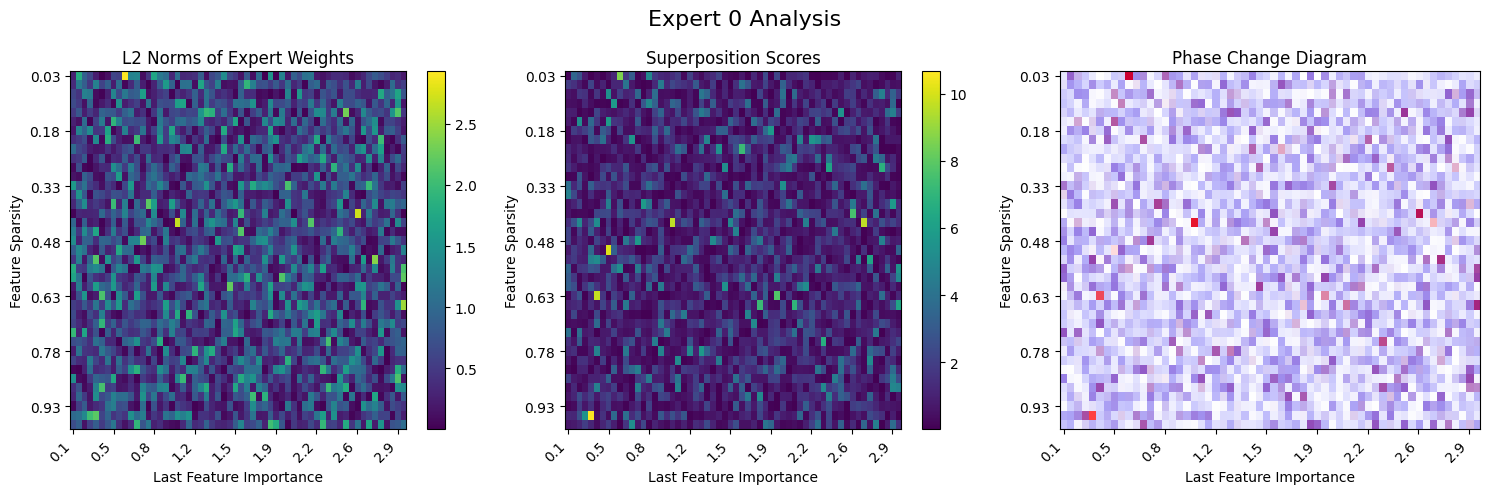

Analyzing 1 experts for feature 1


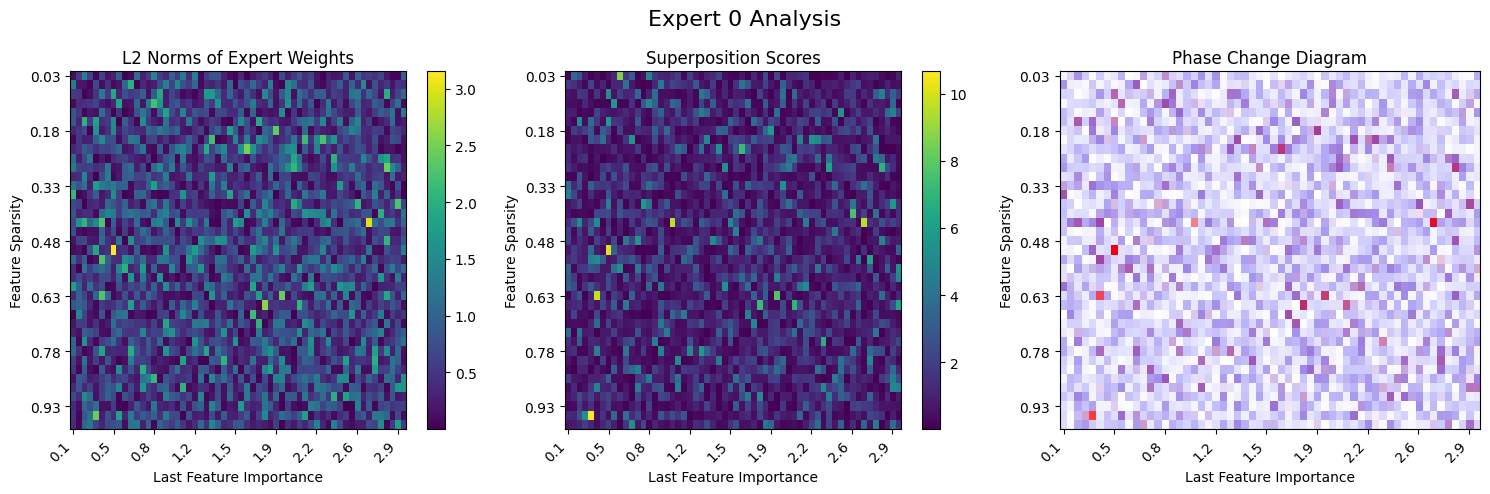

Grid results saved to: phase_change_results_1/211.npz
Grid size: 39 x 58 = 2262 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata


In [57]:
run_phase_change(2,1,1, "211")

Creating grid with 39 sparsity values and 58 importance values
Total grid points: 2262
Training 10 independent runs...


Training run 1/10...


Step 0: avg_loss=0.429067, lr=0.001000


Step 1250: avg_loss=0.090726, lr=0.001000


Step 2500: avg_loss=0.076682, lr=0.001000


Step 3750: avg_loss=0.074211, lr=0.001000


Step 4999: avg_loss=0.073967, lr=0.001000
Training run 2/10...


Step 0: avg_loss=0.450383, lr=0.001000


Step 4999: avg_loss=0.073369, lr=0.001000
Training run 3/10...


Step 0: avg_loss=0.425025, lr=0.001000


Step 4999: avg_loss=0.073502, lr=0.001000
Training run 4/10...


Step 0: avg_loss=0.457191, lr=0.001000


Step 4999: avg_loss=0.072933, lr=0.001000
Training run 5/10...


Step 0: avg_loss=0.463507, lr=0.001000


Step 4999: avg_loss=0.071515, lr=0.001000
Training run 6/10...


Step 0: avg_loss=0.481098, lr=0.001000


Step 4999: avg_loss=0.073352, lr=0.001000
Training run 7/10...


Step 0: avg_loss=0.466753, lr=0.001000


Step 4999: avg_loss=0.073031, lr=0.001000
Training run 8/10...


Step 0: avg_loss=0.450235, lr=0.001000


Step 4999: avg_loss=0.072671, lr=0.001000
Training run 9/10...


Step 0: avg_loss=0.442398, lr=0.001000


Step 4999: avg_loss=0.072561, lr=0.001000
Training run 10/10...


Step 0: avg_loss=0.417609, lr=0.001000


Step 4999: avg_loss=0.072517, lr=0.001000
Selecting best models per grid cell...
  Debug Cell 0/5 (0.03, 0.1): best loss 0.012956 (run 4)
  Debug Cell 1/5 (0.03, 0.2): best loss 0.014055 (run 1)
  Debug Cell 2/5 (0.03, 0.2): best loss 0.014894 (run 8)
  Debug Cell 3/5 (0.03, 0.3): best loss 0.016721 (run 1)
  Debug Cell 4/5 (0.03, 0.3): best loss 0.016654 (run 7)
Training completed in 5822.22 seconds
Total models trained: 22620
Analyzing expert allocations for all grid points...


Analyzing 2 experts for feature 0


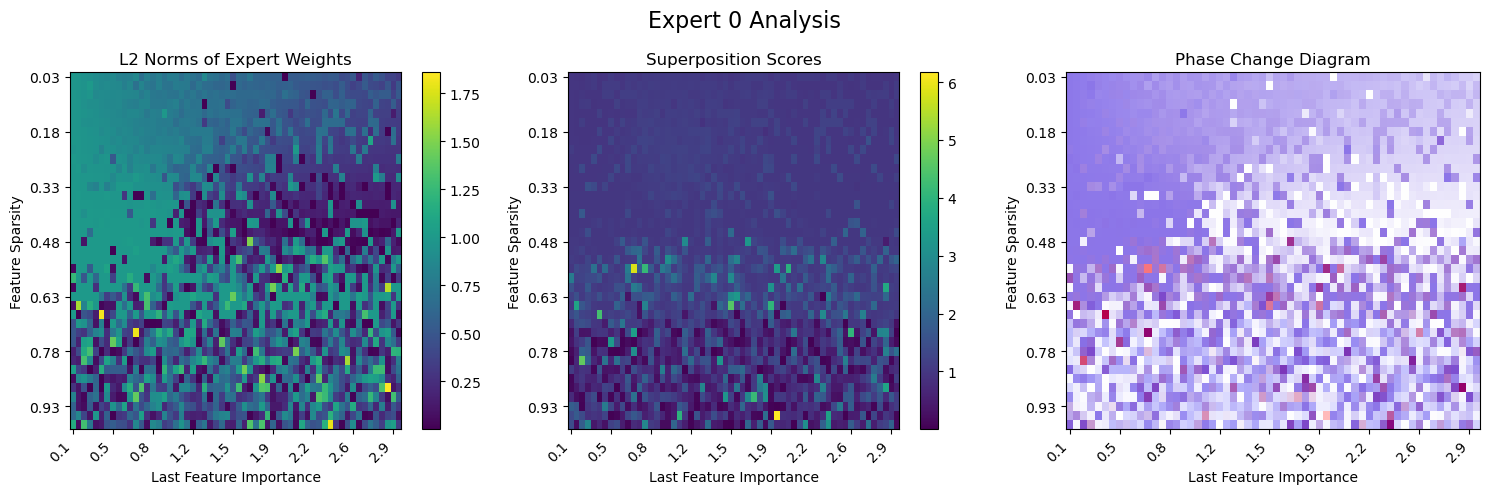

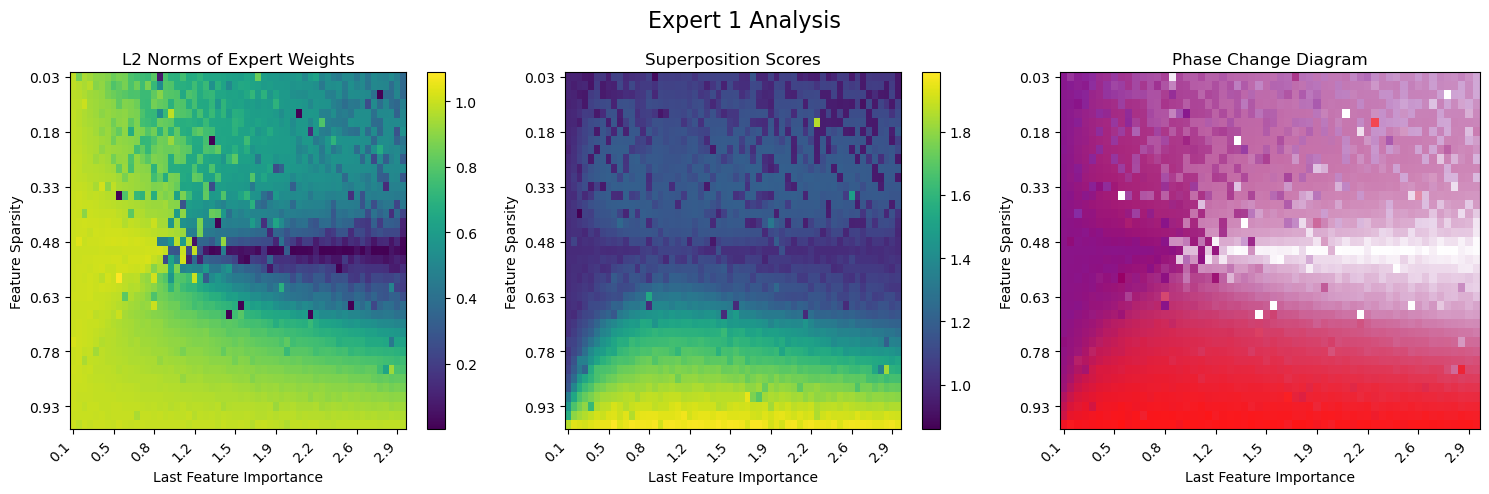

Analyzing 2 experts for feature 1


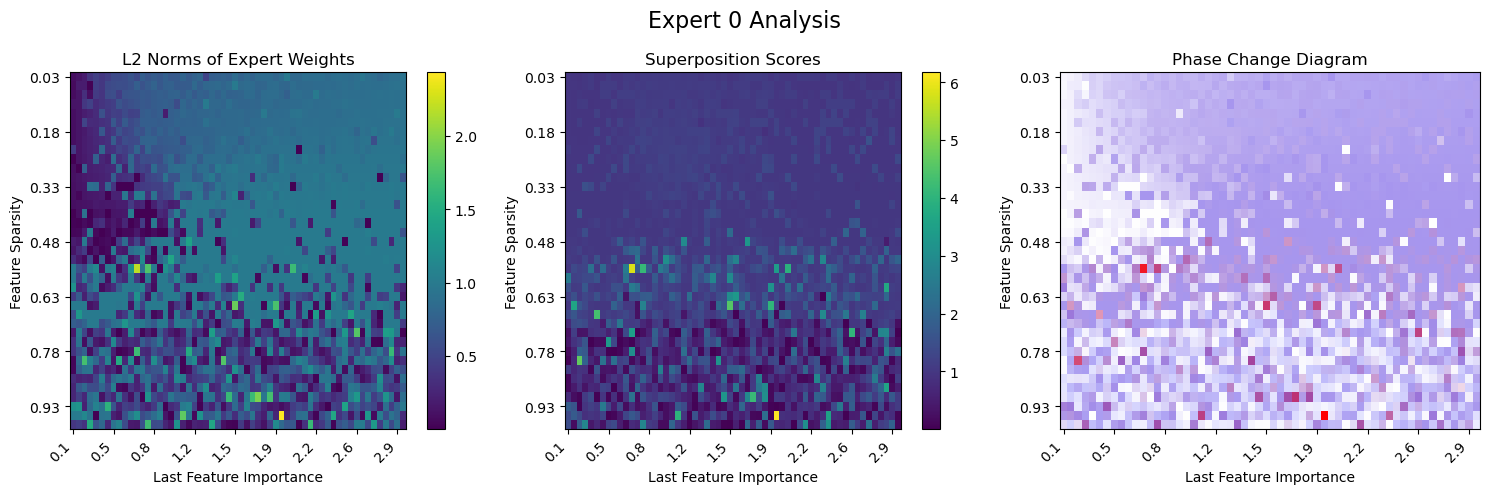

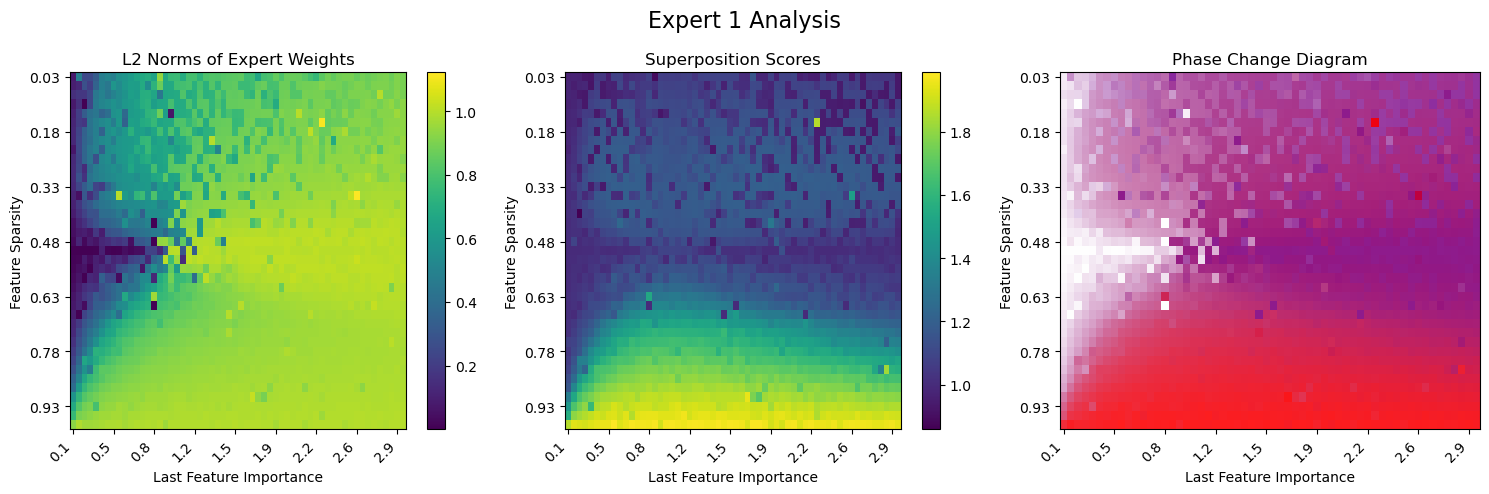

Grid results saved to: phase_change_results/212.npz
Grid size: 39 x 58 = 2262 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata
=== Running Complete Simulation Analysis ===
Simulating 5000 samples per grid cell
Simulating expert activation with 5000 samples for 2 experts
Grid size: 39 x 58 = 2262 cells


Completed simulation for 2262 grid cells

--- Analyzing Expert 0 ---
Analyzing simulation results for expert 0


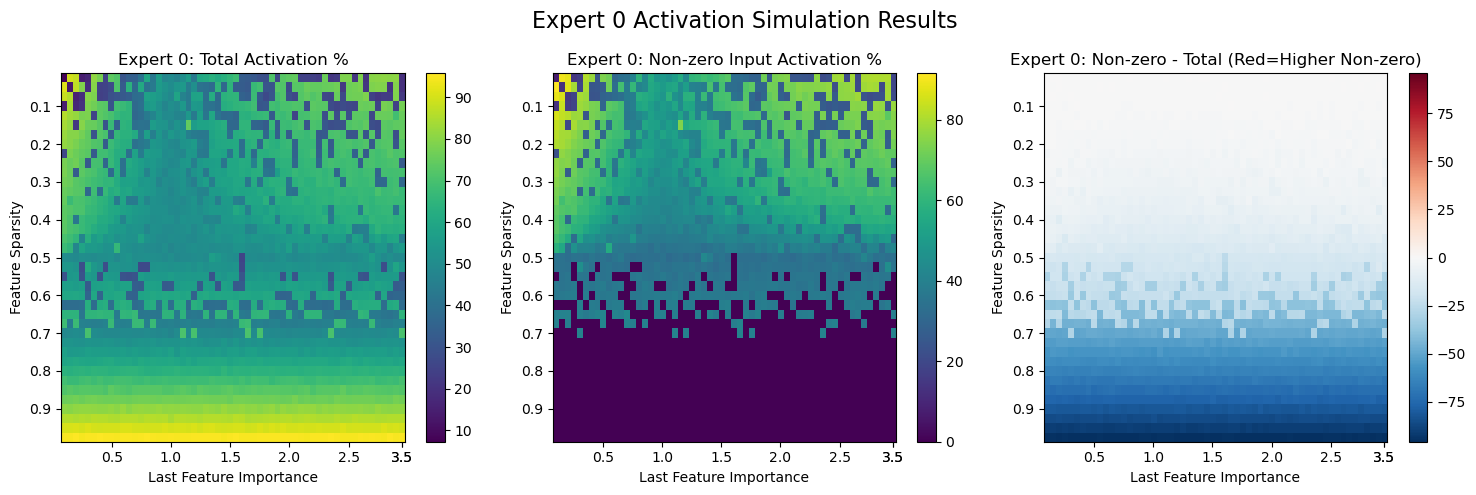


=== Expert 0 Simulation Summary ===
Total activation: 59.88% ± 15.66%
Non-zero input activation: 30.60% ± 26.47%
Difference (Non-zero - Total): -29.28%
  → Expert 0 is activated LESS often for non-zero inputs than overall

--- Analyzing Expert 1 ---
Analyzing simulation results for expert 1


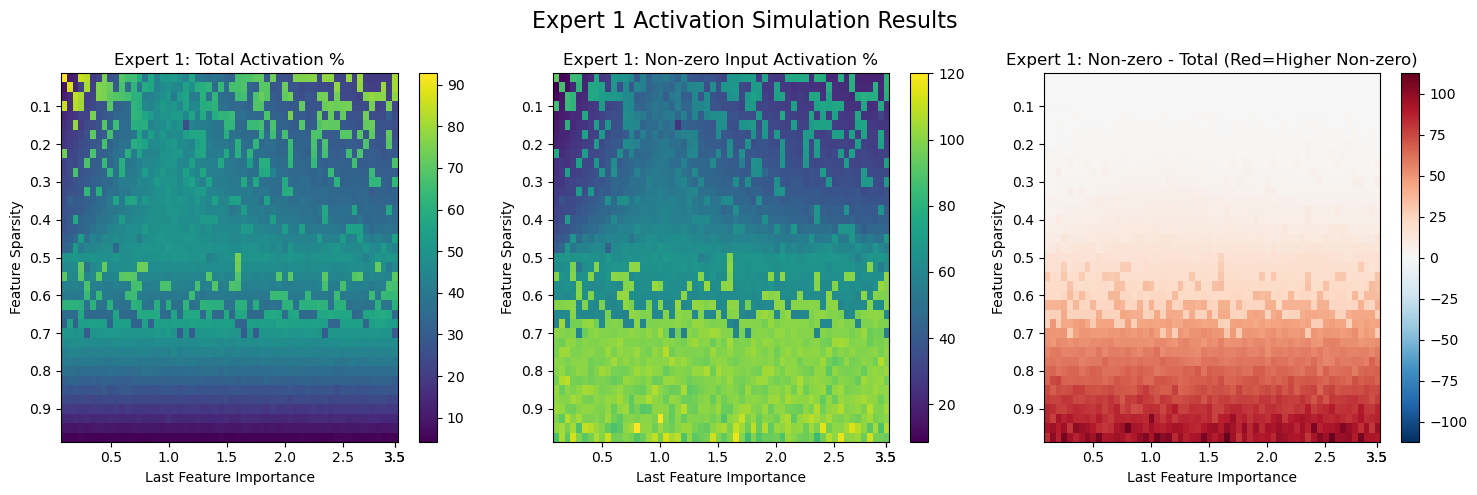


=== Expert 1 Simulation Summary ===
Total activation: 40.12% ± 15.66%
Non-zero input activation: 69.37% ± 26.52%
Difference (Non-zero - Total): 29.25%
  → Expert 1 is activated MORE often for non-zero inputs than overall

--- Overall Analysis ---
Analyzing simulation results for all 2 experts


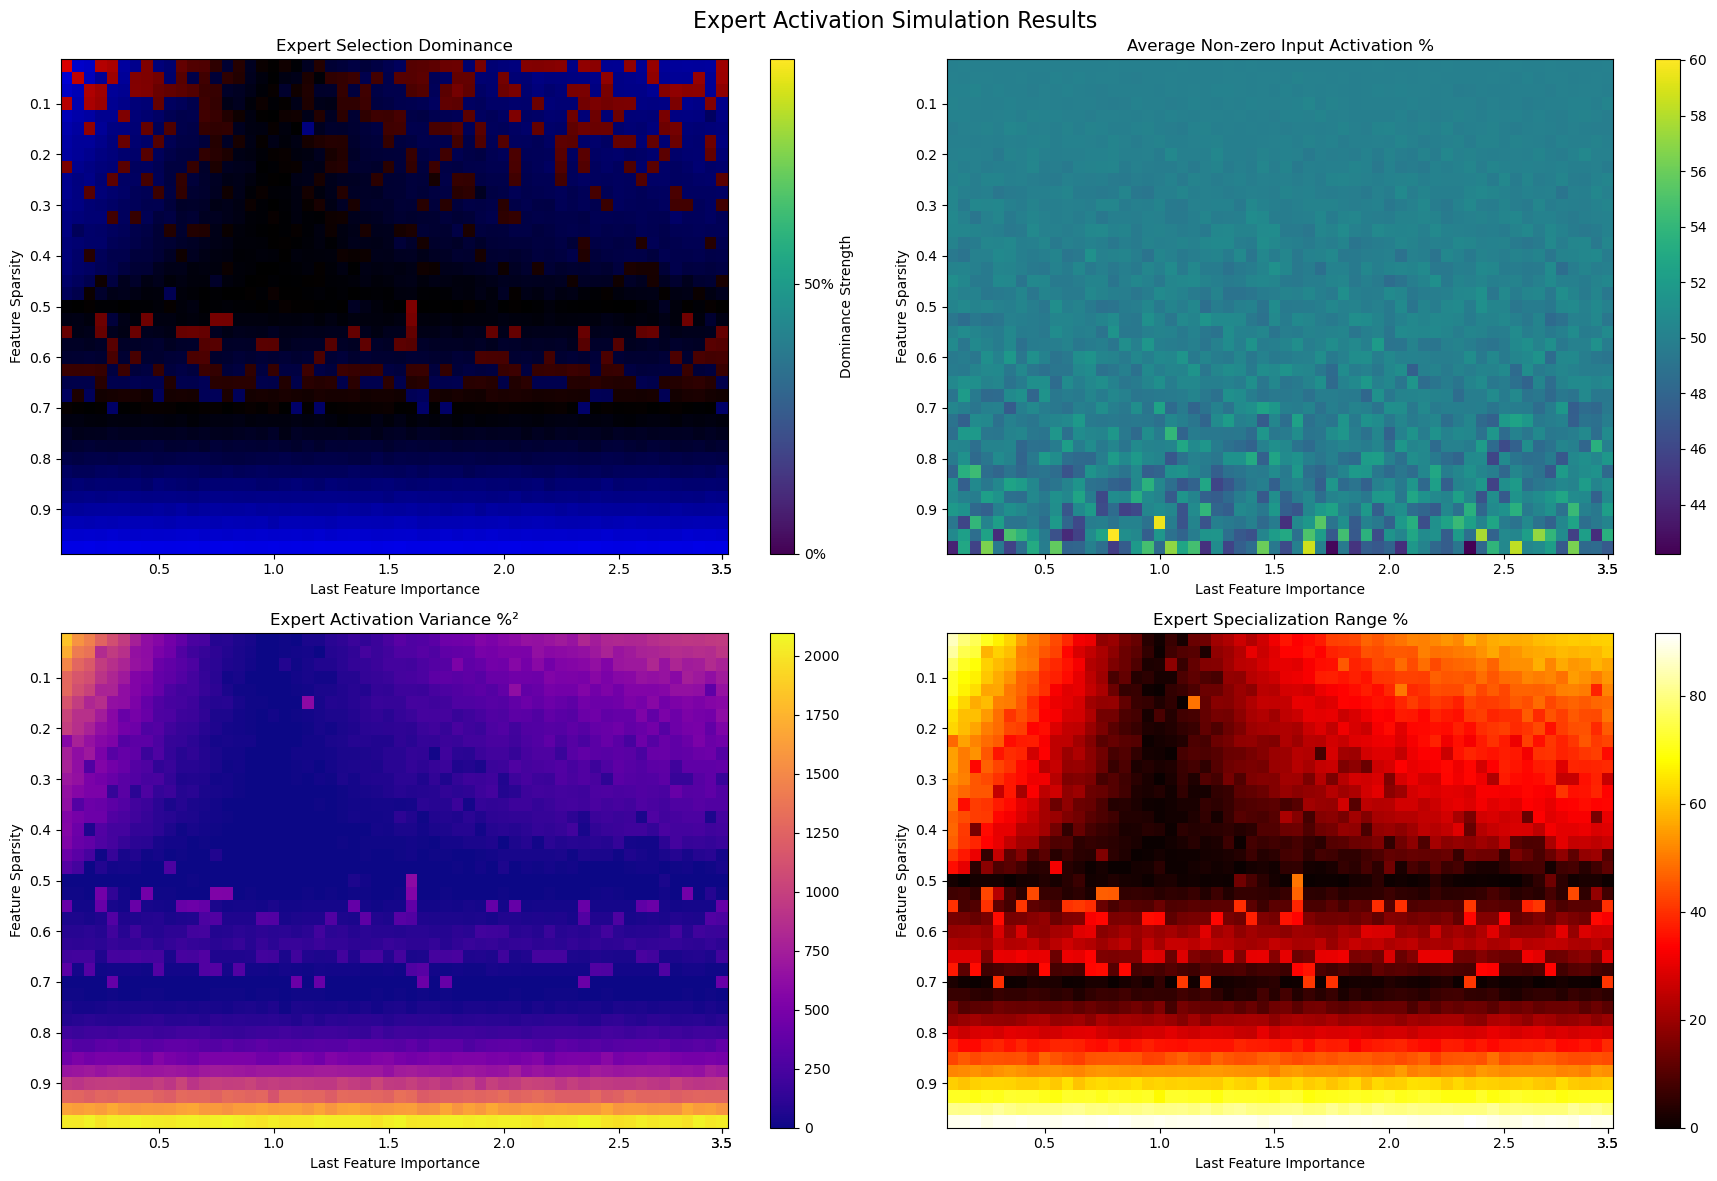


=== Simulation Results Summary ===

Expert 0:
  Total activation: 59.88% ± 15.66%
  Non-zero input activation: 30.60% ± 26.47%
  Difference (Non-zero - Total): -29.28%

Expert 1:
  Total activation: 40.12% ± 15.66%
  Non-zero input activation: 69.37% ± 26.52%
  Difference (Non-zero - Total): 29.25%


In [ ]:
run_phase_change(2,1,2, "212")

Creating grid with 39 sparsity values and 58 importance values
Total grid points: 2262
Training 10 independent runs...


Training run 1/10...


Step 0: avg_loss=0.434449, lr=0.001000


Step 1250: avg_loss=0.100307, lr=0.001000


Step 2500: avg_loss=0.087638, lr=0.001000


Step 3750: avg_loss=0.085611, lr=0.001000


Step 4999: avg_loss=0.084984, lr=0.001000
Training run 2/10...


Step 0: avg_loss=0.446757, lr=0.001000


Step 4999: avg_loss=0.087266, lr=0.001000
Training run 3/10...


Step 0: avg_loss=0.441113, lr=0.001000


Step 4999: avg_loss=0.084369, lr=0.001000
Training run 4/10...


Step 0: avg_loss=0.438173, lr=0.001000


Step 4999: avg_loss=0.086732, lr=0.001000
Training run 5/10...


Step 0: avg_loss=0.443808, lr=0.001000


Step 4999: avg_loss=0.084523, lr=0.001000
Training run 6/10...


Step 0: avg_loss=0.456033, lr=0.001000


Step 4999: avg_loss=0.085564, lr=0.001000
Training run 7/10...


Step 0: avg_loss=0.436568, lr=0.001000


Step 4999: avg_loss=0.084654, lr=0.001000
Training run 8/10...


Step 0: avg_loss=0.453370, lr=0.001000


Step 4999: avg_loss=0.086056, lr=0.001000
Training run 9/10...


Step 0: avg_loss=0.427485, lr=0.001000


Step 4999: avg_loss=0.085103, lr=0.001000
Training run 10/10...


Step 0: avg_loss=0.421717, lr=0.001000


Step 4999: avg_loss=0.085409, lr=0.001000
Selecting best models per grid cell...
  Debug Cell 0/5 (0.03, 0.1): best loss 0.040514 (run 6)
  Debug Cell 1/5 (0.03, 0.2): best loss 0.041387 (run 3)
  Debug Cell 2/5 (0.03, 0.2): best loss 0.042882 (run 8)
  Debug Cell 3/5 (0.03, 0.3): best loss 0.046504 (run 9)
  Debug Cell 4/5 (0.03, 0.3): best loss 0.047375 (run 3)


Training completed in 5379.57 seconds
Total models trained: 22620
Analyzing expert allocations for all grid points...


Analyzing 1 experts for feature 0


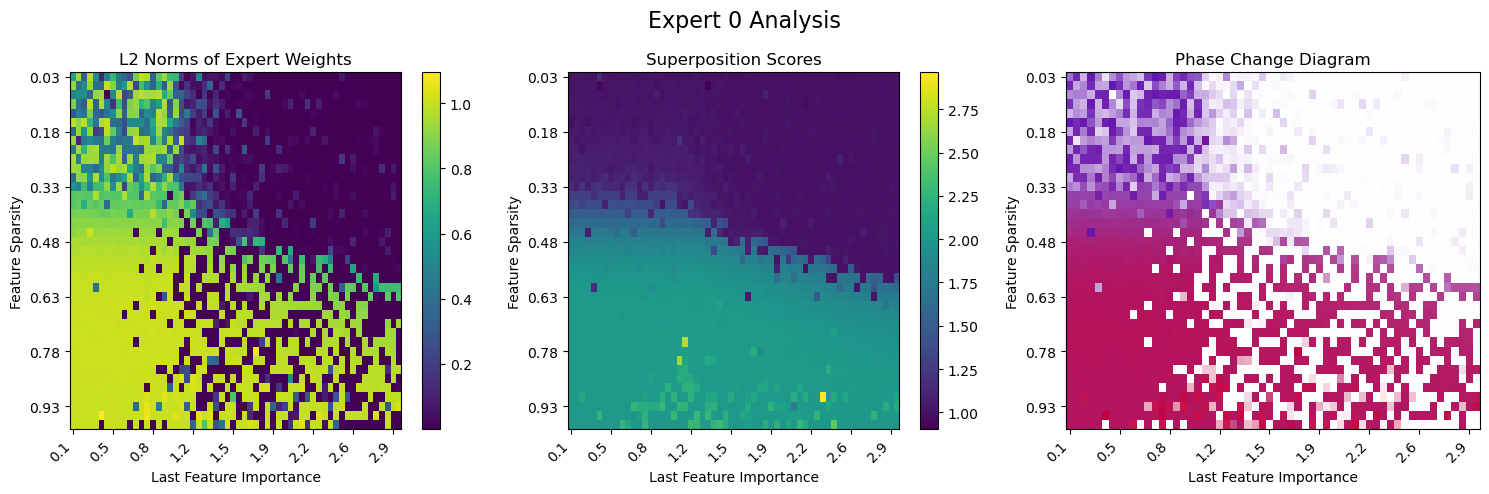

Analyzing 1 experts for feature 1


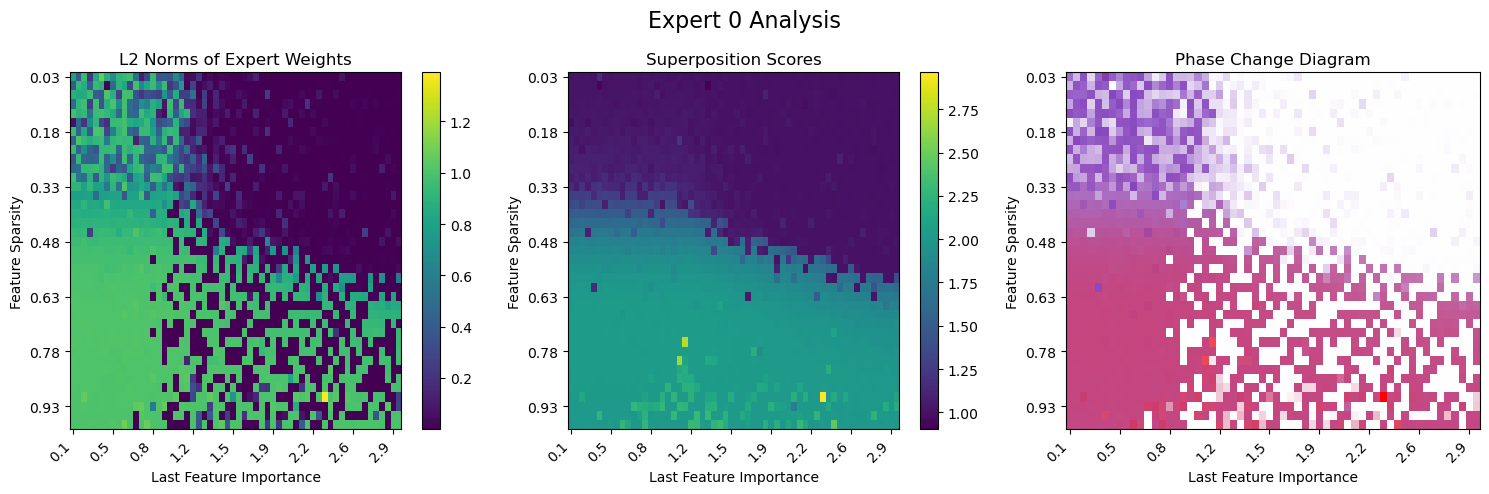

Analyzing 1 experts for feature 2


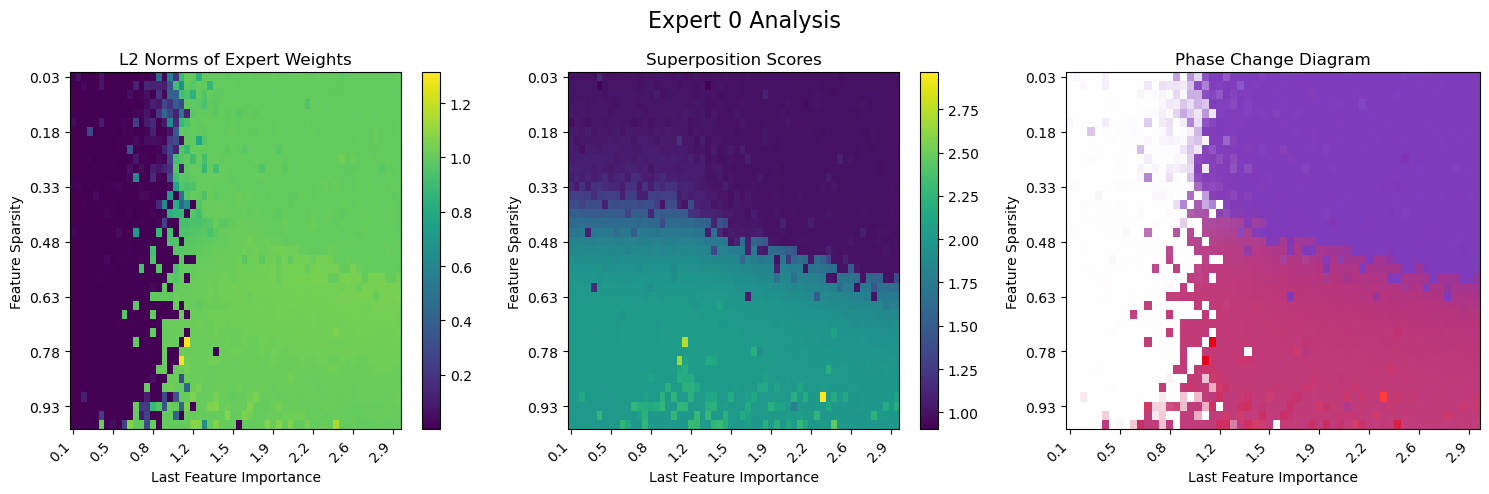

Grid results saved to: phase_change_results/311.npz
Grid size: 39 x 58 = 2262 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata


In [ ]:
run_phase_change(3,1,1, "311")

Creating grid with 39 sparsity values and 58 importance values
Total grid points: 2262
Training 10 independent runs...


Training run 1/10...


Step 0: avg_loss=0.341242, lr=0.001000


Step 1250: avg_loss=0.087591, lr=0.001000


Step 2500: avg_loss=0.078597, lr=0.001000


Step 3750: avg_loss=0.076794, lr=0.001000


Step 4999: avg_loss=0.076479, lr=0.001000
Training run 2/10...


Step 0: avg_loss=0.346316, lr=0.001000


Step 4999: avg_loss=0.075999, lr=0.001000
Training run 3/10...


Step 0: avg_loss=0.338770, lr=0.001000


Step 4999: avg_loss=0.075738, lr=0.001000
Training run 4/10...


Step 0: avg_loss=0.335233, lr=0.001000


Step 4999: avg_loss=0.077665, lr=0.001000
Training run 5/10...


Step 0: avg_loss=0.349669, lr=0.001000


Step 4999: avg_loss=0.075862, lr=0.001000
Training run 6/10...


Step 0: avg_loss=0.350370, lr=0.001000


Step 4999: avg_loss=0.076068, lr=0.001000
Training run 7/10...


Step 0: avg_loss=0.347760, lr=0.001000


Step 4999: avg_loss=0.075135, lr=0.001000
Training run 8/10...


Step 0: avg_loss=0.348706, lr=0.001000


Step 4999: avg_loss=0.076770, lr=0.001000
Training run 9/10...


Step 0: avg_loss=0.335175, lr=0.001000


Step 4999: avg_loss=0.076389, lr=0.001000
Training run 10/10...


Step 0: avg_loss=0.338472, lr=0.001000


Step 4999: avg_loss=0.076546, lr=0.001000
Selecting best models per grid cell...
  Debug Cell 0/5 (0.03, 0.1): best loss 0.027893 (run 6)
  Debug Cell 1/5 (0.03, 0.2): best loss 0.027952 (run 7)
  Debug Cell 2/5 (0.03, 0.2): best loss 0.024994 (run 2)
  Debug Cell 3/5 (0.03, 0.3): best loss 0.028211 (run 8)
  Debug Cell 4/5 (0.03, 0.3): best loss 0.029400 (run 7)


Training completed in 5719.67 seconds
Total models trained: 22620
Analyzing expert allocations for all grid points...


Analyzing 2 experts for feature 0


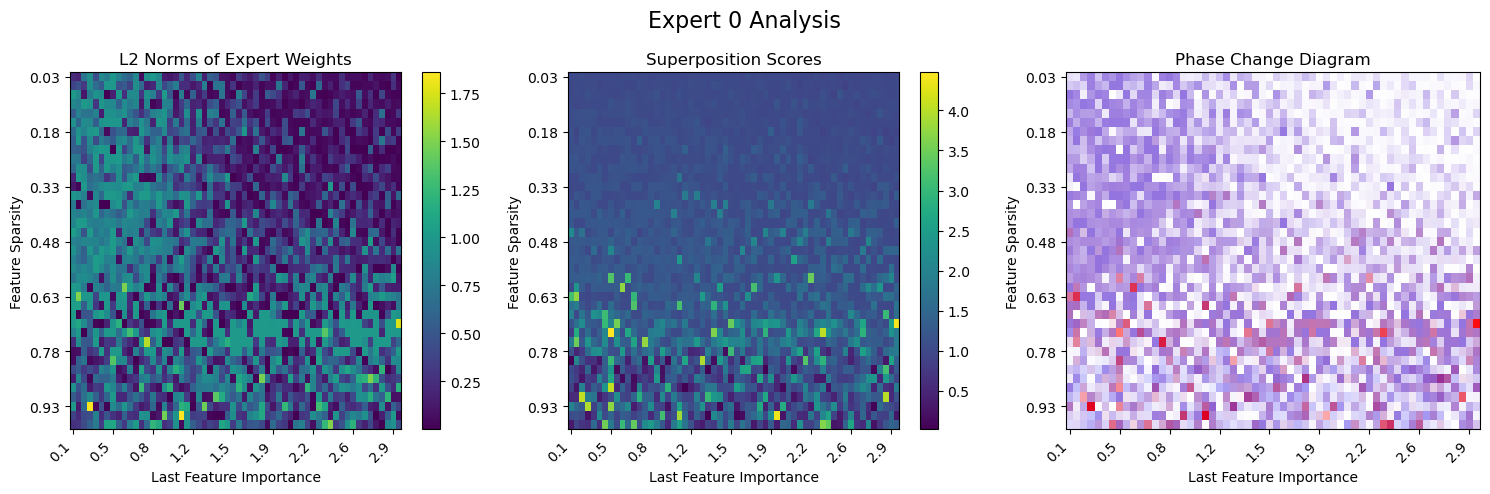

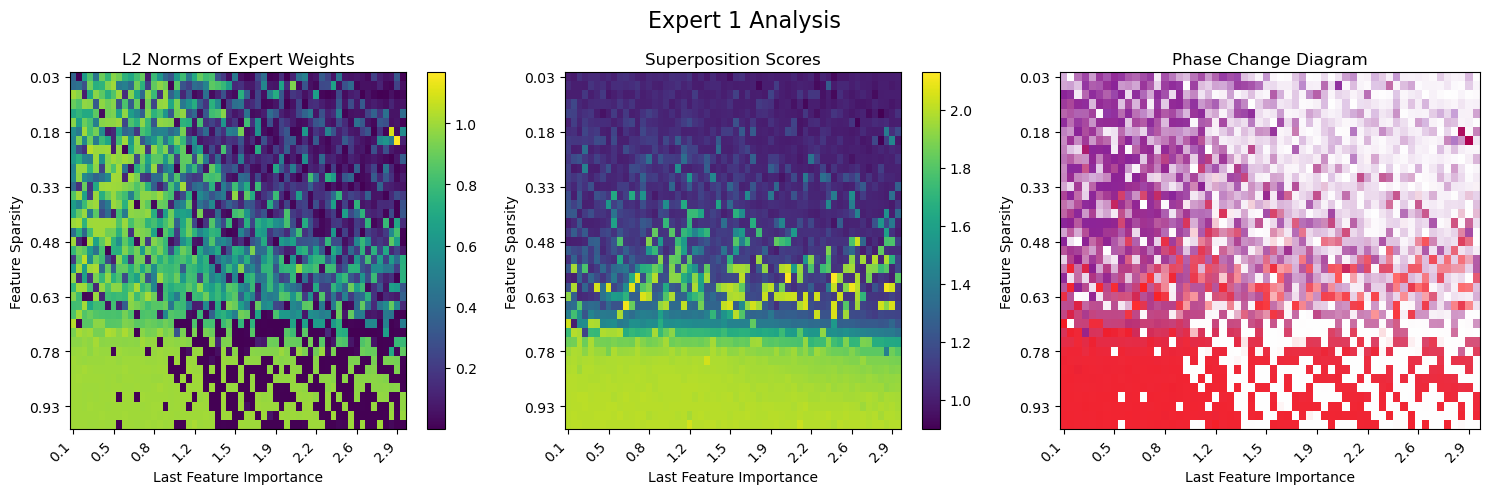

Analyzing 2 experts for feature 1


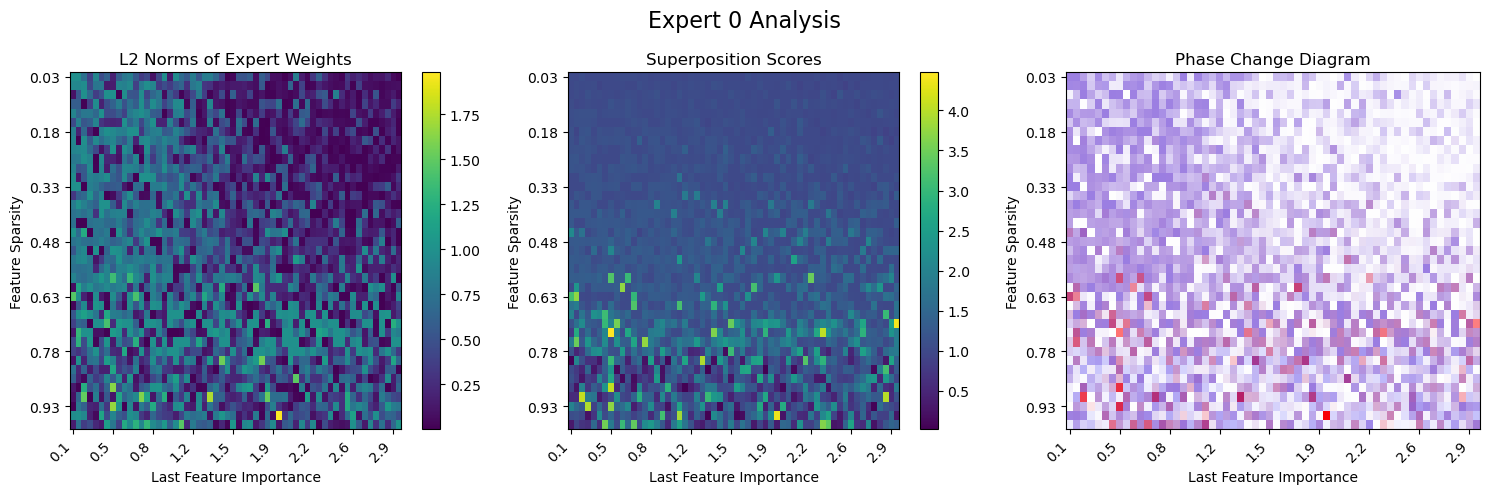

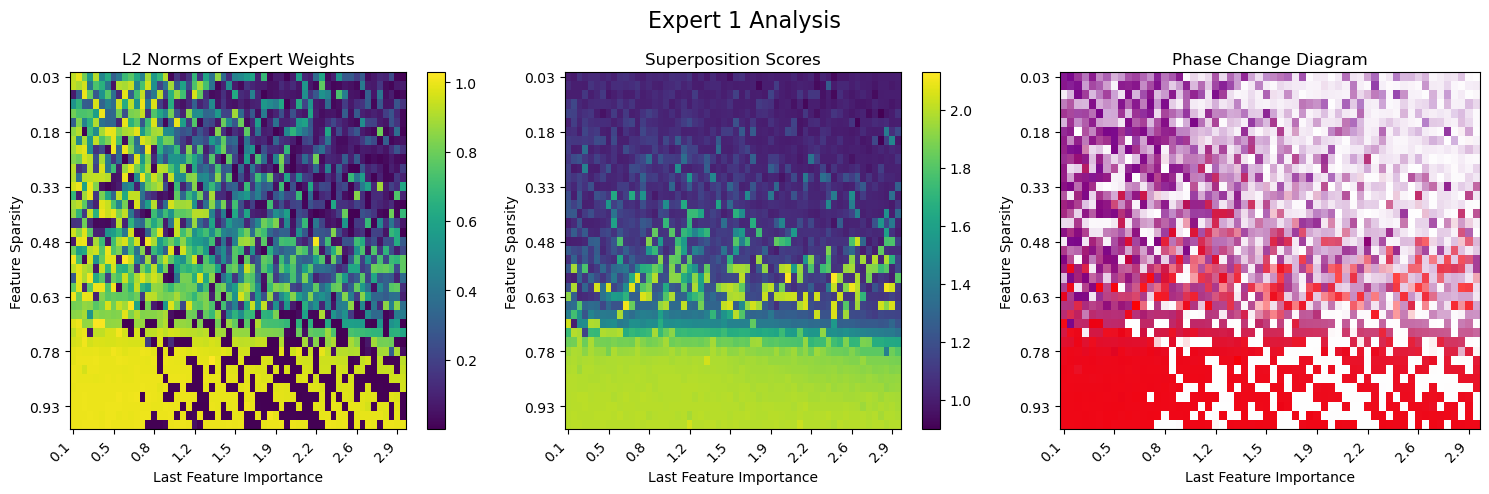

Analyzing 2 experts for feature 2


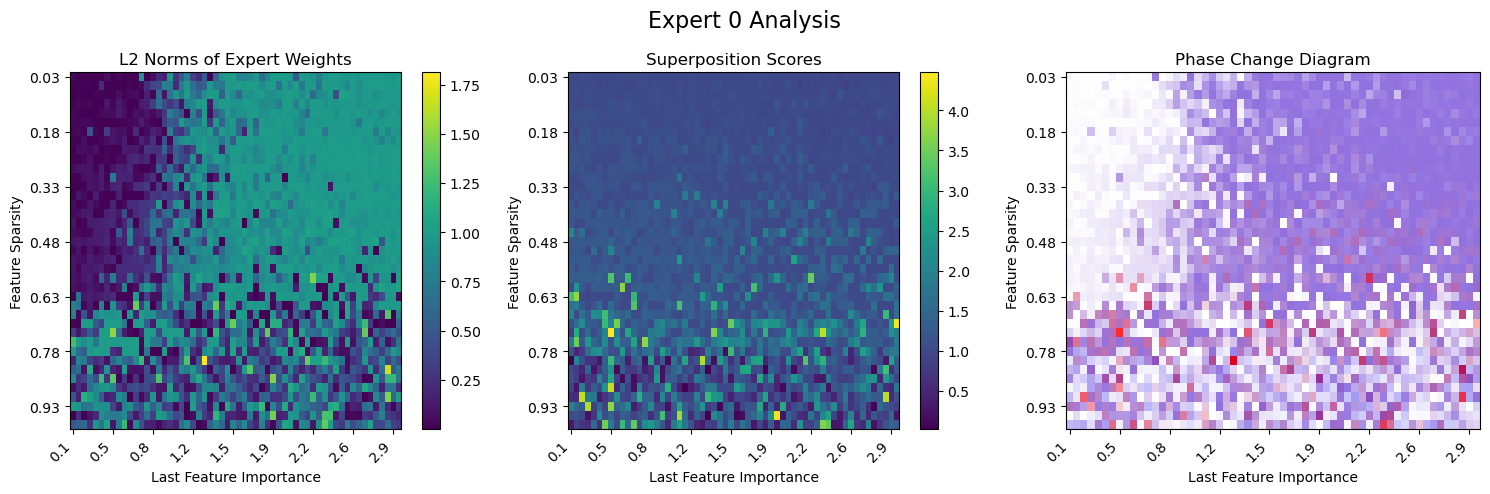

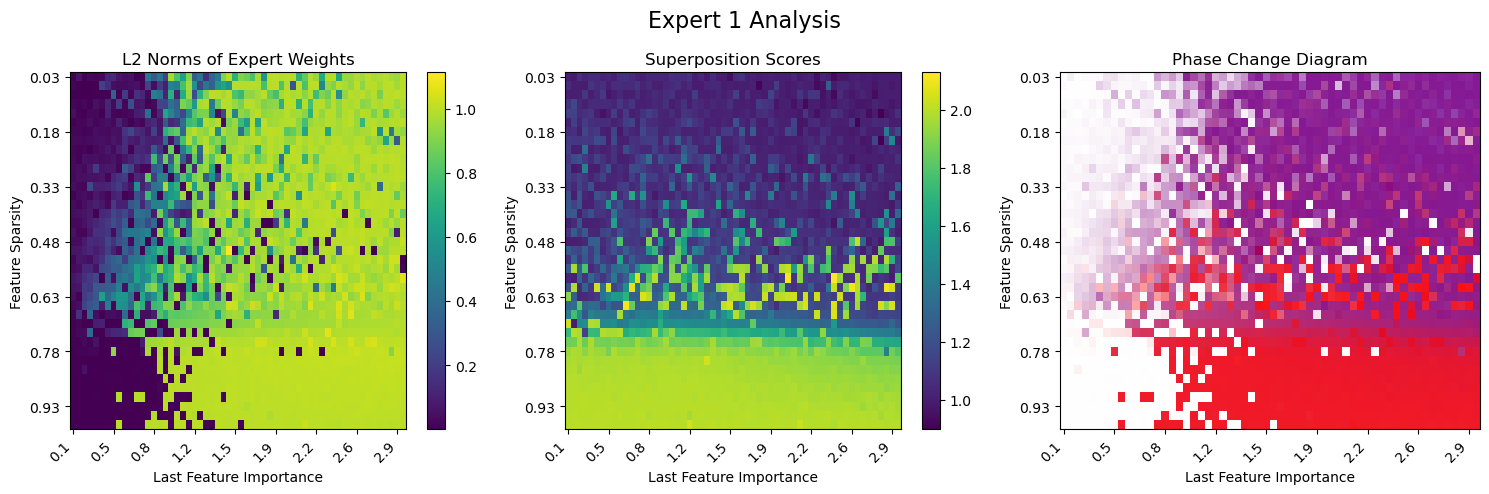

Grid results saved to: phase_change_results/312.npz
Grid size: 39 x 58 = 2262 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata
=== Running Complete Simulation Analysis ===
Simulating 5000 samples per grid cell
Simulating expert activation with 5000 samples for 2 experts
Grid size: 39 x 58 = 2262 cells


Completed simulation for 2262 grid cells

--- Analyzing Expert 0 ---
Analyzing simulation results for expert 0


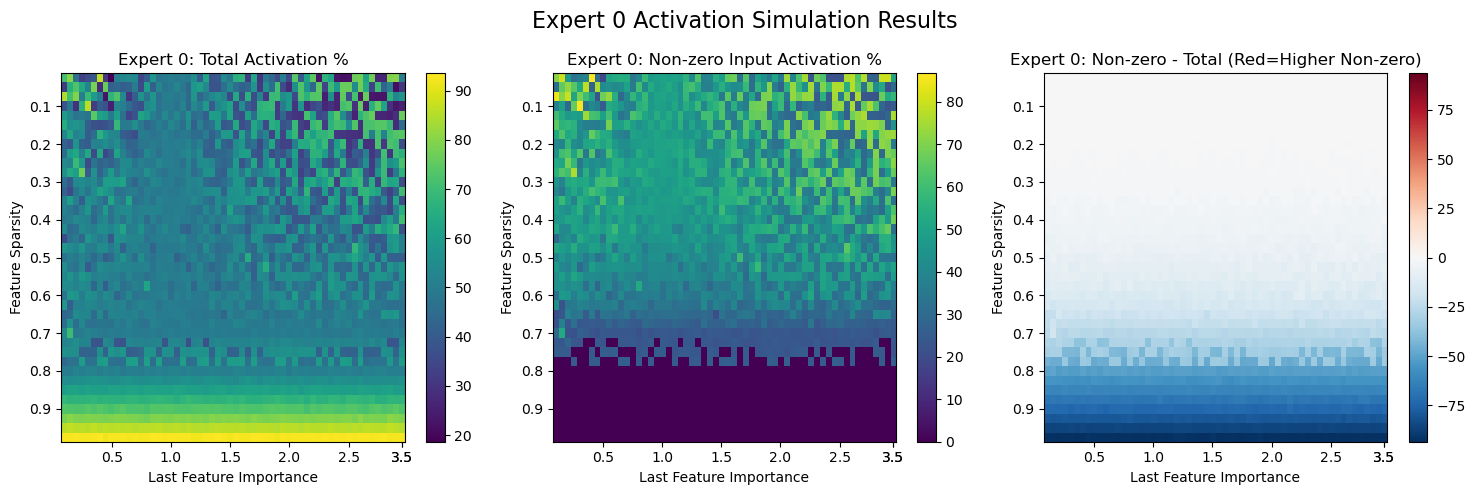


=== Expert 0 Simulation Summary ===
Total activation: 54.80% ± 13.24%
Non-zero input activation: 33.32% ± 21.66%
Difference (Non-zero - Total): -21.48%
  → Expert 0 is activated LESS often for non-zero inputs than overall

--- Analyzing Expert 1 ---
Analyzing simulation results for expert 1


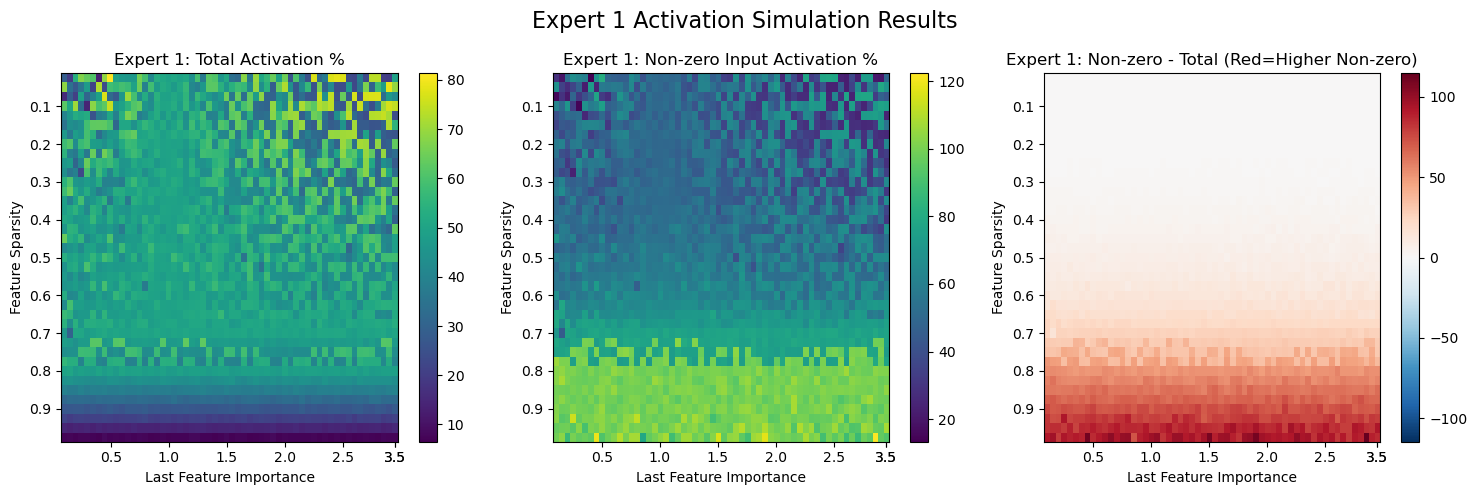


=== Expert 1 Simulation Summary ===
Total activation: 45.20% ± 13.24%
Non-zero input activation: 66.70% ± 21.78%
Difference (Non-zero - Total): 21.50%
  → Expert 1 is activated MORE often for non-zero inputs than overall

--- Overall Analysis ---
Analyzing simulation results for all 2 experts


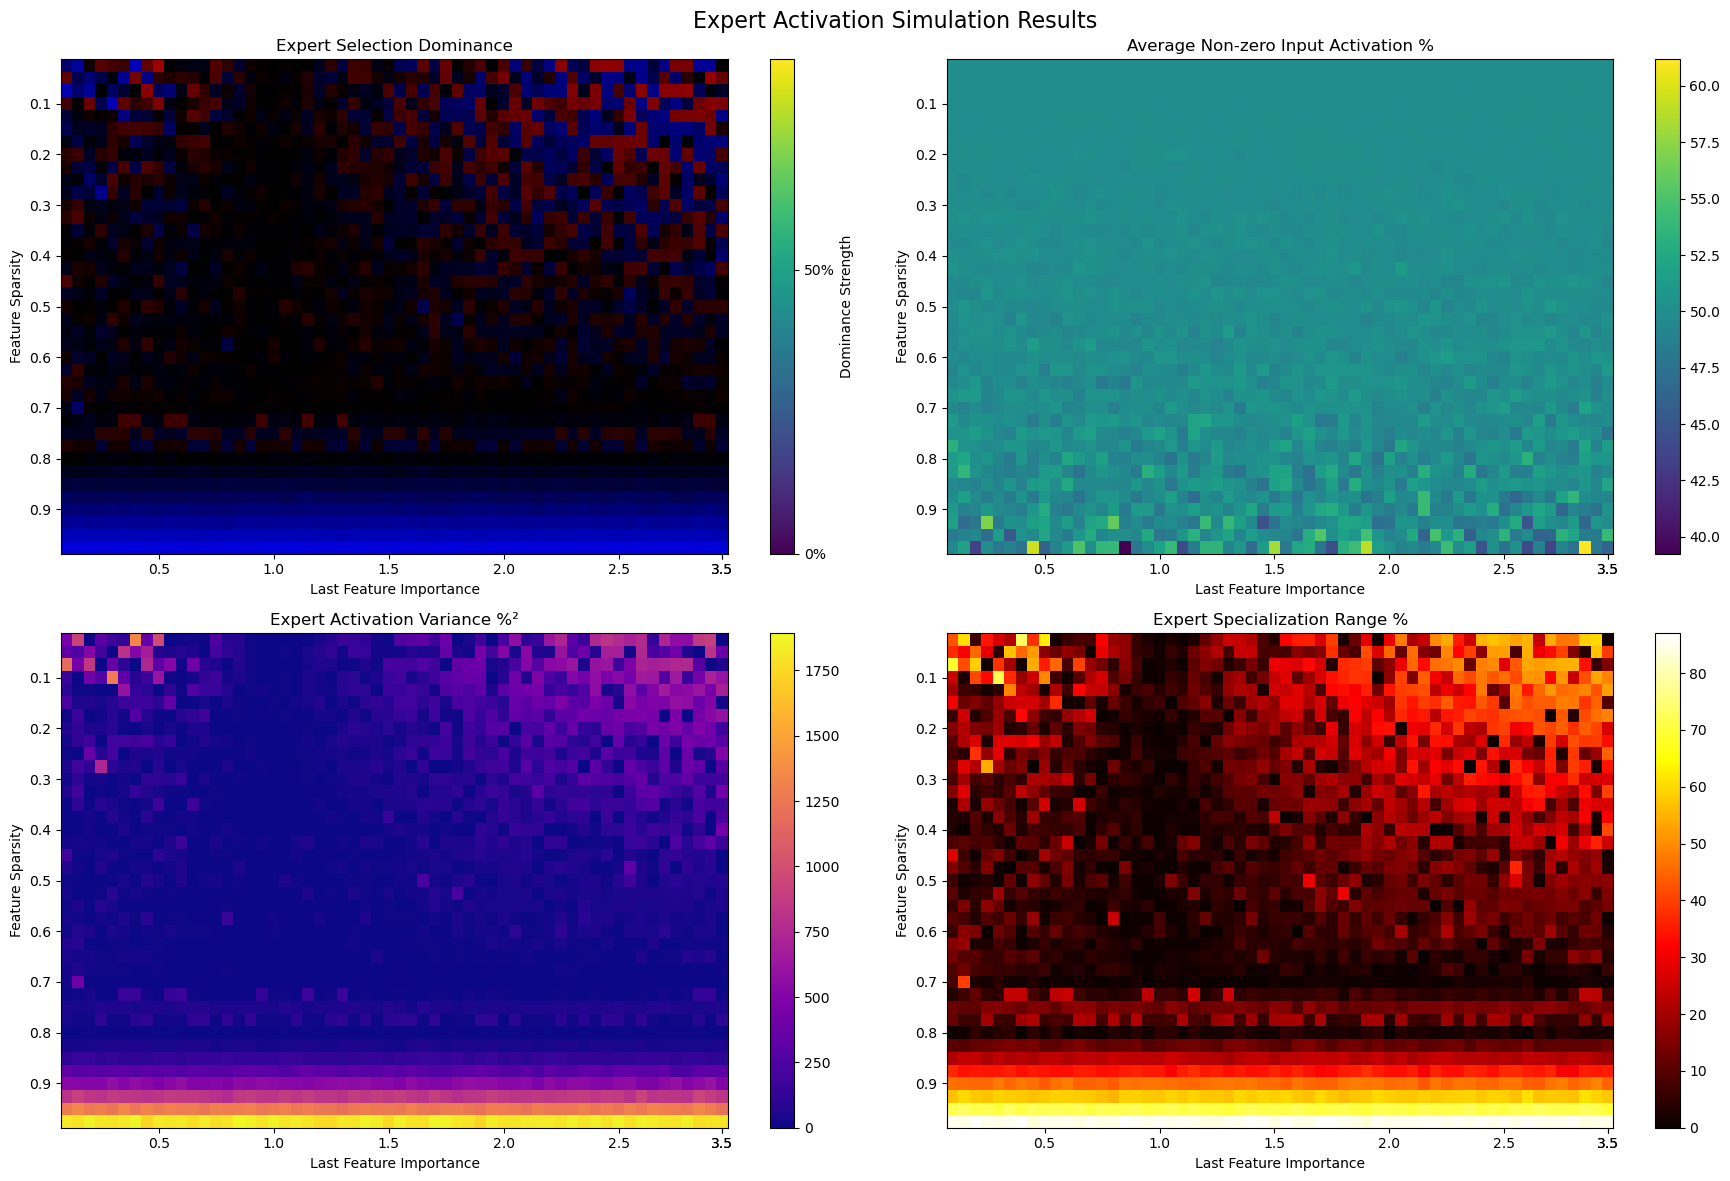


=== Simulation Results Summary ===

Expert 0:
  Total activation: 54.80% ± 13.24%
  Non-zero input activation: 33.32% ± 21.66%
  Difference (Non-zero - Total): -21.48%

Expert 1:
  Total activation: 45.20% ± 13.24%
  Non-zero input activation: 66.70% ± 21.78%
  Difference (Non-zero - Total): 21.50%


In [ ]:
run_phase_change(3,1,2, "312")

Creating grid with 39 sparsity values and 58 importance values
Total grid points: 2262
Training 10 independent runs...


Training run 1/10...


Step 0: avg_loss=0.295422, lr=0.001000


Step 1250: avg_loss=0.080783, lr=0.001000


Step 2500: avg_loss=0.074157, lr=0.001000


Step 3750: avg_loss=0.072894, lr=0.001000


Step 4999: avg_loss=0.072841, lr=0.001000
Training run 2/10...


Step 0: avg_loss=0.294733, lr=0.001000


Step 4999: avg_loss=0.071477, lr=0.001000
Training run 3/10...


Step 0: avg_loss=0.289374, lr=0.001000


Step 4999: avg_loss=0.071795, lr=0.001000
Training run 4/10...


Step 0: avg_loss=0.290430, lr=0.001000


Step 4999: avg_loss=0.073174, lr=0.001000
Training run 5/10...


Step 0: avg_loss=0.295032, lr=0.001000


Step 4999: avg_loss=0.071036, lr=0.001000
Training run 6/10...


Step 0: avg_loss=0.290685, lr=0.001000


Step 4999: avg_loss=0.071038, lr=0.001000
Training run 7/10...


Step 0: avg_loss=0.294135, lr=0.001000


Step 4999: avg_loss=0.071118, lr=0.001000
Training run 8/10...


Step 0: avg_loss=0.295527, lr=0.001000


Step 4999: avg_loss=0.074030, lr=0.001000
Training run 9/10...


Step 0: avg_loss=0.287660, lr=0.001000


Step 4999: avg_loss=0.072077, lr=0.001000
Training run 10/10...


Step 0: avg_loss=0.285542, lr=0.001000


Step 4999: avg_loss=0.072712, lr=0.001000
Selecting best models per grid cell...
  Debug Cell 0/5 (0.03, 0.1): best loss 0.023204 (run 4)
  Debug Cell 1/5 (0.03, 0.2): best loss 0.026472 (run 7)
  Debug Cell 2/5 (0.03, 0.2): best loss 0.048155 (run 5)
  Debug Cell 3/5 (0.03, 0.3): best loss 0.025388 (run 6)
  Debug Cell 4/5 (0.03, 0.3): best loss 0.024087 (run 10)


Training completed in 5829.21 seconds
Total models trained: 22620
Analyzing expert allocations for all grid points...


Analyzing 3 experts for feature 0


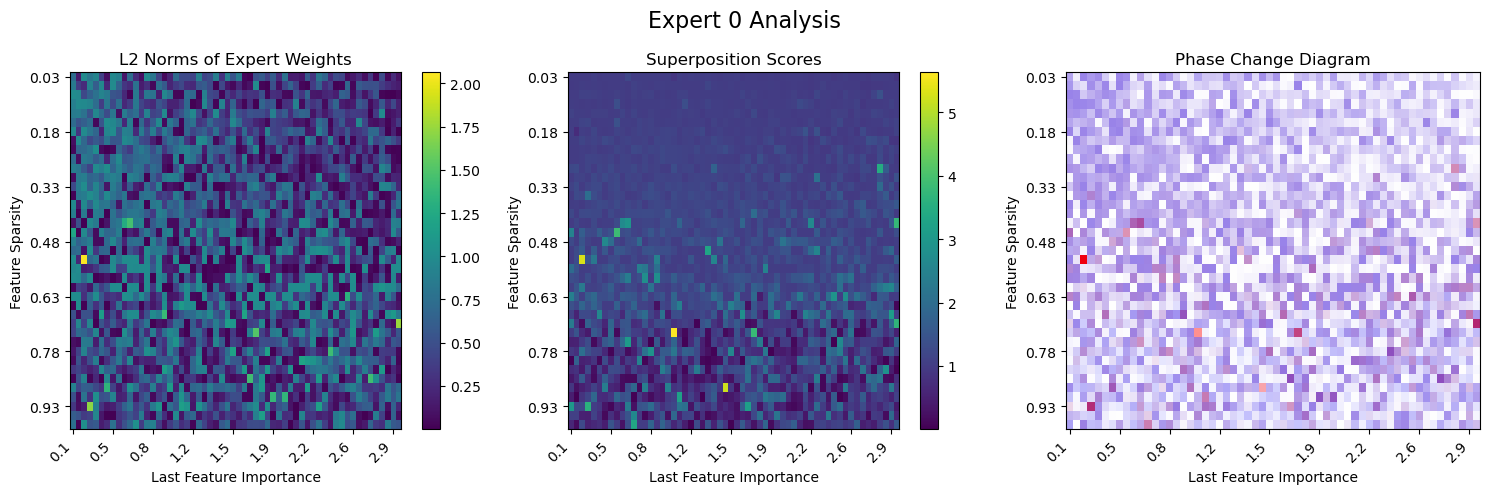

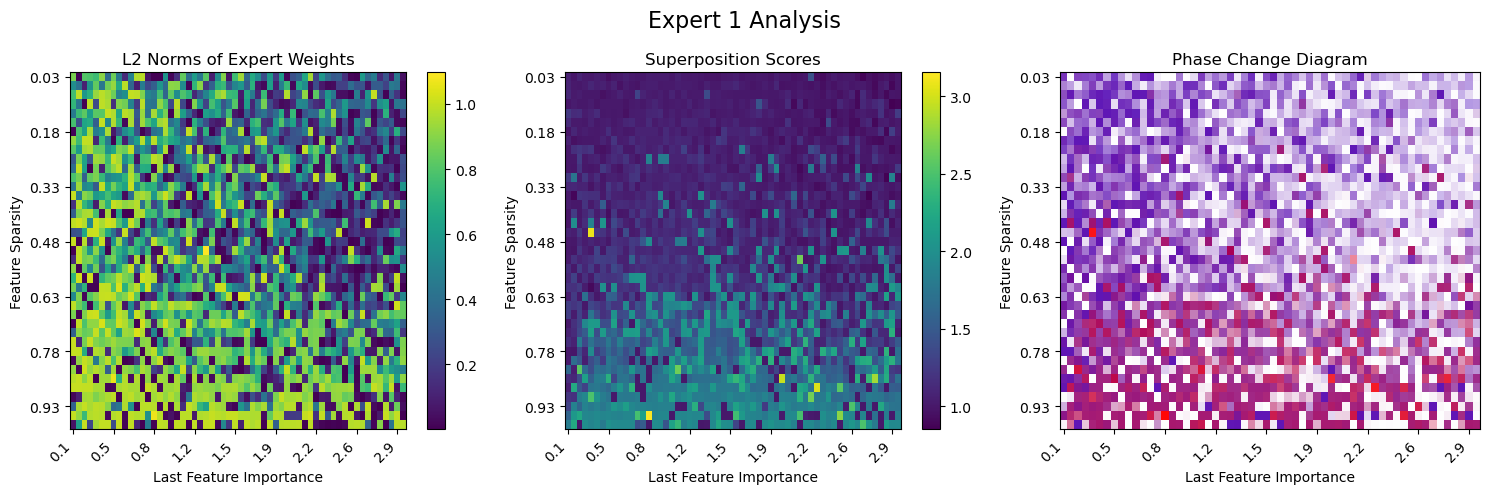

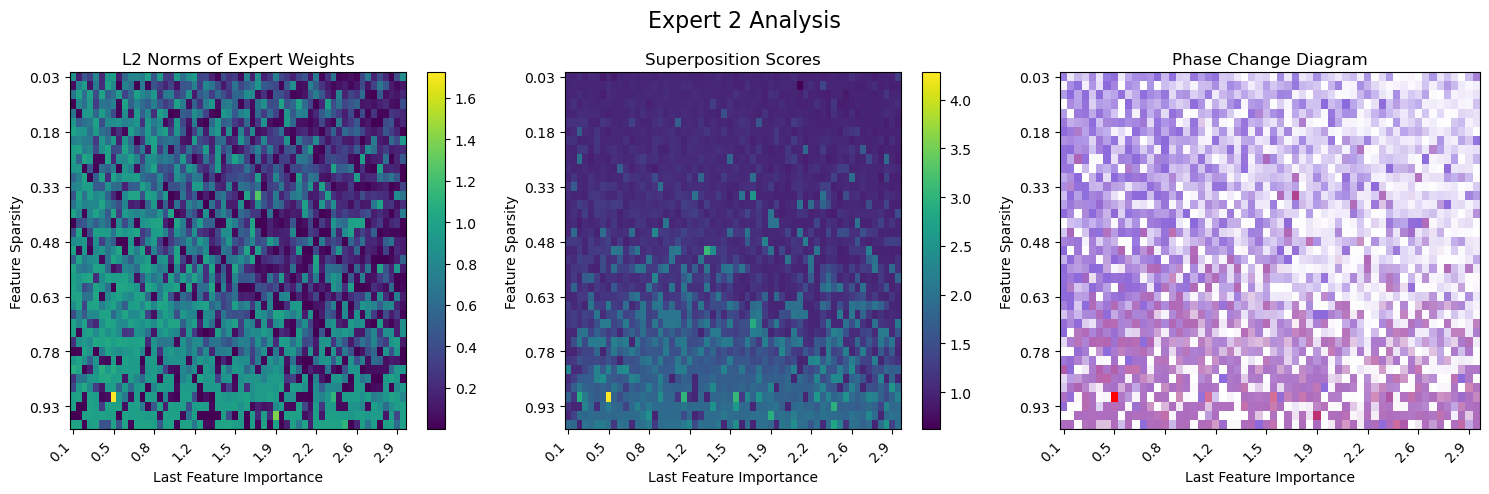

Analyzing 3 experts for feature 1


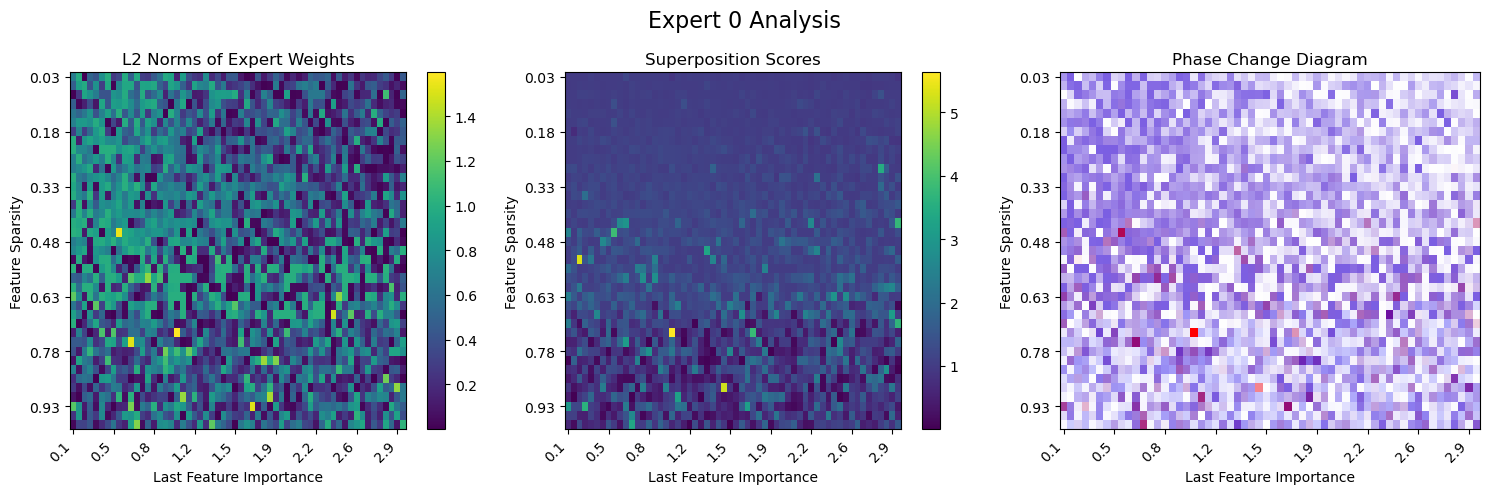

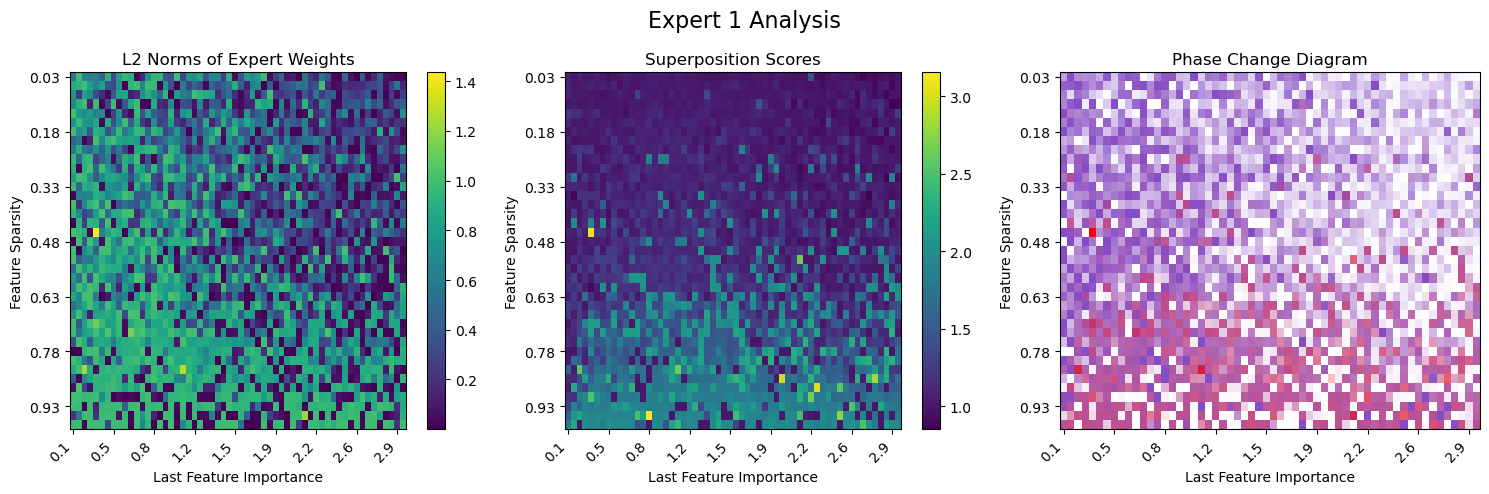

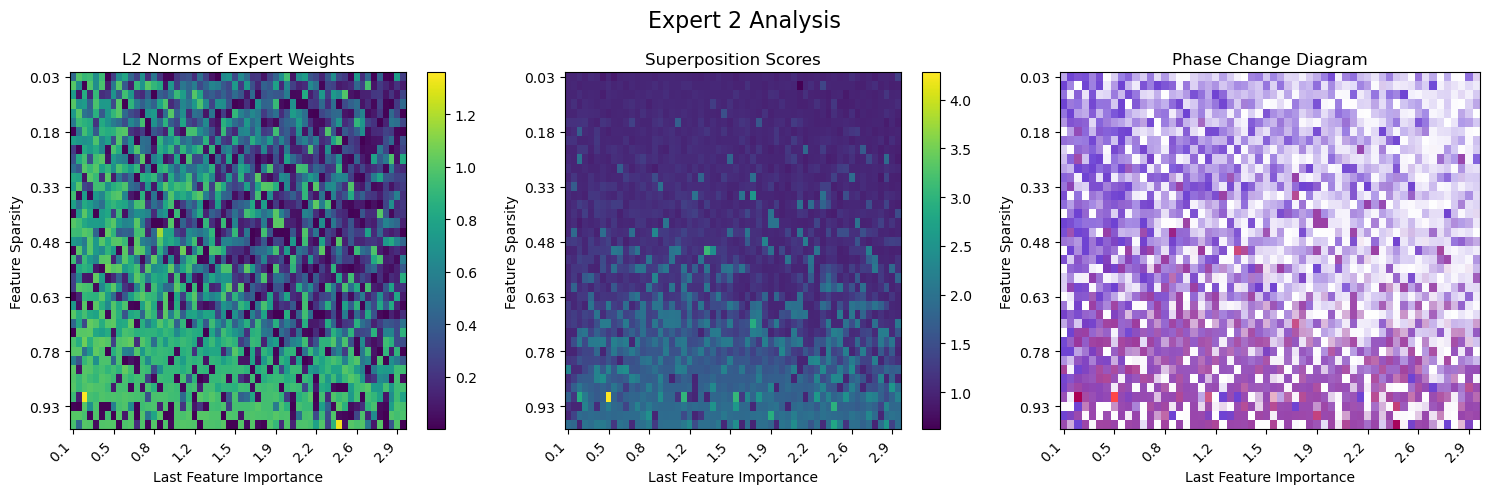

Analyzing 3 experts for feature 2


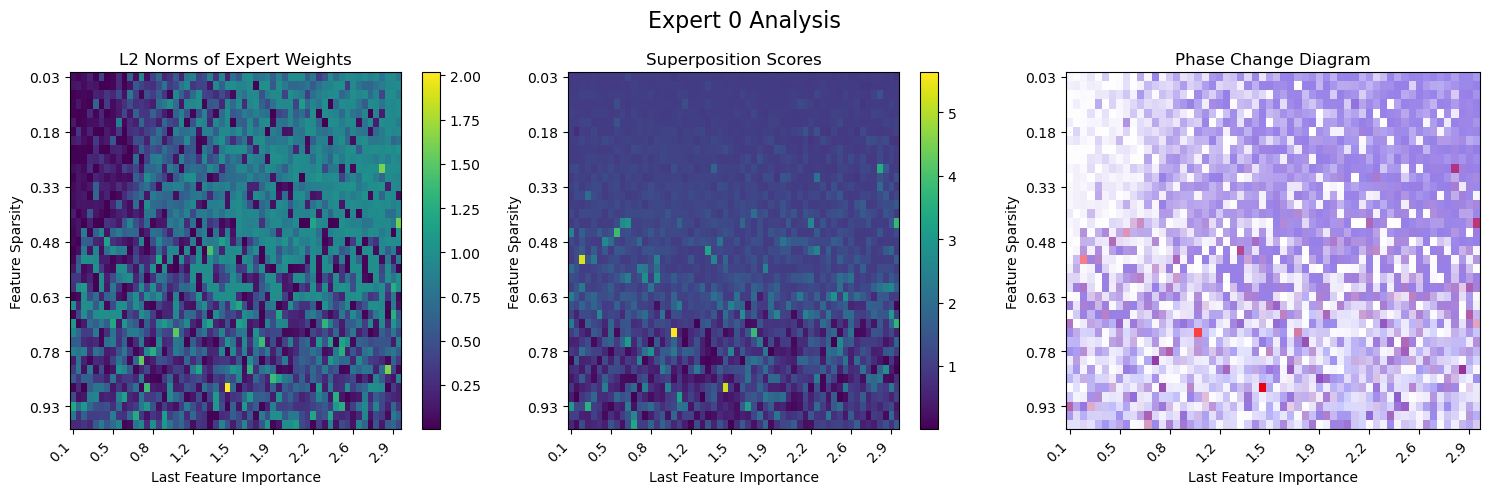

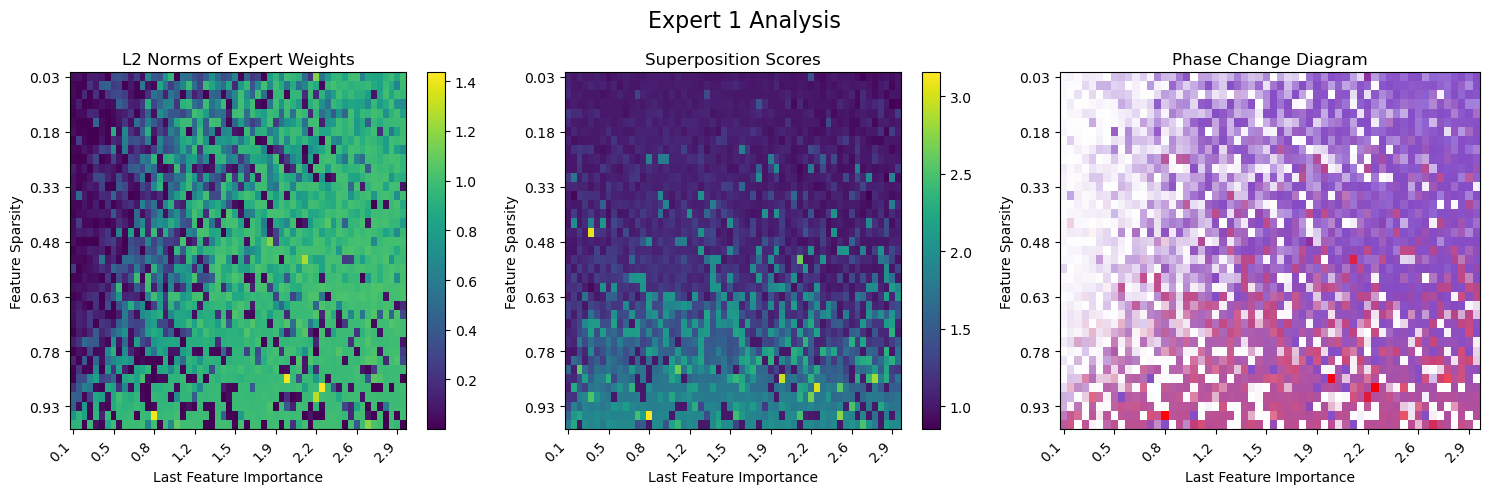

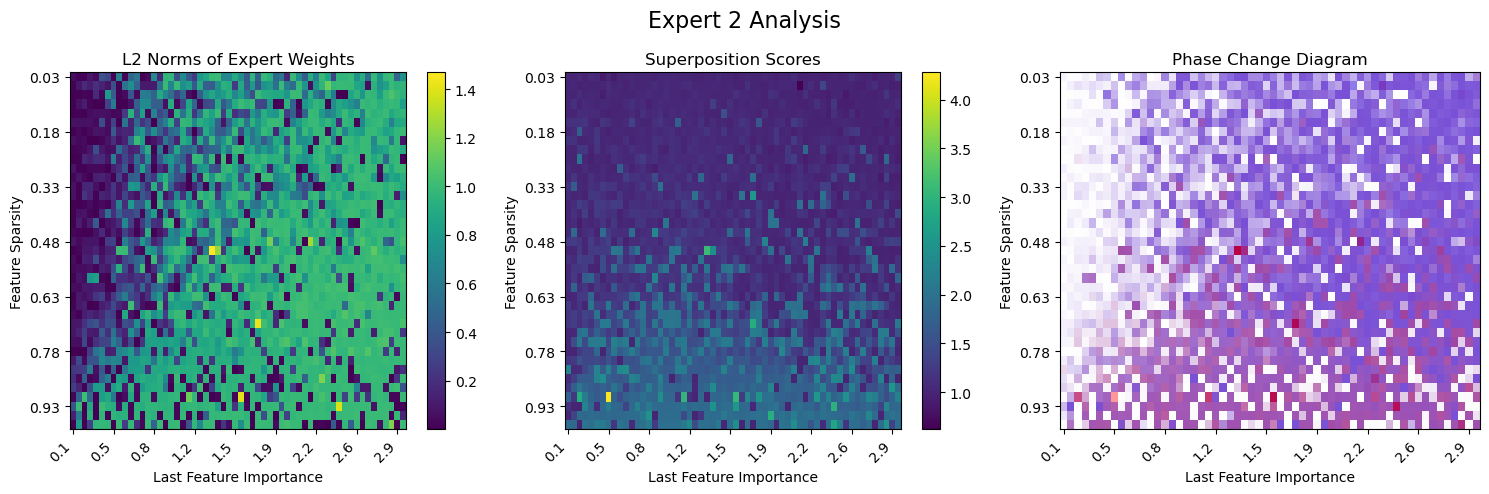

Grid results saved to: phase_change_results/313.npz
Grid size: 39 x 58 = 2262 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata
=== Running Complete Simulation Analysis ===
Simulating 5000 samples per grid cell
Simulating expert activation with 5000 samples for 3 experts
Grid size: 39 x 58 = 2262 cells


Completed simulation for 2262 grid cells

--- Analyzing Expert 0 ---
Analyzing simulation results for expert 0


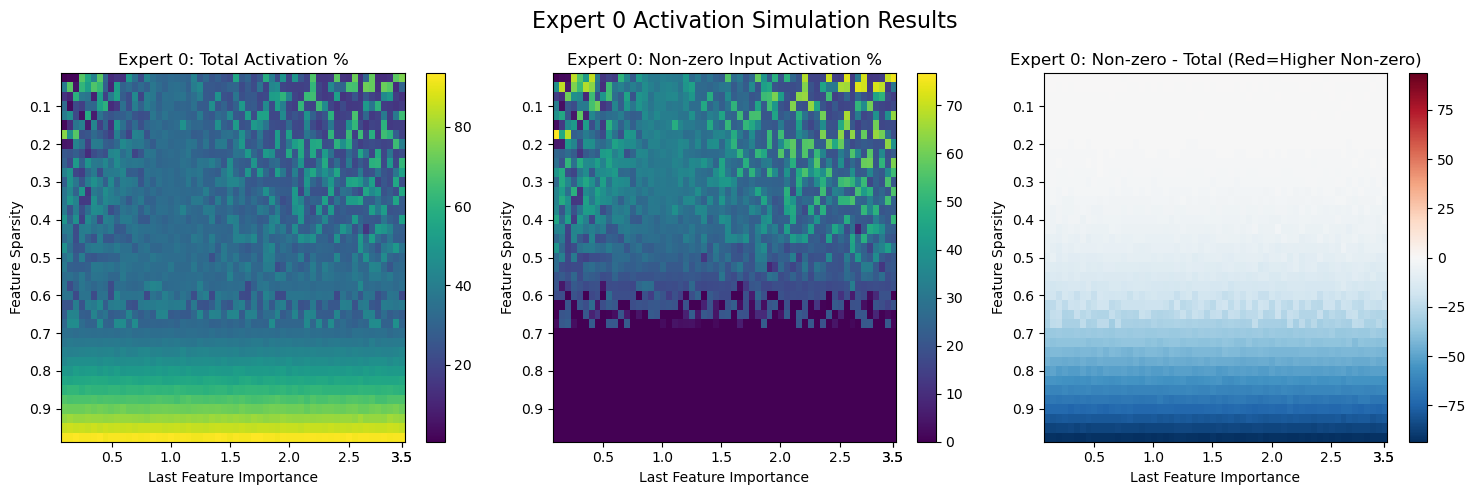


=== Expert 0 Simulation Summary ===
Total activation: 41.95% ± 18.27%
Non-zero input activation: 18.60% ± 16.73%
Difference (Non-zero - Total): -23.35%
  → Expert 0 is activated LESS often for non-zero inputs than overall

--- Analyzing Expert 1 ---
Analyzing simulation results for expert 1


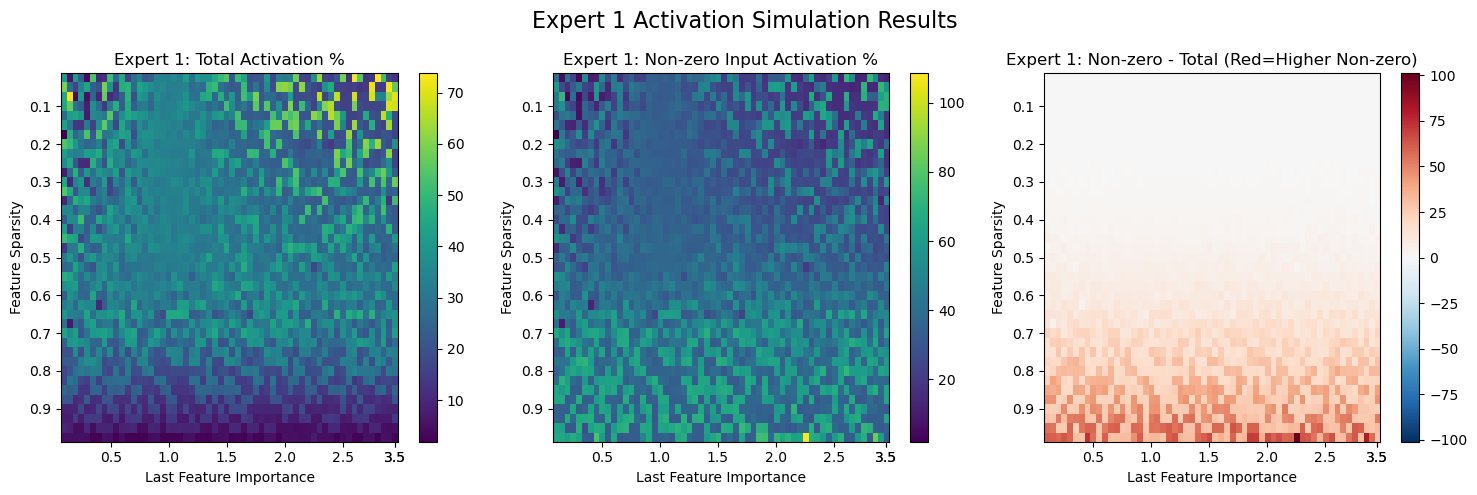


=== Expert 1 Simulation Summary ===
Total activation: 28.80% ± 12.14%
Non-zero input activation: 40.41% ± 13.85%
Difference (Non-zero - Total): 11.61%
  → Expert 1 is activated MORE often for non-zero inputs than overall

--- Analyzing Expert 2 ---
Analyzing simulation results for expert 2


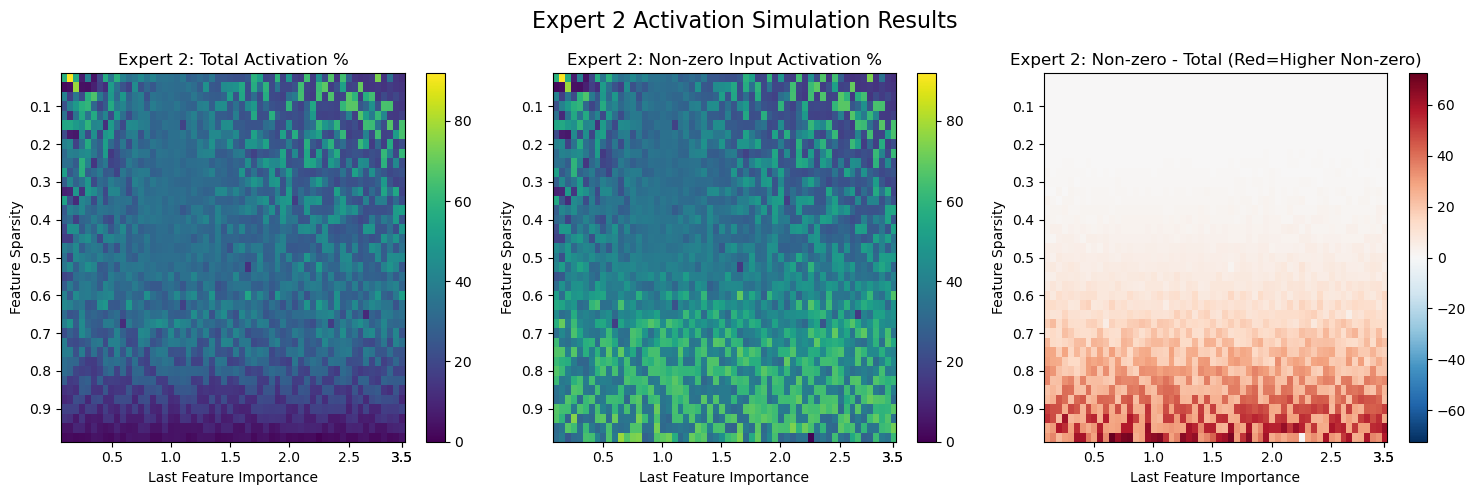


=== Expert 2 Simulation Summary ===
Total activation: 29.25% ± 12.28%
Non-zero input activation: 41.01% ± 14.05%
Difference (Non-zero - Total): 11.77%
  → Expert 2 is activated MORE often for non-zero inputs than overall

--- Overall Analysis ---
Analyzing simulation results for all 3 experts


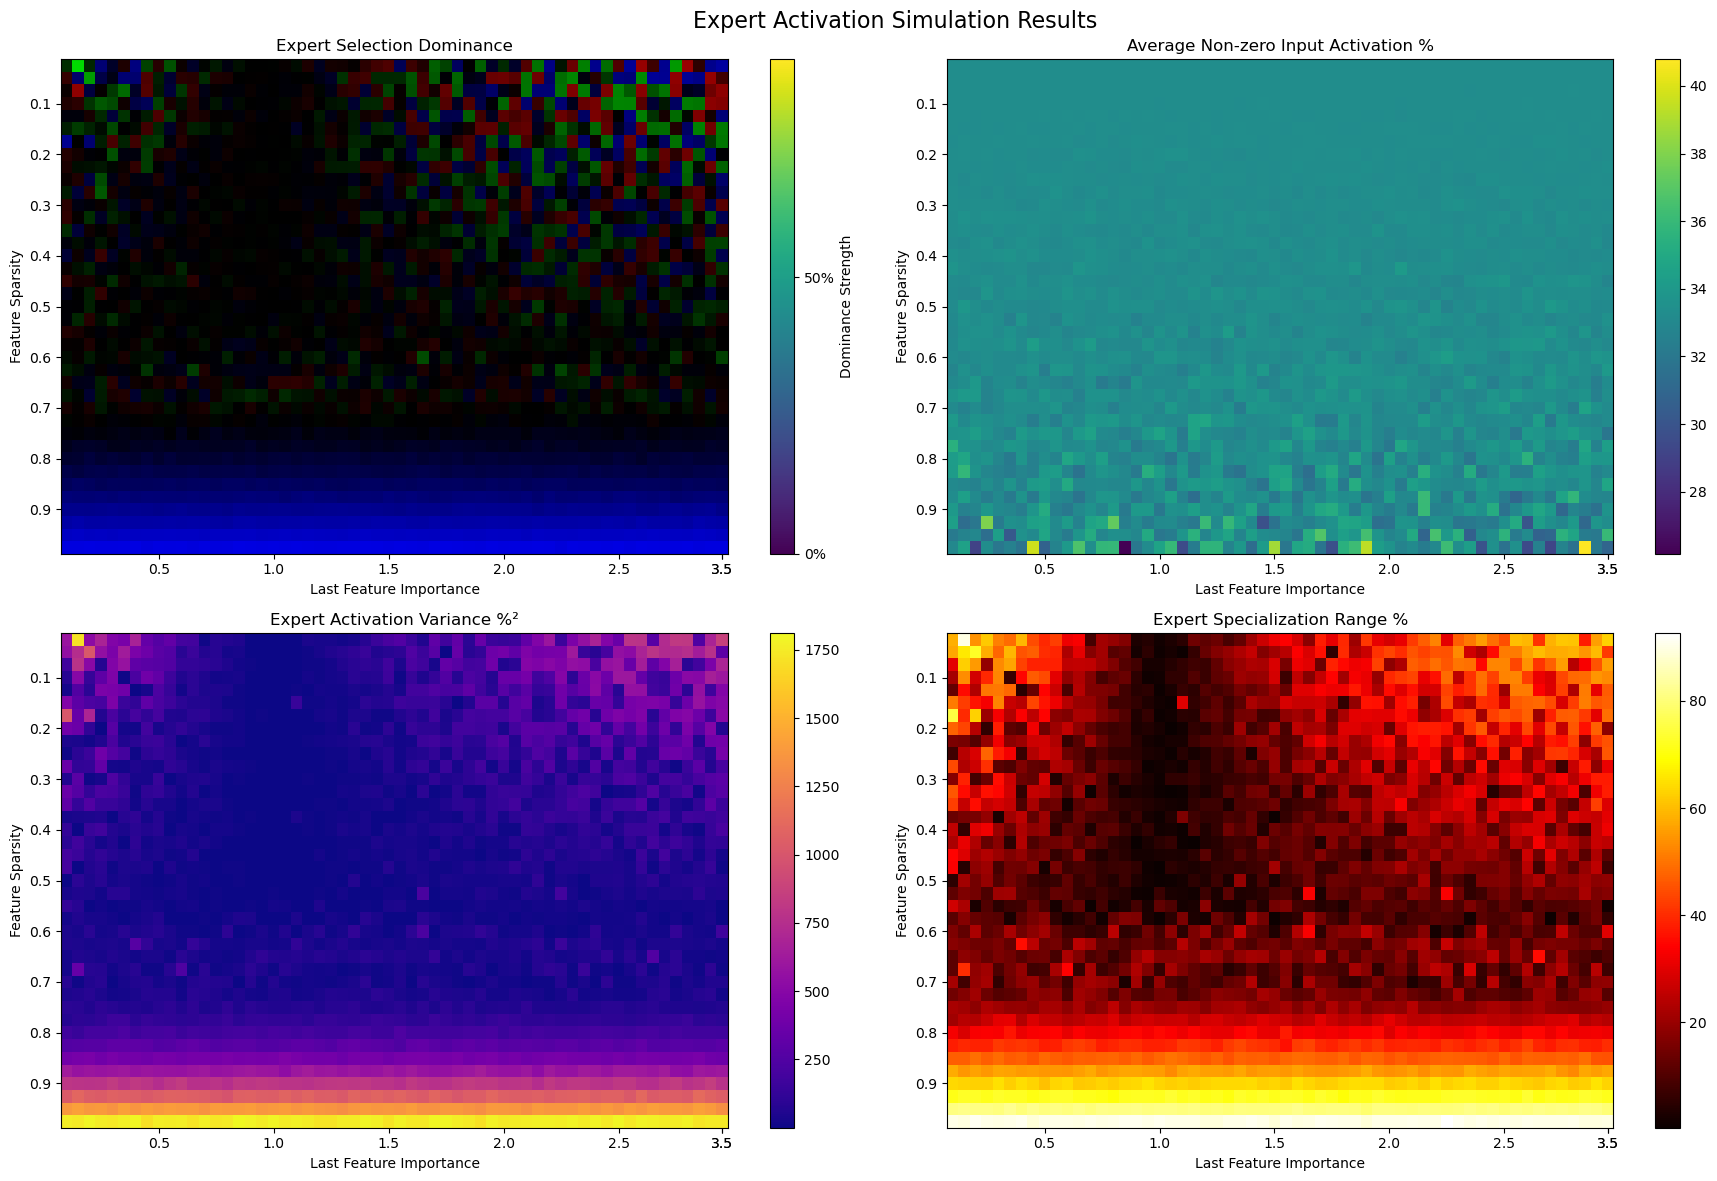


=== Simulation Results Summary ===

Expert 0:
  Total activation: 41.95% ± 18.27%
  Non-zero input activation: 18.60% ± 16.73%
  Difference (Non-zero - Total): -23.35%

Expert 1:
  Total activation: 28.80% ± 12.14%
  Non-zero input activation: 40.41% ± 13.85%
  Difference (Non-zero - Total): 11.61%

Expert 2:
  Total activation: 29.25% ± 12.28%
  Non-zero input activation: 41.01% ± 14.05%
  Difference (Non-zero - Total): 11.77%


In [ ]:
run_phase_change(3,1,3, "313")

Creating grid with 39 sparsity values and 58 importance values
Total grid points: 2262
Training 10 independent runs...


Training run 1/10...


Step 0: avg_loss=0.366249, lr=0.001000


Step 1250: avg_loss=0.068538, lr=0.001000


Step 2500: avg_loss=0.057147, lr=0.001000


Step 3750: avg_loss=0.055834, lr=0.001000


Step 4999: avg_loss=0.055525, lr=0.001000
Training run 2/10...


Step 0: avg_loss=0.380500, lr=0.001000


Step 4999: avg_loss=0.056240, lr=0.001000
Training run 3/10...


Step 0: avg_loss=0.377964, lr=0.001000


Step 4999: avg_loss=0.056435, lr=0.001000
Training run 4/10...


Step 0: avg_loss=0.386860, lr=0.001000


Step 4999: avg_loss=0.055434, lr=0.001000
Training run 5/10...


Step 0: avg_loss=0.378452, lr=0.001000


Step 4999: avg_loss=0.055003, lr=0.001000
Training run 6/10...


Step 0: avg_loss=0.381423, lr=0.001000


Step 4999: avg_loss=0.055600, lr=0.001000
Training run 7/10...


Step 0: avg_loss=0.370786, lr=0.001000


Step 4999: avg_loss=0.056439, lr=0.001000
Training run 8/10...


Step 0: avg_loss=0.390233, lr=0.001000


Step 4999: avg_loss=0.055779, lr=0.001000
Training run 9/10...


Step 0: avg_loss=0.373388, lr=0.001000


Step 4999: avg_loss=0.056227, lr=0.001000
Training run 10/10...


Step 0: avg_loss=0.366906, lr=0.001000


Step 4999: avg_loss=0.055440, lr=0.001000
Selecting best models per grid cell...
  Debug Cell 0/5 (0.03, 0.1): best loss 0.012802 (run 1)
  Debug Cell 1/5 (0.03, 0.2): best loss 0.014215 (run 5)
  Debug Cell 2/5 (0.03, 0.2): best loss 0.015494 (run 9)
  Debug Cell 3/5 (0.03, 0.3): best loss 0.017107 (run 6)
  Debug Cell 4/5 (0.03, 0.3): best loss 0.018389 (run 5)


Training completed in 5224.81 seconds
Total models trained: 22620
Analyzing expert allocations for all grid points...


Analyzing 1 experts for feature 0


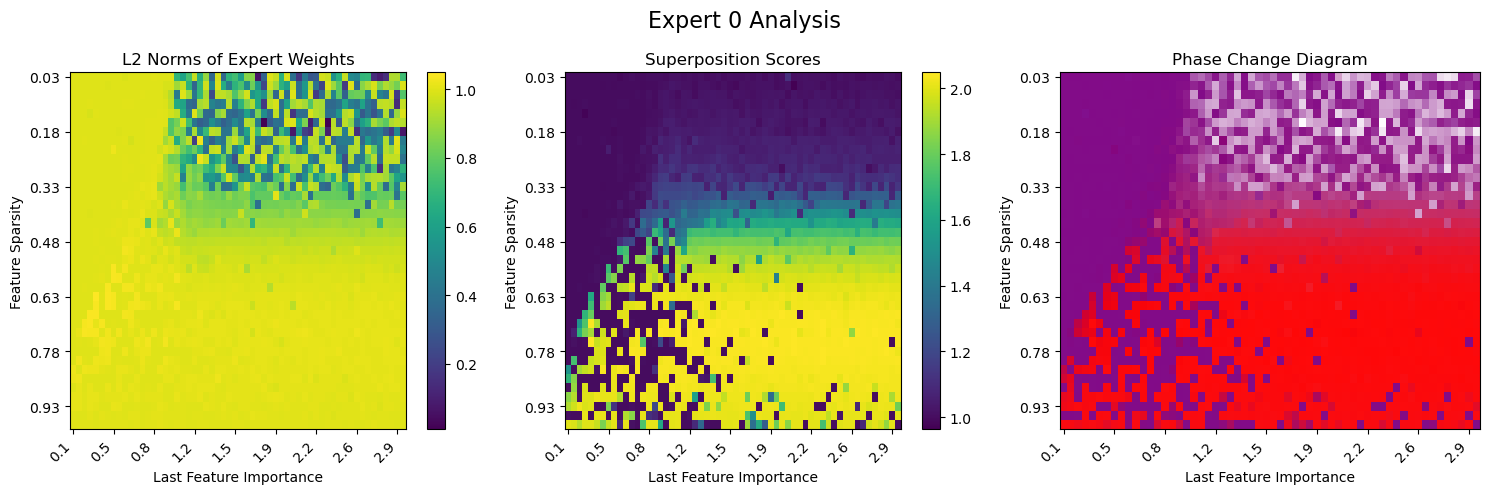

Analyzing 1 experts for feature 1


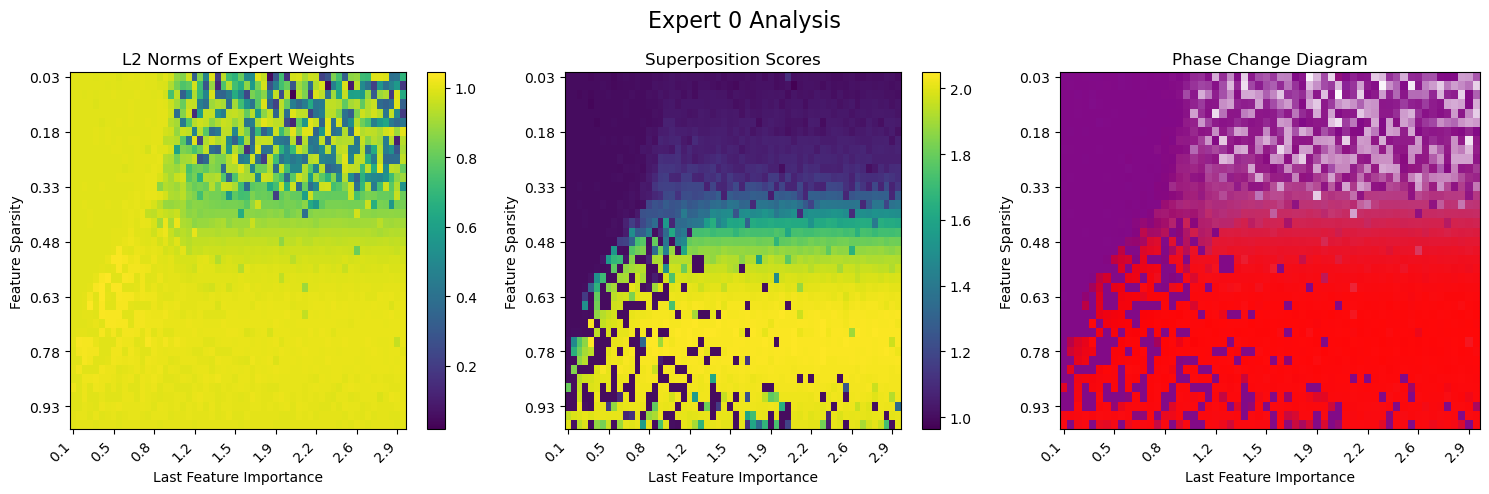

Analyzing 1 experts for feature 2


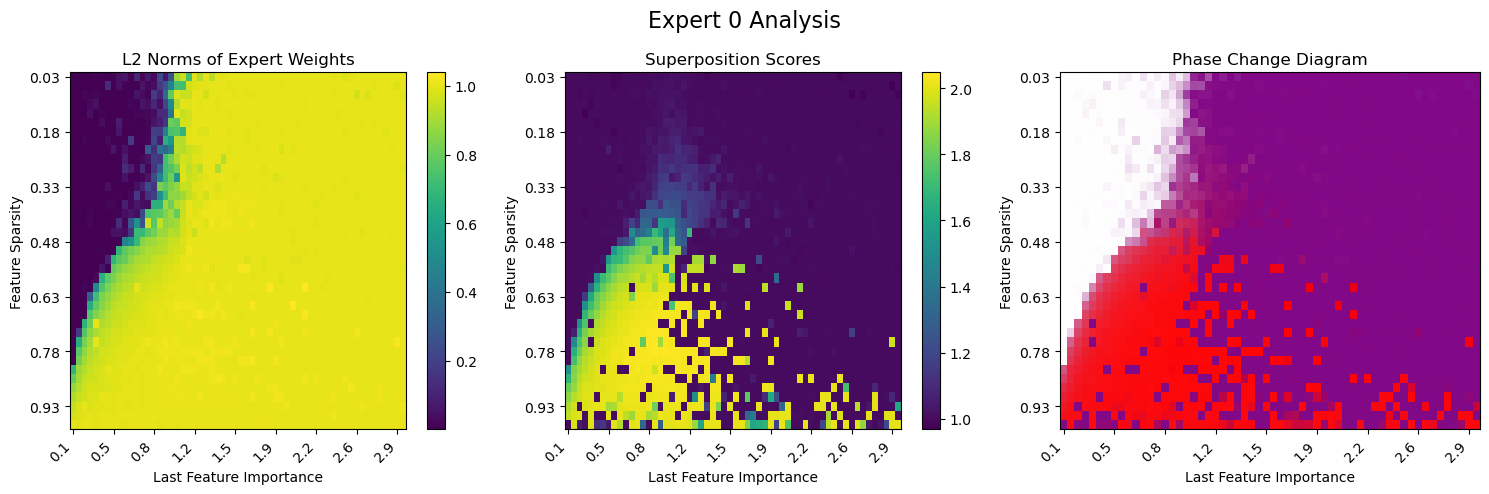

Grid results saved to: phase_change_results/321.npz
Grid size: 39 x 58 = 2262 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata


In [ ]:
run_phase_change(3,2,1, "321")

Creating grid with 39 sparsity values and 58 importance values
Total grid points: 2262
Training 10 independent runs...


Training run 1/10...


Step 0: avg_loss=0.308008, lr=0.001000


Step 1250: avg_loss=0.061967, lr=0.001000


Step 2500: avg_loss=0.053479, lr=0.001000


Step 3750: avg_loss=0.052028, lr=0.001000


Step 4999: avg_loss=0.051845, lr=0.001000
Training run 2/10...


Step 0: avg_loss=0.310492, lr=0.001000


Step 4999: avg_loss=0.052616, lr=0.001000
Training run 3/10...


Step 0: avg_loss=0.301118, lr=0.001000


Step 4999: avg_loss=0.052537, lr=0.001000
Training run 4/10...


Step 0: avg_loss=0.305162, lr=0.001000


Step 4999: avg_loss=0.052274, lr=0.001000
Training run 5/10...


Step 0: avg_loss=0.308629, lr=0.001000


Step 4999: avg_loss=0.050188, lr=0.001000
Training run 6/10...


Step 0: avg_loss=0.312753, lr=0.001000


Step 4999: avg_loss=0.050115, lr=0.001000
Training run 7/10...


Step 0: avg_loss=0.308144, lr=0.001000


Step 4999: avg_loss=0.050693, lr=0.001000
Training run 8/10...


Step 0: avg_loss=0.312479, lr=0.001000


Step 4999: avg_loss=0.052635, lr=0.001000
Training run 9/10...


Step 0: avg_loss=0.302959, lr=0.001000


Step 4999: avg_loss=0.051077, lr=0.001000
Training run 10/10...


Step 0: avg_loss=0.303223, lr=0.001000


Step 4999: avg_loss=0.052594, lr=0.001000
Selecting best models per grid cell...
  Debug Cell 0/5 (0.03, 0.1): best loss 0.011411 (run 1)
  Debug Cell 1/5 (0.03, 0.2): best loss 0.013399 (run 7)
  Debug Cell 2/5 (0.03, 0.2): best loss 0.012423 (run 9)
  Debug Cell 3/5 (0.03, 0.3): best loss 0.015556 (run 5)
  Debug Cell 4/5 (0.03, 0.3): best loss 0.014795 (run 5)


Training completed in 5838.01 seconds
Total models trained: 22620
Analyzing expert allocations for all grid points...


Analyzing 2 experts for feature 0


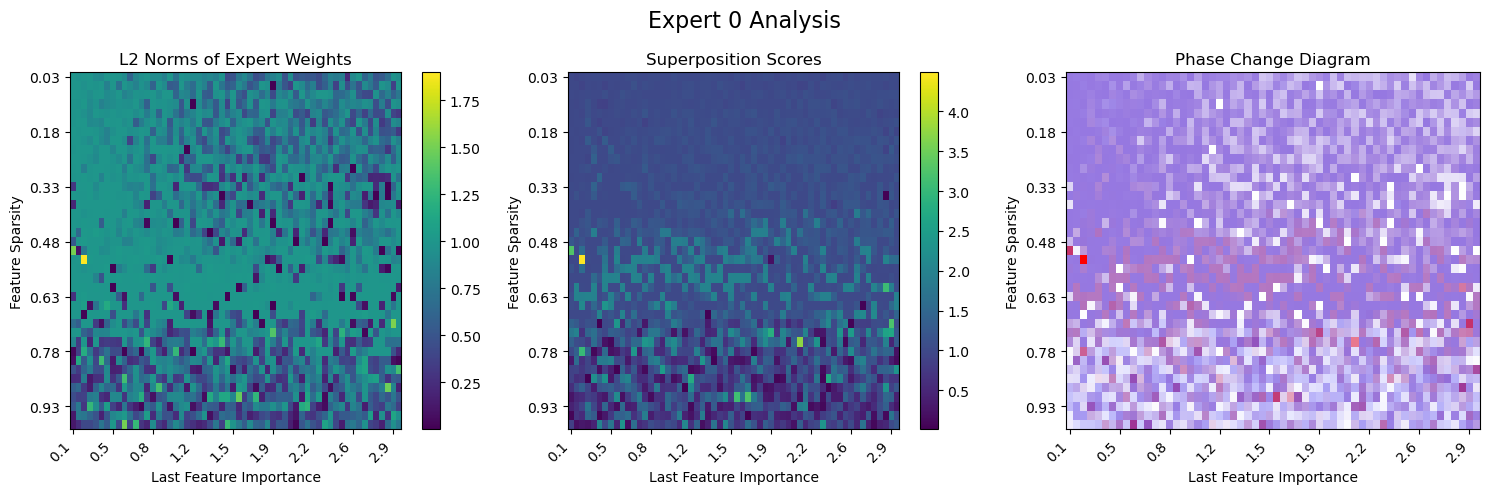

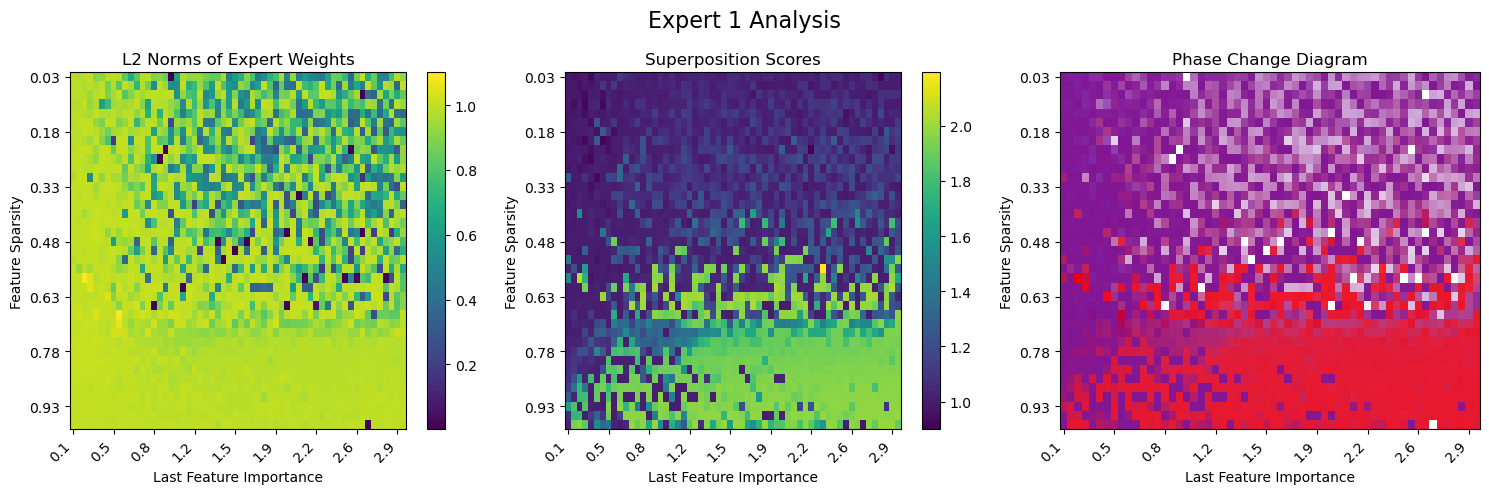

Analyzing 2 experts for feature 1


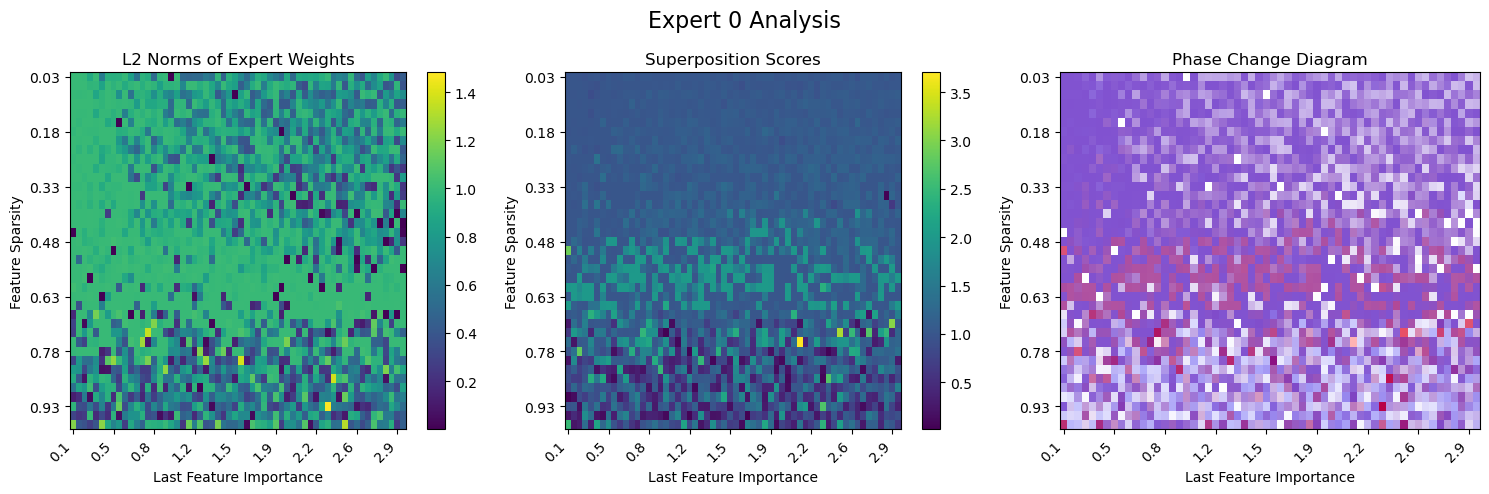

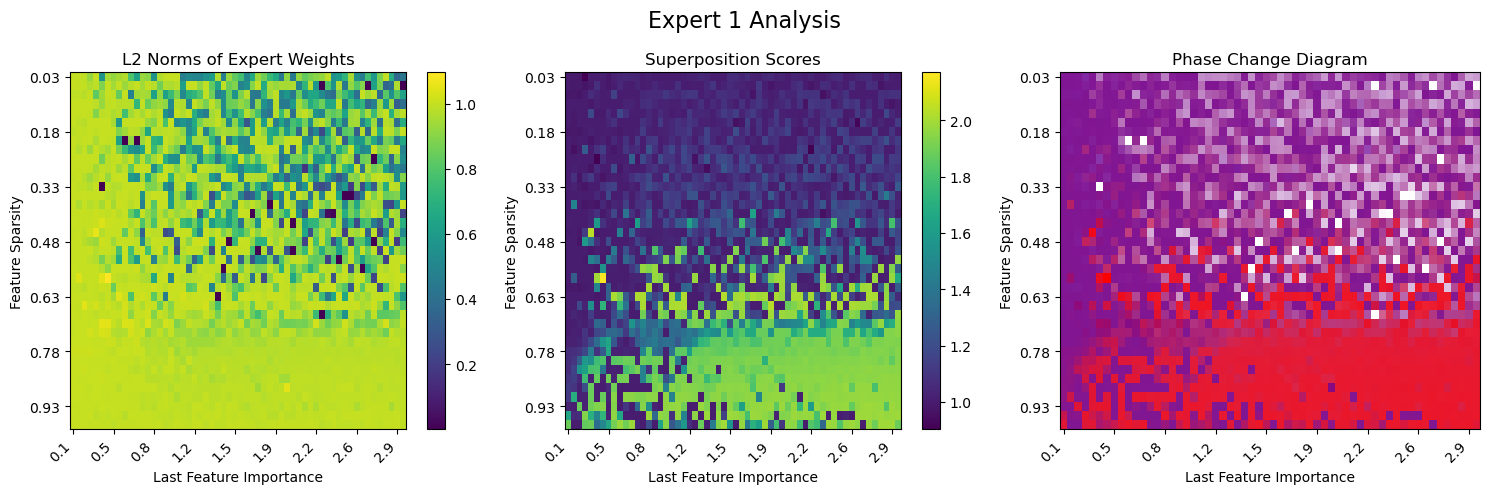

Analyzing 2 experts for feature 2


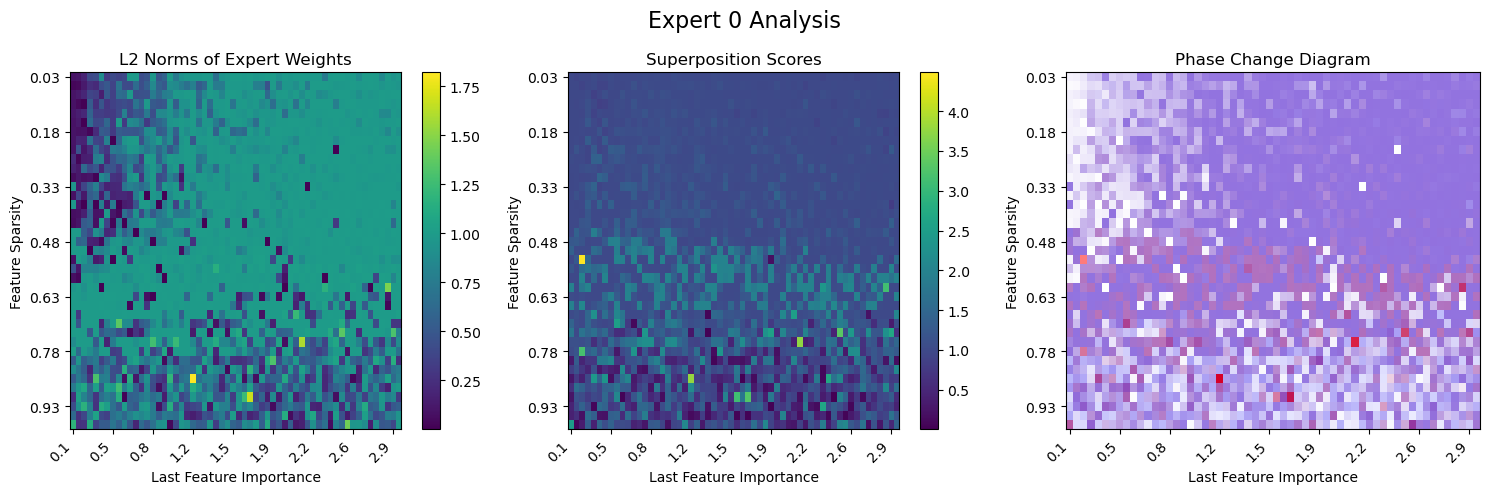

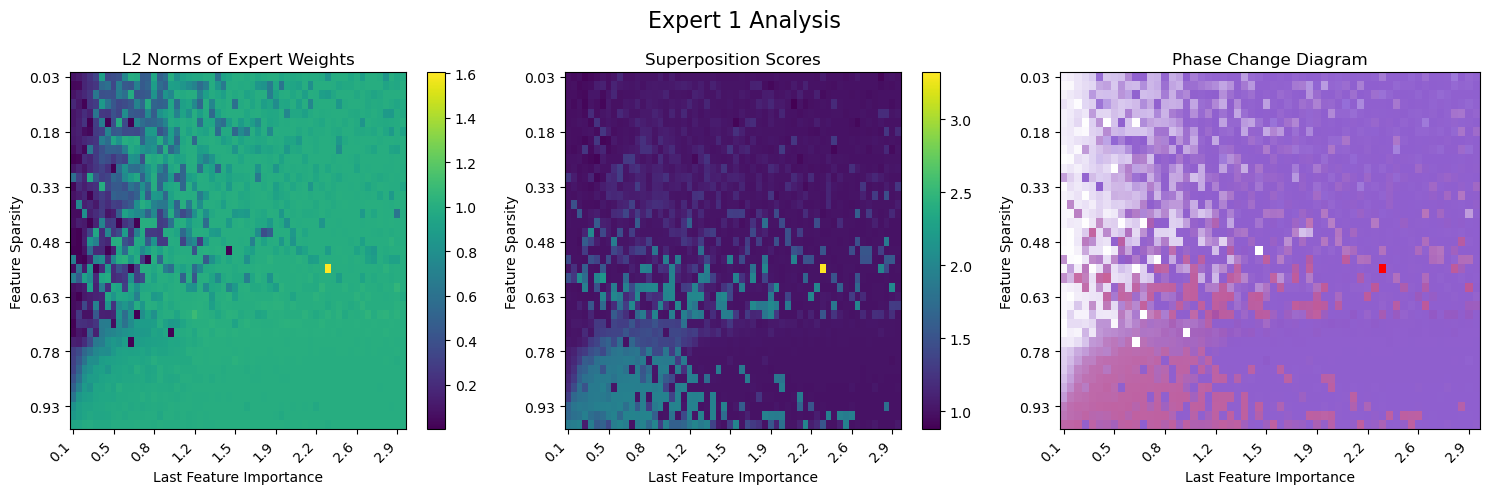

Grid results saved to: phase_change_results/322.npz
Grid size: 39 x 58 = 2262 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata
=== Running Complete Simulation Analysis ===
Simulating 5000 samples per grid cell
Simulating expert activation with 5000 samples for 2 experts
Grid size: 39 x 58 = 2262 cells


Completed simulation for 2262 grid cells

--- Analyzing Expert 0 ---
Analyzing simulation results for expert 0


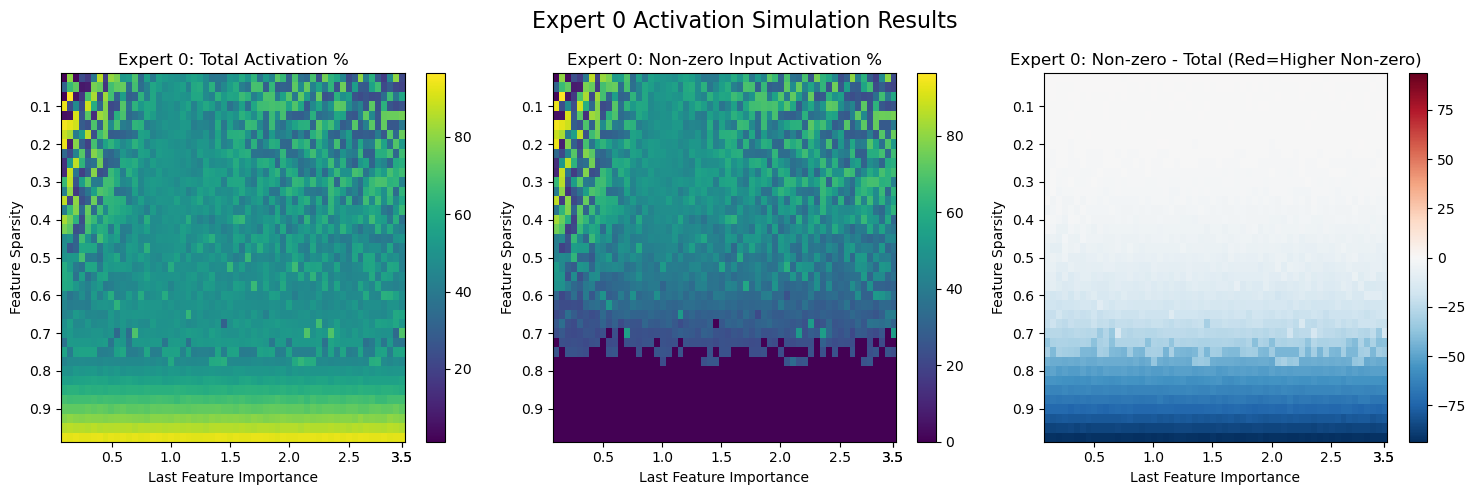


=== Expert 0 Simulation Summary ===
Total activation: 54.16% ± 14.60%
Non-zero input activation: 32.52% ± 22.44%
Difference (Non-zero - Total): -21.64%
  → Expert 0 is activated LESS often for non-zero inputs than overall

--- Analyzing Expert 1 ---
Analyzing simulation results for expert 1


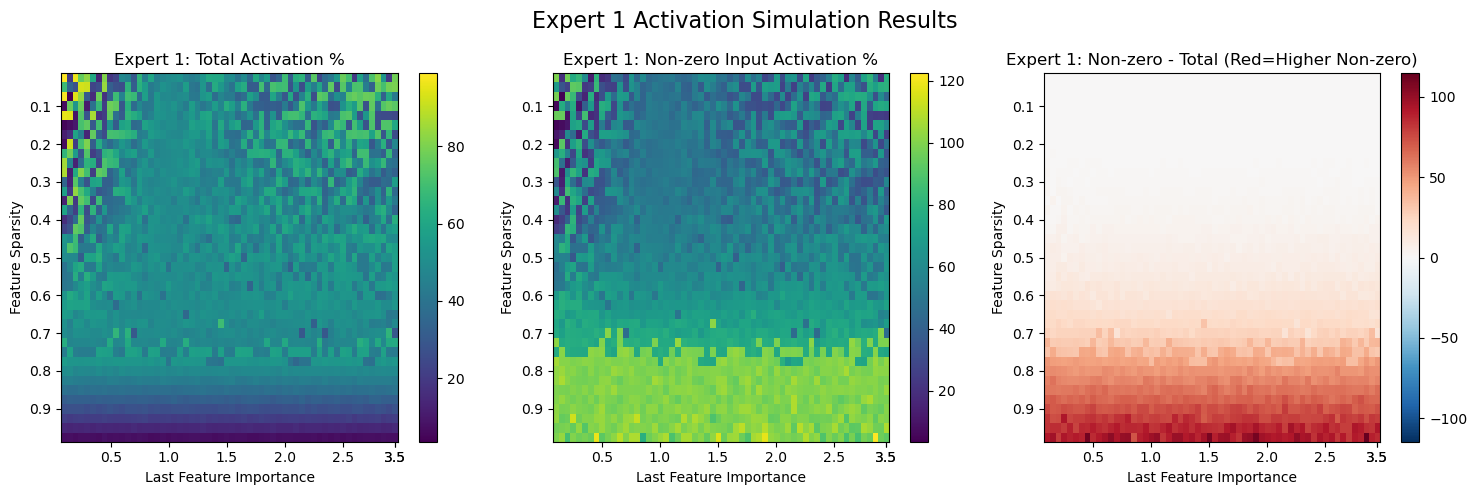


=== Expert 1 Simulation Summary ===
Total activation: 45.84% ± 14.60%
Non-zero input activation: 67.50% ± 22.56%
Difference (Non-zero - Total): 21.66%
  → Expert 1 is activated MORE often for non-zero inputs than overall

--- Overall Analysis ---
Analyzing simulation results for all 2 experts


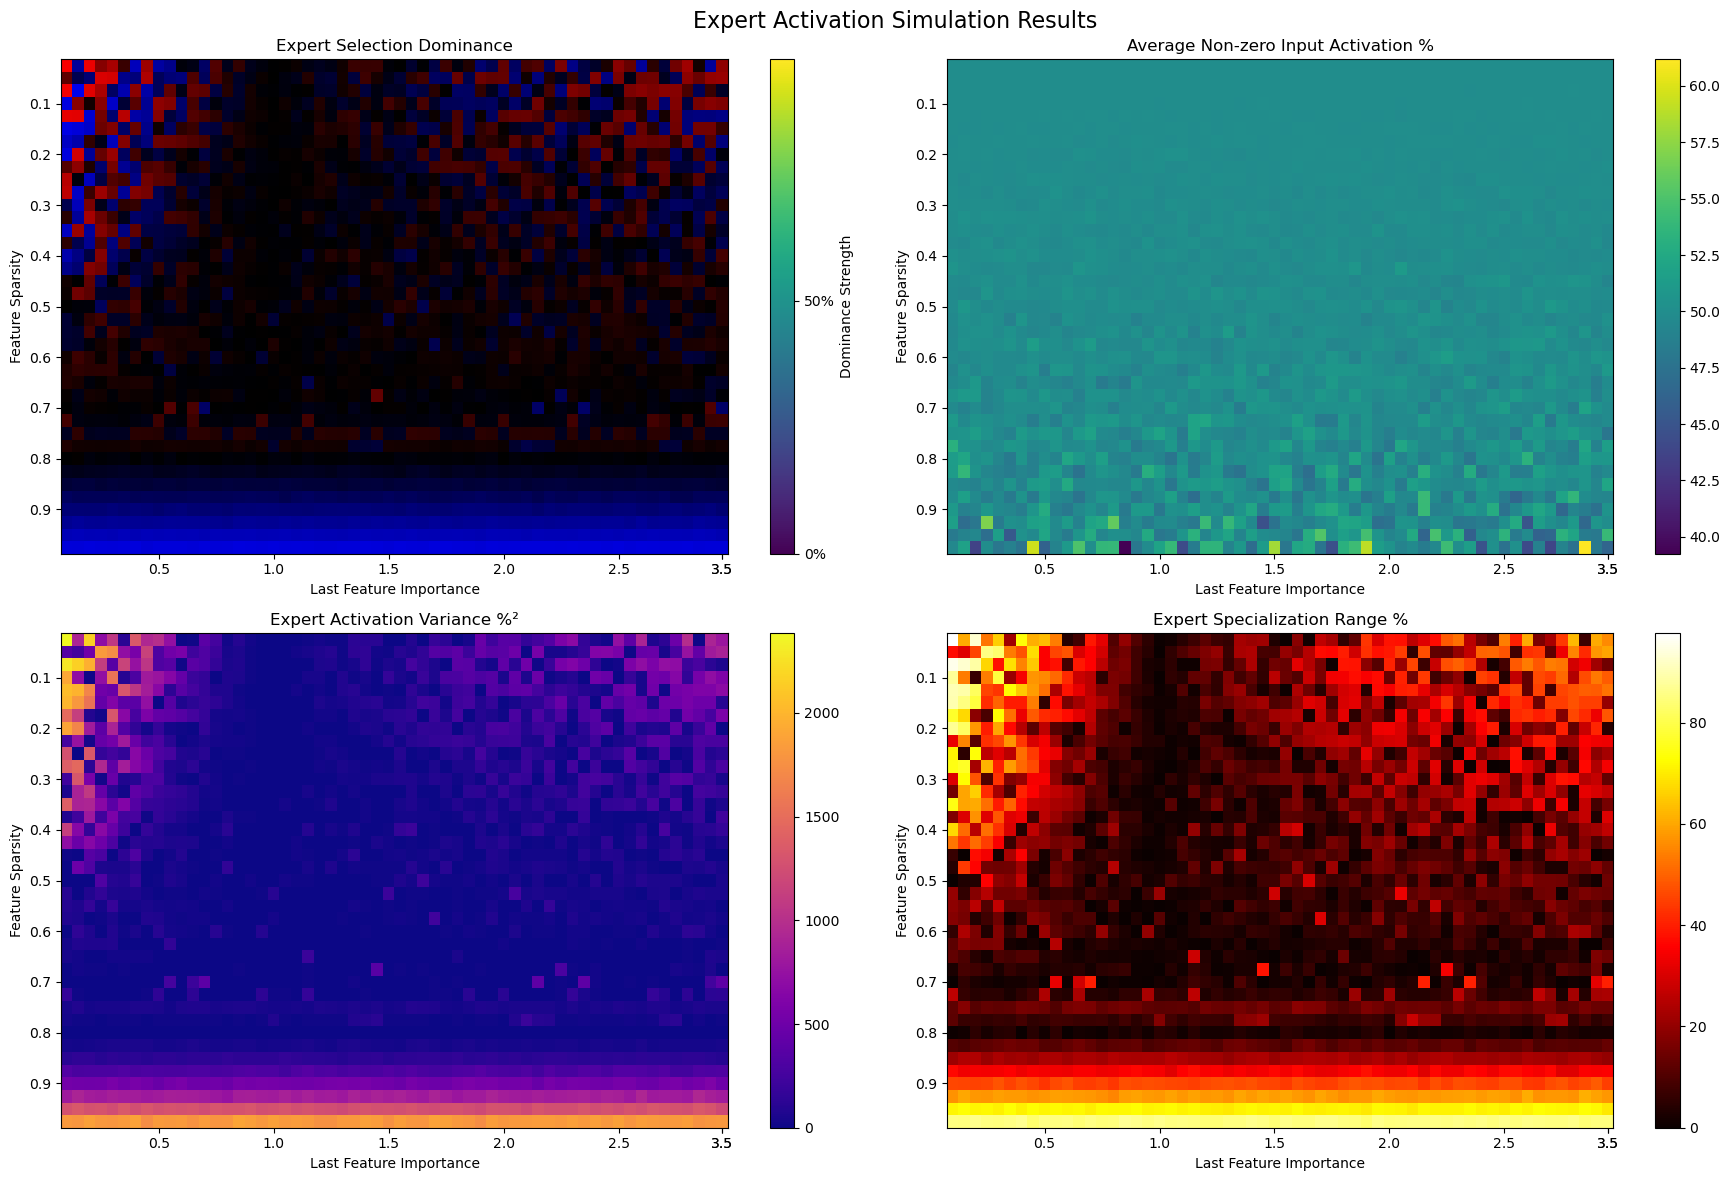


=== Simulation Results Summary ===

Expert 0:
  Total activation: 54.16% ± 14.60%
  Non-zero input activation: 32.52% ± 22.44%
  Difference (Non-zero - Total): -21.64%

Expert 1:
  Total activation: 45.84% ± 14.60%
  Non-zero input activation: 67.50% ± 22.56%
  Difference (Non-zero - Total): 21.66%


In [ ]:
run_phase_change(3,2,2, "322")

Creating grid with 39 sparsity values and 58 importance values
Total grid points: 2262
Training 10 independent runs...
Training run 1/10...


Step 0: avg_loss=0.267085, lr=0.001000


Step 1250: avg_loss=0.059446, lr=0.001000


Step 2500: avg_loss=0.053351, lr=0.001000


Step 3750: avg_loss=0.052404, lr=0.001000


Step 4999: avg_loss=0.052164, lr=0.001000
Training run 2/10...


Step 0: avg_loss=0.269987, lr=0.001000


Step 4999: avg_loss=0.051219, lr=0.001000
Training run 3/10...


Step 0: avg_loss=0.263669, lr=0.001000


Step 4999: avg_loss=0.052538, lr=0.001000
Training run 4/10...


Step 0: avg_loss=0.267362, lr=0.001000


Step 4999: avg_loss=0.051510, lr=0.001000
Training run 5/10...


Step 0: avg_loss=0.265300, lr=0.001000


Step 4999: avg_loss=0.050770, lr=0.001000
Training run 6/10...


Step 0: avg_loss=0.269496, lr=0.001000


Step 4999: avg_loss=0.050018, lr=0.001000
Training run 7/10...


Step 0: avg_loss=0.270078, lr=0.001000


Step 4999: avg_loss=0.051213, lr=0.001000
Training run 8/10...


Step 0: avg_loss=0.268829, lr=0.001000


Step 4999: avg_loss=0.054365, lr=0.001000
Training run 9/10...


Step 0: avg_loss=0.266088, lr=0.001000


Step 4999: avg_loss=0.052360, lr=0.001000
Training run 10/10...


Step 0: avg_loss=0.263209, lr=0.001000


Step 4999: avg_loss=0.052451, lr=0.001000
Selecting best models per grid cell...
  Debug Cell 0/5 (0.03, 0.1): best loss 0.012008 (run 4)
  Debug Cell 1/5 (0.03, 0.2): best loss 0.012165 (run 7)
  Debug Cell 2/5 (0.03, 0.2): best loss 0.011801 (run 9)
  Debug Cell 3/5 (0.03, 0.3): best loss 0.012639 (run 5)
  Debug Cell 4/5 (0.03, 0.3): best loss 0.013575 (run 5)


Training completed in 6070.41 seconds
Total models trained: 22620
Analyzing expert allocations for all grid points...


Analyzing 3 experts for feature 0


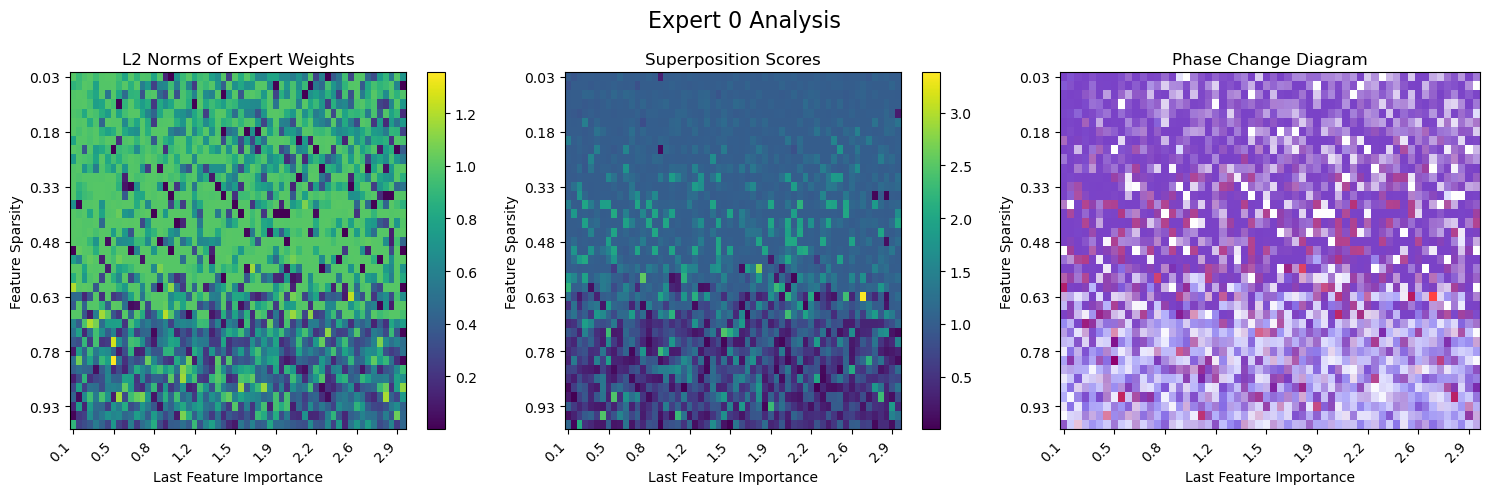

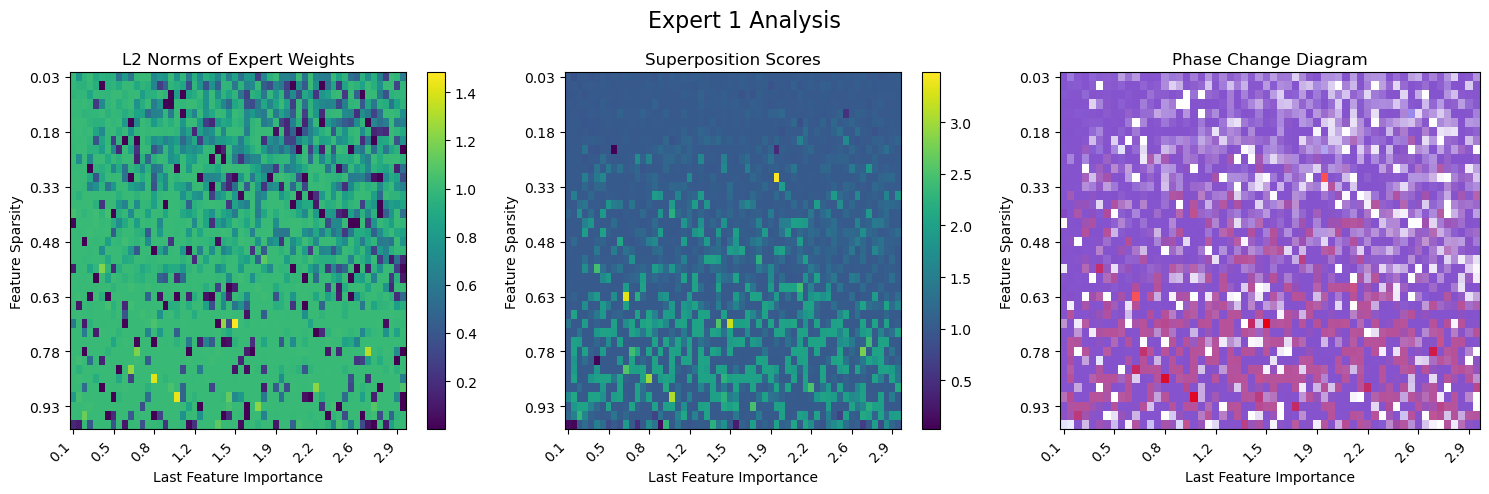

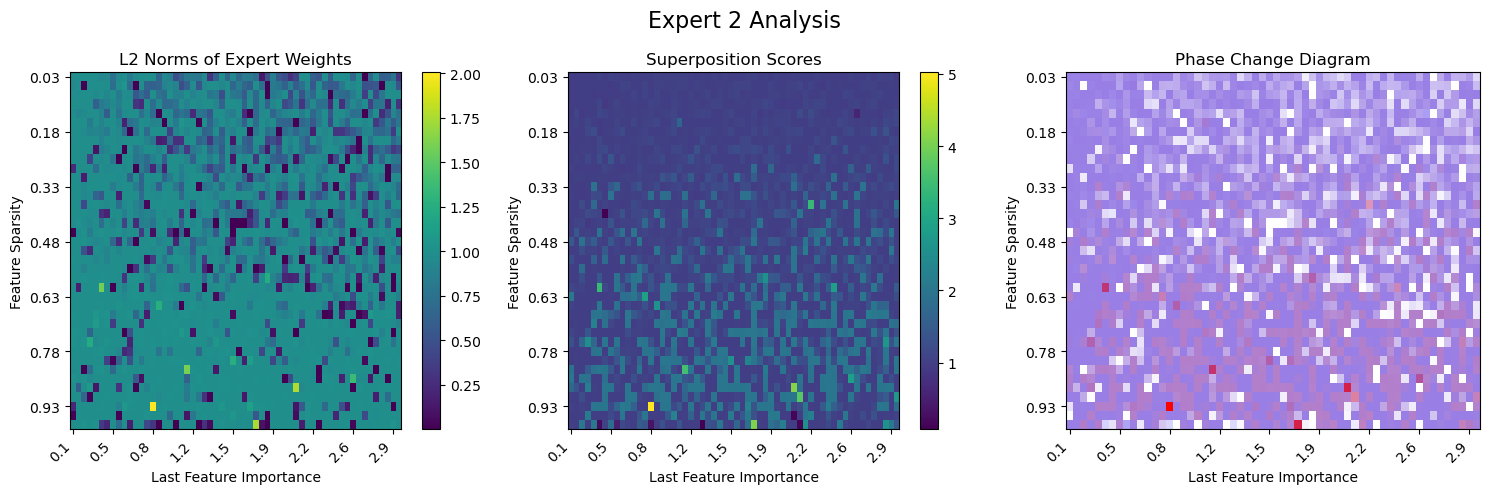

Analyzing 3 experts for feature 1


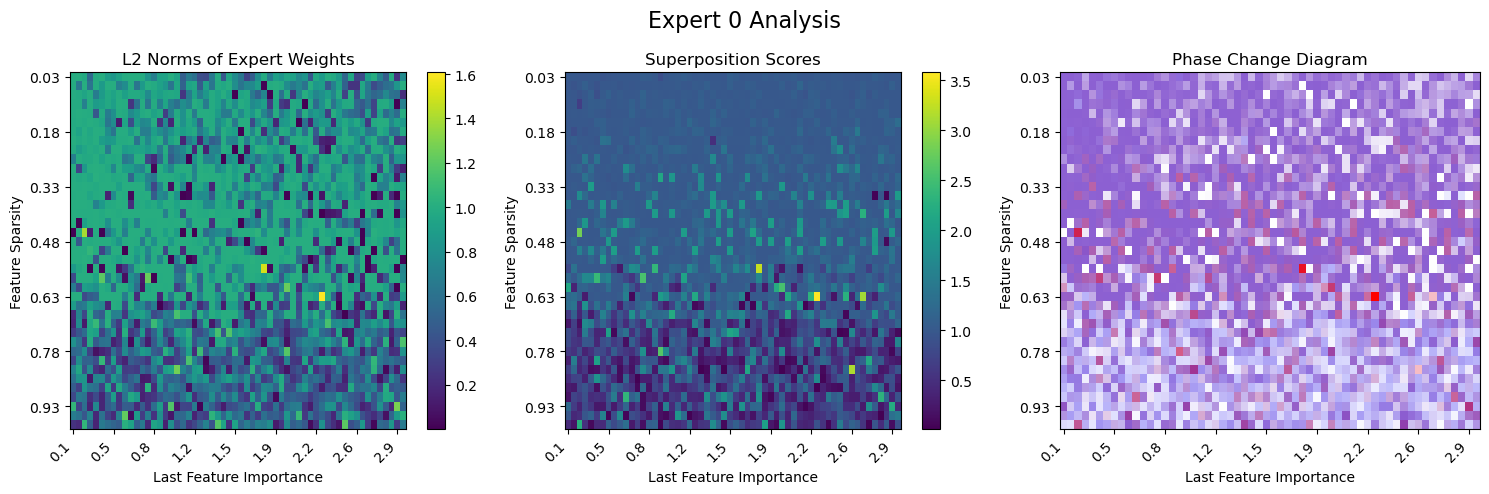

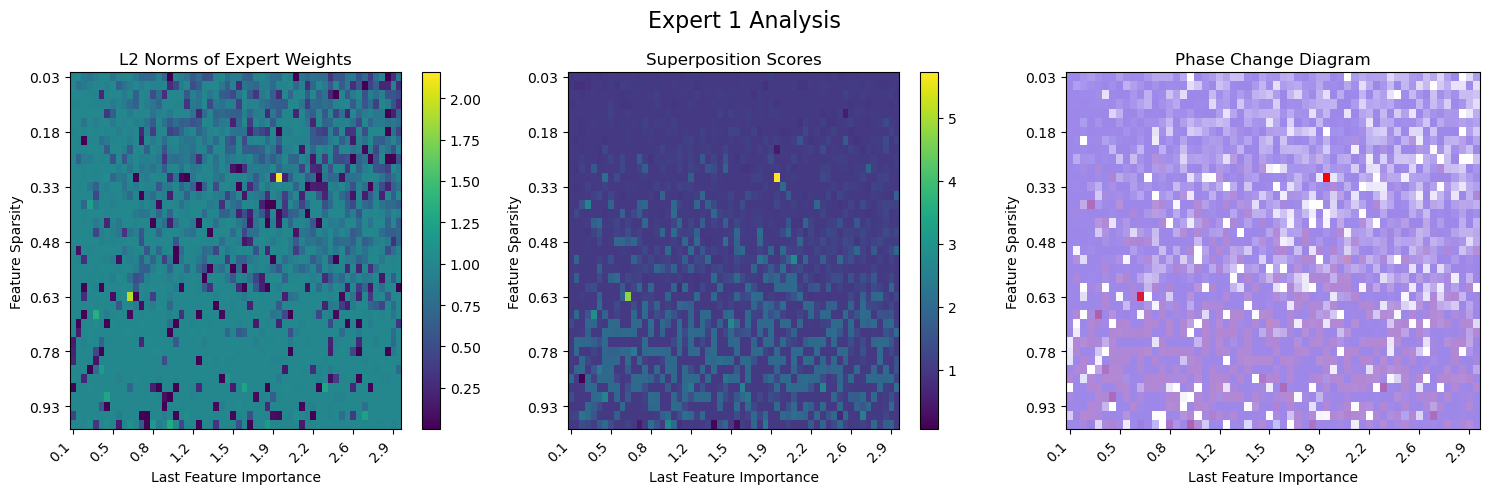

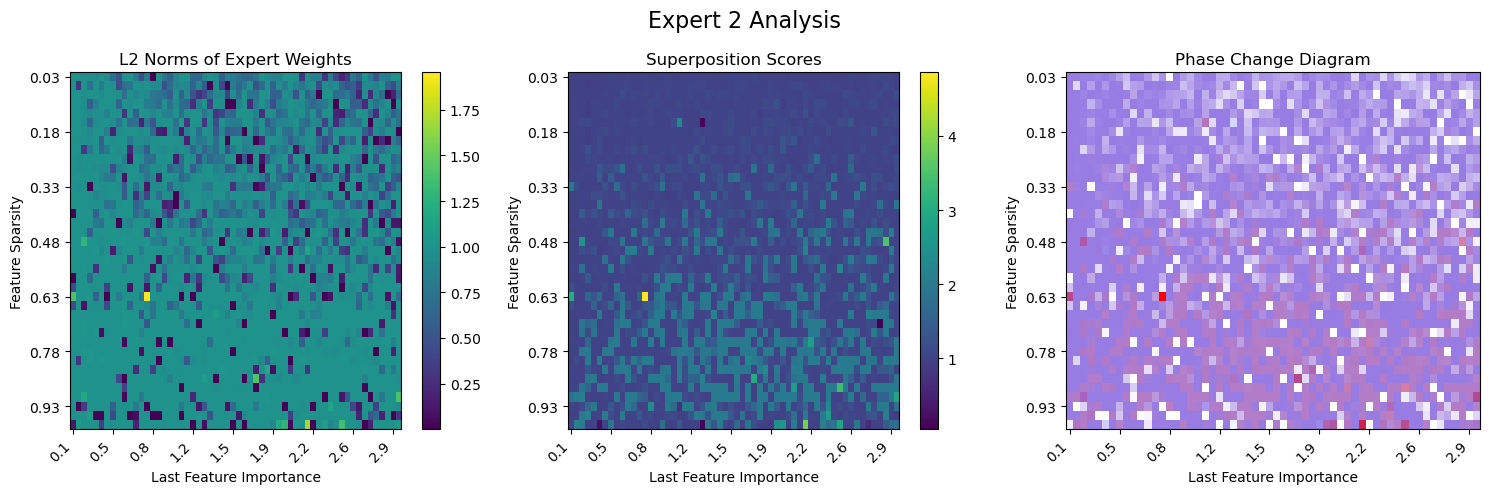

Analyzing 3 experts for feature 2


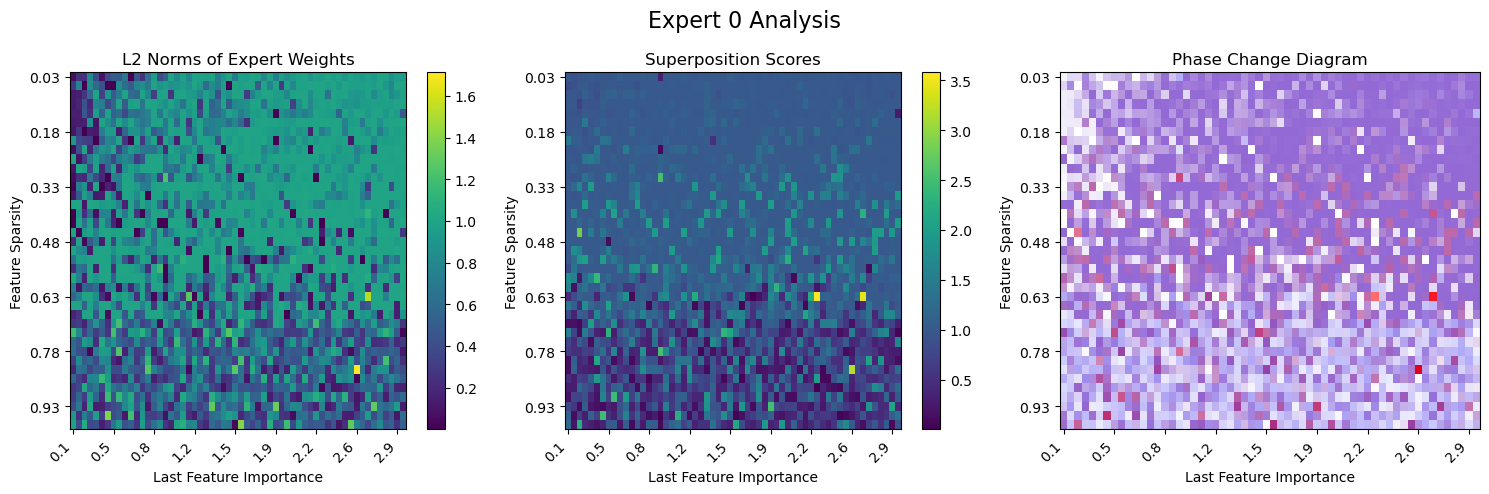

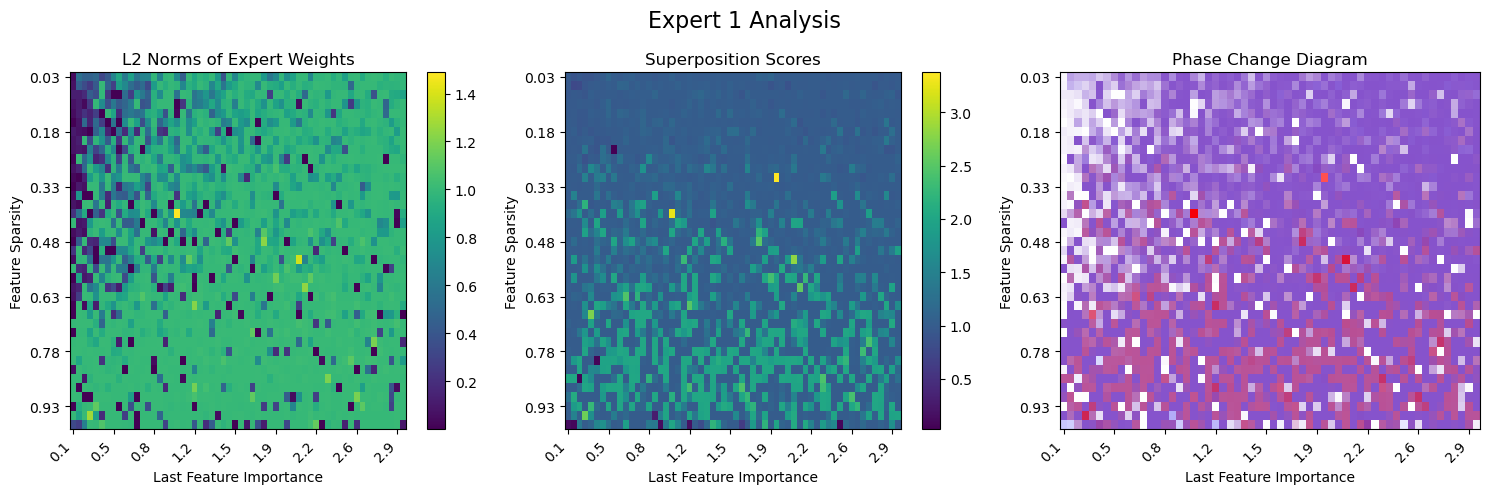

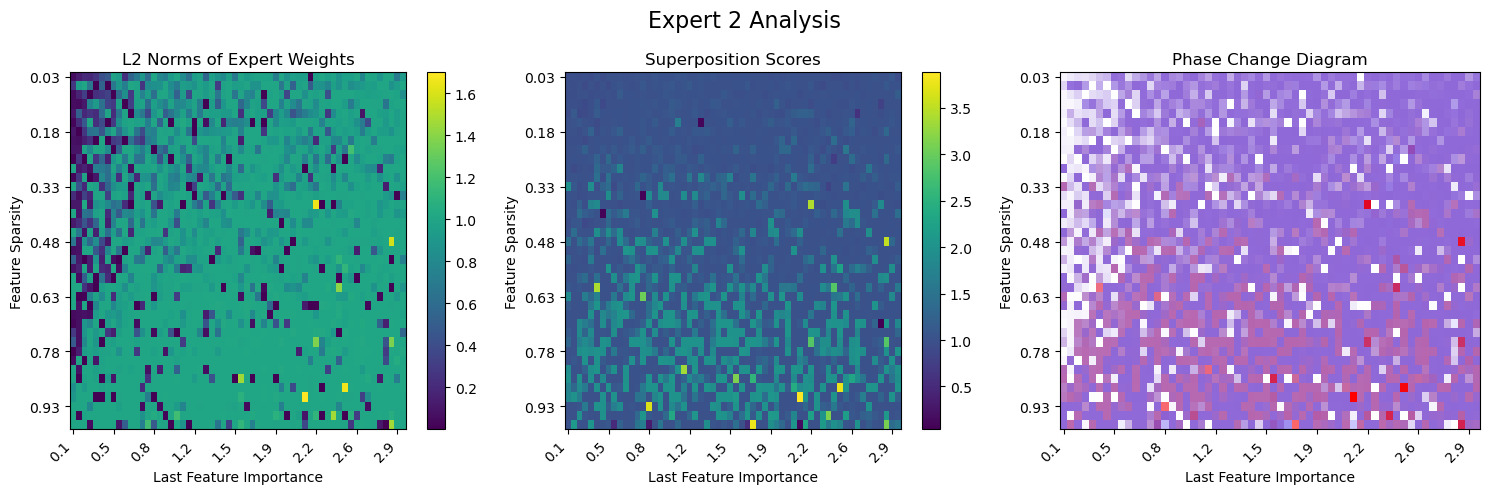

Grid results saved to: phase_change_results/323.npz
Grid size: 39 x 58 = 2262 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata
=== Running Complete Simulation Analysis ===
Simulating 5000 samples per grid cell
Simulating expert activation with 5000 samples for 3 experts
Grid size: 39 x 58 = 2262 cells


Completed simulation for 2262 grid cells

--- Analyzing Expert 0 ---
Analyzing simulation results for expert 0


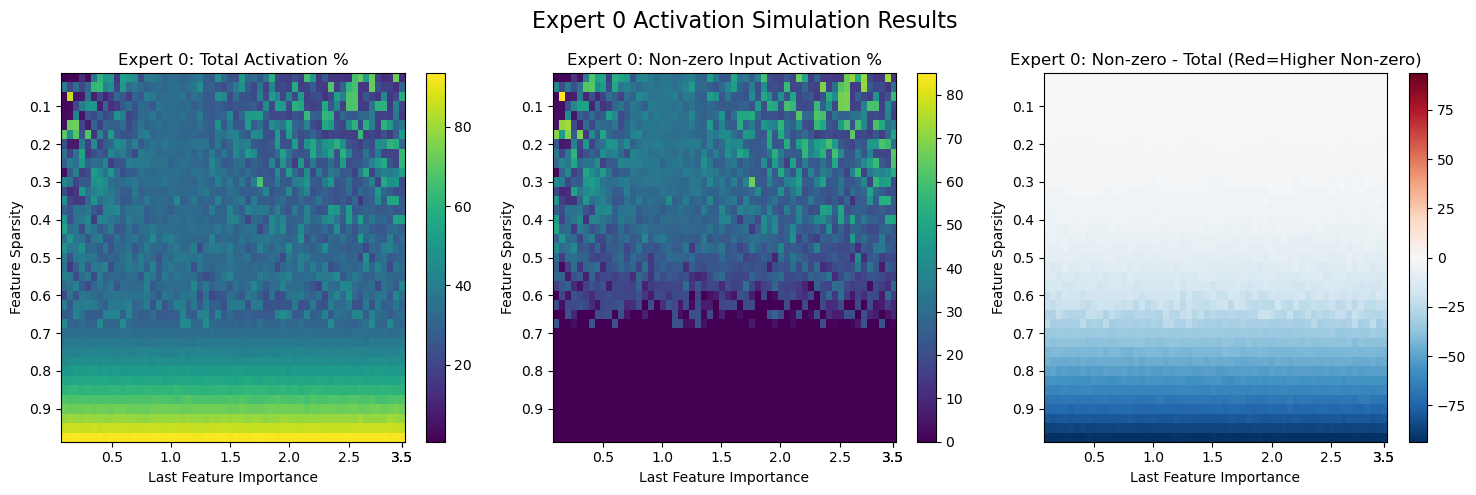


=== Expert 0 Simulation Summary ===
Total activation: 41.60% ± 18.30%
Non-zero input activation: 18.20% ± 16.46%
Difference (Non-zero - Total): -23.40%
  → Expert 0 is activated LESS often for non-zero inputs than overall

--- Analyzing Expert 1 ---
Analyzing simulation results for expert 1


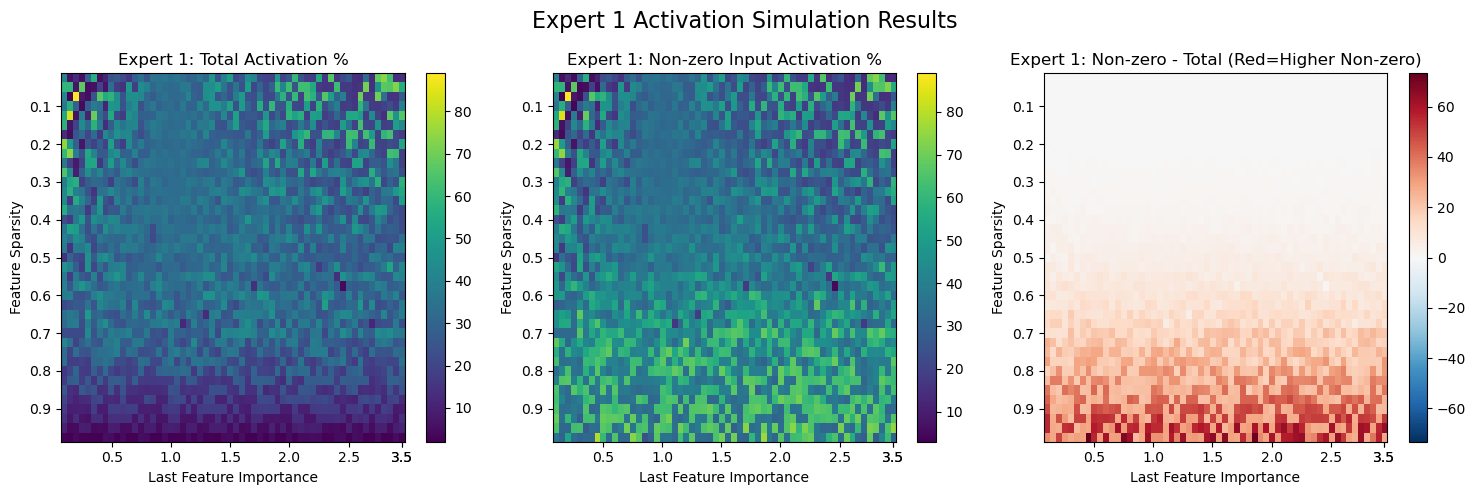


=== Expert 1 Simulation Summary ===
Total activation: 29.15% ± 12.42%
Non-zero input activation: 40.78% ± 13.87%
Difference (Non-zero - Total): 11.63%
  → Expert 1 is activated MORE often for non-zero inputs than overall

--- Analyzing Expert 2 ---
Analyzing simulation results for expert 2


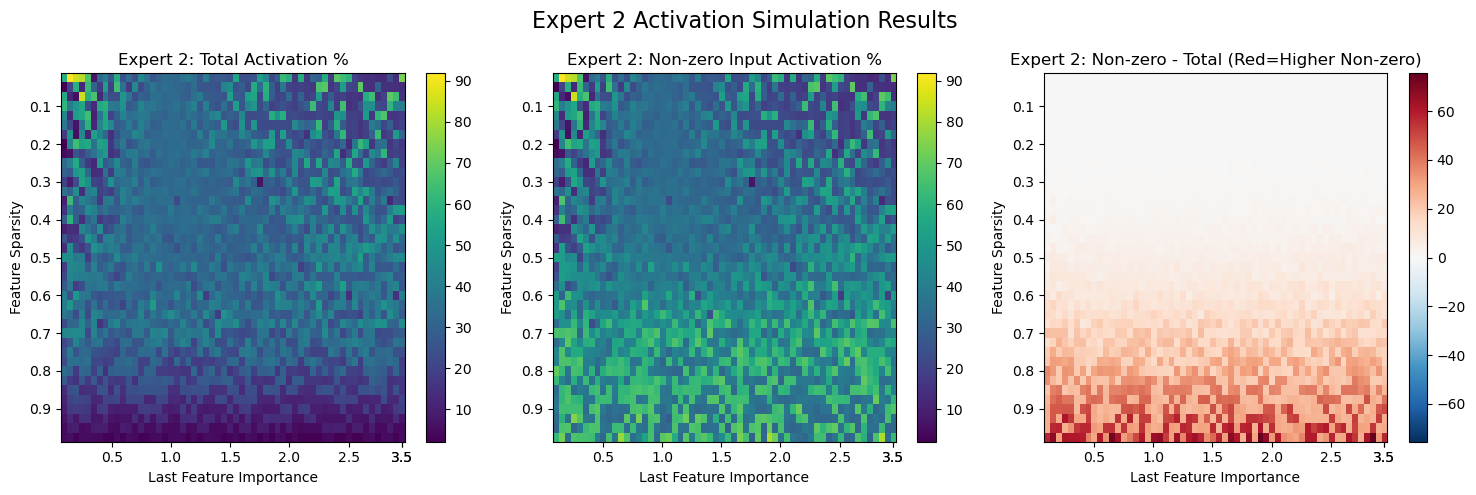


=== Expert 2 Simulation Summary ===
Total activation: 29.25% ± 12.40%
Non-zero input activation: 41.04% ± 14.10%
Difference (Non-zero - Total): 11.79%
  → Expert 2 is activated MORE often for non-zero inputs than overall

--- Overall Analysis ---
Analyzing simulation results for all 3 experts


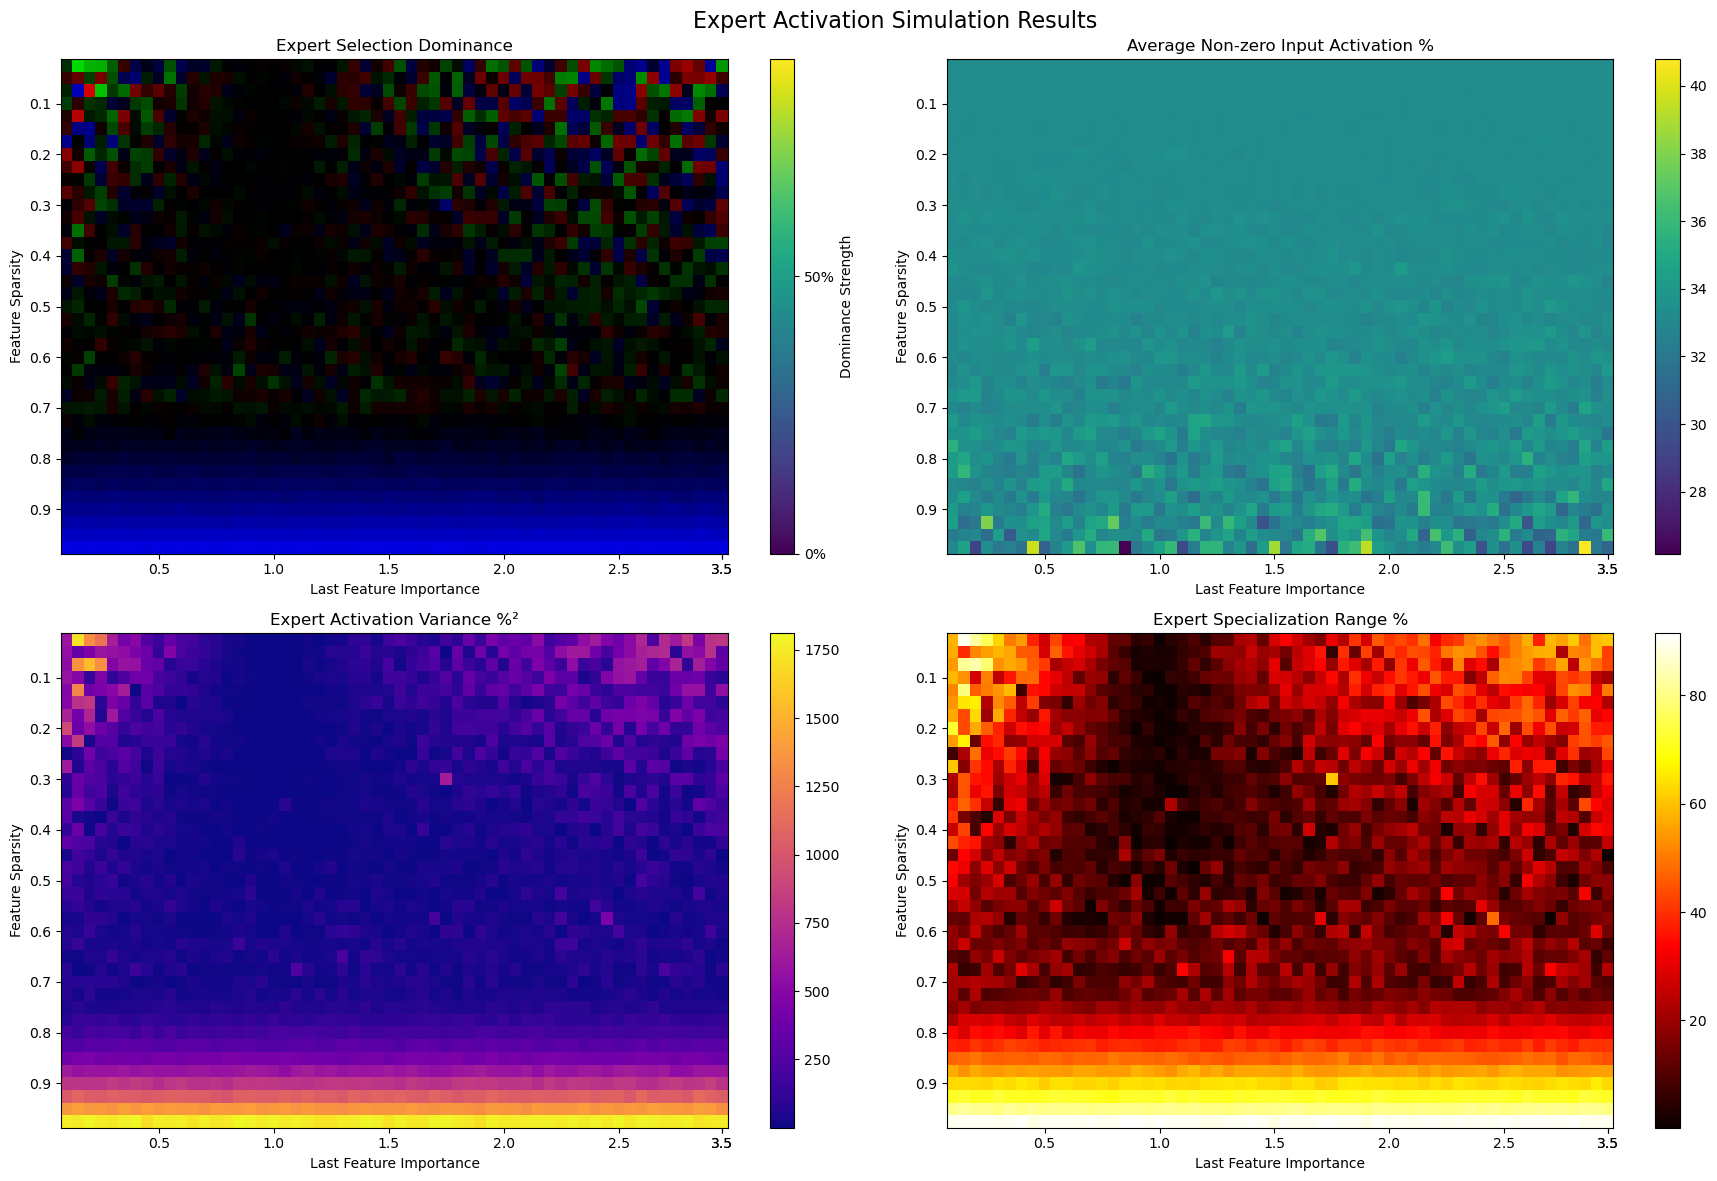


=== Simulation Results Summary ===

Expert 0:
  Total activation: 41.60% ± 18.30%
  Non-zero input activation: 18.20% ± 16.46%
  Difference (Non-zero - Total): -23.40%

Expert 1:
  Total activation: 29.15% ± 12.42%
  Non-zero input activation: 40.78% ± 13.87%
  Difference (Non-zero - Total): 11.63%

Expert 2:
  Total activation: 29.25% ± 12.40%
  Non-zero input activation: 41.04% ± 14.10%
  Difference (Non-zero - Total): 11.79%


In [ ]:
run_phase_change(3,2,3, "323")